# Learn To Synchronize Videos

## Model declaration

In [2]:
from importlib import reload
import torch
import torch.nn as nn
import torchvision.models as models
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import numpy as np
import os
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import sync_net
import trainer
import metrics
import data_loader
reload(sync_net)
reload(trainer)
reload(metrics)
reload(data_loader)
from sync_net import reset_first_layer, replace_last_layer, add_sigmoid_activation, stop_running_var, freeze_model, TripletNet, MultiSiameseNet, TripletLoss, CosineSimilarityTripletLoss, LosslessTripletLoss, MultiSiameseCosineSimilarityLoss, SoftMultiSiameseCosineSimilarityLoss
from trainer import fit
from metrics import EmbeddingL2DistanceMetric, EmbeddingCosineSimilarityMetric, EmbeddingCosineSimilarityAndDistanceLossMetric
from data_loader import get_datasets, get_test_set, get_multisiamese_datasets, get_soft_multisiamese_datasets
# import wandb
# wandb.init(project="learn-to-synchronize-videos")
cuda = torch.cuda.is_available()

torch.cuda.set_device(0)
embedding_net = models.mobilenet_v2(pretrained=True)  # models.resnet50(pretrained=True)
# reset_first_layer(embedding_net)
# freeze_model(embedding_net)
replace_last_layer(embedding_net, 128)  # , dropout=0.5)
embedding_net.apply(stop_running_var)
# embedding_net = add_sigmoid_activation(embedding_net)  # Use only with LosslessTripletLoss
# model = TripletNet(embedding_net)
model = MultiSiameseNet(embedding_net)
model.cuda(0)
model = nn.DataParallel(model).cuda()
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# print([x.requires_grad for x in model.parameters()])
# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
# loss_fn = TripletLoss(margin=0.5)
# loss_fn = CosineSimilarityTripletLoss(margin=0.5)
# loss_fn = LosslessTripletLoss()
# loss_fn = MultiSiameseCosineSimilarityLoss()
loss_fn = SoftMultiSiameseCosineSimilarityLoss()
# scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=4, T_mult=2, eta_min=5e-6, last_epoch=-1)
scheduler = lr_scheduler.StepLR(optimizer, 5, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100
start_epoch = 0
save_path = r"E:\Users\root\Projects\VideoSynchronizationWithPytorch\trainings\reset_classifier_freeze_bn_fc_128_1e-4"
if not os.path.isdir(save_path):
    os.makedirs(save_path)
# wandb.config.lr = lr
# wandb.config.optimizer = type(optimizer)
# wandb.config.loss_fn = type(loss_fn)
print("loaded")

loaded


## Load dataset

### Angio sequence triplets

In [ ]:
training_path = r'C:\Users\root\Data\Angiographie'
validation_path = r'C:\Users\root\Data\Angiographie\KR-11'
training_set, validation_set = get_datasets(training_path, validation_path)

### Angio sequence multi siamese

In [ ]:
training_path = r'C:\Users\root\Data\Angiographie'
validation_path = r'C:\Users\root\Data\Angiographie\KR-11'
training_set, validation_set = get_multisiamese_datasets(training_path, validation_path, 1000, 64)

### Angio sequence soft multi siamese

In [6]:
training_path = r'C:\Users\root\Data\Angiographie'
validation_paths = [
    r'C:\Users\root\Data\Angiographie\ABL-5',
    r'C:\Users\root\Data\Angiographie\G1',
    r'C:\Users\root\Data\Angiographie\G18'
]
max_cycles_for_pairs = 0
sequence = 3
batch_size = 32
inter_video_pairs = True
use_data_augmentation = False
training_set, validation_set = get_soft_multisiamese_datasets(training_path, validation_paths, max_cycles_for_pairs, sequence, 1000, batch_size, inter_video_pairs, use_data_augmentation)

105 valid frames [32, 136] @21 and contracted at index 21, in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30LAO25CAU
110 valid frames [50, 159] @22 and contracted at index 16, in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30RAO
109 valid frames [44, 152] @22 and contracted at index 1, in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30RAO25CAU
76 valid frames [56, 131] @20 and contracted at index 14, in C:\Users\root\Data\Angiographie\AA-4\export\LCA_AP
79 valid frames [53, 131] @21 and contracted at index 17, in C:\Users\root\Data\Angiographie\AA-4\export\LCA_LAT
121 valid frames [35, 155] @21 and contracted at index 27, in C:\Users\root\Data\Angiographie\AA-4\export\RCA_AP
113 valid frames [35, 147] @20 and contracted at index 26, in C:\Users\root\Data\Angiographie\AA-4\export\RCA_LAT
46 valid frames [23, 68] @12 and contracted at index 6, in C:\Users\root\Data\Angiographie\AC-1\export\LCA_40RA015CAU
49 valid frames [26, 74] @11 and contracted at index 7, in C:\Users\root\

68 valid frames [14, 81] @9 and contracted at index 23, in C:\Users\root\Data\Angiographie\KR-11\export\RCA_AP
77 valid frames [11, 87] @9 and contracted at index 26, in C:\Users\root\Data\Angiographie\KR-11\export\RCA_LAT
53 valid frames [25, 77] @11 and contracted at index 17, in C:\Users\root\Data\Angiographie\MAL-8\export\LCA_AP
52 valid frames [25, 76] @11 and contracted at index 17, in C:\Users\root\Data\Angiographie\MAL-8\export\LCA_LAT
43 valid frames [19, 61] @11 and contracted at index 13, in C:\Users\root\Data\Angiographie\MAL-8\export\RCA_AP
40 valid frames [19, 58] @12 and contracted at index 13, in C:\Users\root\Data\Angiographie\MAL-8\export\RCA_LAT
54 valid frames [34, 87] @16 and contracted at index 16, in C:\Users\root\Data\Angiographie\MB-12\export\LCA_30LAO25CRA
54 valid frames [31, 84] @13 and contracted at index 7, in C:\Users\root\Data\Angiographie\MB-12\export\LCA_30RAO
53 valid frames [25, 77] @14 and contracted at index 20, in C:\Users\root\Data\Angiographie\M

Computing pair similarities (20/24)
Computing pair similarities (21/24)
Computing pair similarities (22/24)
Computing pair similarities (23/24)
Computing pair similarities (24/24)


### Load MNIST dataset instead

In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

transformations = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])
mnist_trainset = datasets.MNIST(r"C:\Users\root\Data\MNIST", train=True, download=True, transform=transformations)

In [ ]:
from PIL import Image
from torch.utils.data import Dataset

class TripletMNIST(Dataset):
    """
    Train: For each sample (anchor) randomly chooses a positive and negative samples
    Test: Creates fixed triplets for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        if self.train:
            self.train_labels = self.mnist_dataset.train_labels
            self.train_data = self.mnist_dataset.train_data
            self.labels_set = set(self.train_labels.numpy())
            self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_set}

        else:
            self.test_labels = self.mnist_dataset.test_labels
            self.test_data = self.mnist_dataset.test_data
            # generate fixed triplets for testing
            self.labels_set = set(self.test_labels.numpy())
            self.label_to_indices = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            triplets = [[i,
                         random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                         random_state.choice(self.label_to_indices[
                                                 np.random.choice(
                                                     list(self.labels_set - set([self.test_labels[i].item()]))
                                                 )
                                             ])
                         ]
                        for i in range(len(self.test_data))]
            self.test_triplets = triplets

    def __getitem__(self, index):
        if self.train:
            img1, label1 = self.train_data[index], self.train_labels[index].item()
            positive_index = index
            while positive_index == index:
                positive_index = np.random.choice(self.label_to_indices[label1])
            negative_label = np.random.choice(list(self.labels_set - set([label1])))
            negative_index = np.random.choice(self.label_to_indices[negative_label])
            img2 = self.train_data[positive_index]
            img3 = self.train_data[negative_index]
        else:
            img1 = self.test_data[self.test_triplets[index][0]]
            img2 = self.test_data[self.test_triplets[index][1]]
            img3 = self.test_data[self.test_triplets[index][2]]

        img1 = Image.fromarray(img1.numpy(), mode='L')
        img2 = Image.fromarray(img2.numpy(), mode='L')
        img3 = Image.fromarray(img3.numpy(), mode='L')
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)
        return (img1, img2, img3)

    def __len__(self):
        return len(self.mnist_dataset)
    
    
triplet_mnist = TripletMNIST(mnist_trainset)
train_loader = DataLoader(triplet_mnist, batch_size=20, shuffle=True, num_workers=0)
# for batch_index, triplet in enumerate(train_loader):
#     for i, image in enumerate(triplet):
#         print(f"batch {batch_index}, i {i}, triplet {image.numpy().shape}")
#         plt.subplot(1, 3, i+1)
#         plt.imshow(image.view(224, 224).numpy())
#         plt.title("Anchor" if i == 0 else "Positive" if i == 1 else "Negative")
#     plt.show()
metrics = [EmbeddingL2DistanceMetric(), EmbeddingCosineSimilarityMetric()]
fit(train_loader, None, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, start_epoch=start_epoch, save_progress_path=save_path, metrics=metrics)

## Load training state

In [ ]:
# load_state_path = save_path + r"\training_state_0.pth"
load_state_path = r"E:\Users\root\Projects\VideoSynchronizationWithPytorch\trainings\freeze_after_3_epochs\training_state_2.pth"
print(load_state_path)
state = torch.load(load_state_path)
print(state.keys())

start_epoch = int(state['epoch']) + 1
model.load_state_dict(state['model'])
optimizer.load_state_dict(state['optimizer'])
scheduler.load_state_dict(state['scheduler'])

## Train

In [12]:
torch.cuda.empty_cache()  # Doesn't always work to free the GPU memory

### Angio sequence triplets

In [ ]:
train_loader = DataLoader(training_set, batch_size=20, shuffle=True, num_workers=4)
val_loader = DataLoader(validation_set, batch_size=20, shuffle=True, num_workers=4)
metrics = [EmbeddingL2DistanceMetric(), EmbeddingCosineSimilarityMetric()]
fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, start_epoch=start_epoch, save_progress_path=save_path, metrics=metrics, measure_weights=True)

### Angio sequence multisiamese

Starting Epoch 0
Will sample from train_loader
Train: [6400/1000 (10%)]	Loss: 0.232797	Elapsed time: 0:00:28.719162	FCWeights (Diff, Avg, Total): (2.4927287101745605, 0.03268860653042793, 5355.701171875)
Train: [12800/1000 (20%)]	Loss: 0.163061	Elapsed time: 0:00:50.450283	FCWeights (Diff, Avg, Total): (2.4405922889709473, 0.03269553557038307, 5356.83642578125)
Train: [17700/1000 (30%)]	Loss: 0.136689	Elapsed time: 0:01:12.061737	FCWeights (Diff, Avg, Total): (1.789106845855713, 0.03270287066698074, 5358.0380859375)
Train: [22400/1000 (40%)]	Loss: 0.118033	Elapsed time: 0:01:33.673107	FCWeights (Diff, Avg, Total): (3.6781225204467773, 0.032711587846279144, 5359.46630859375)
Train: [32000/1000 (50%)]	Loss: 0.112644	Elapsed time: 0:01:55.165098	FCWeights (Diff, Avg, Total): (1.5043002367019653, 0.0327218696475029, 5361.15087890625)
Train: [38400/1000 (60%)]	Loss: 0.098232	Elapsed time: 0:02:16.624549	FCWeights (Diff, Avg, Total): (2.4259369373321533, 0.03273070603609085, 5362.59912109375

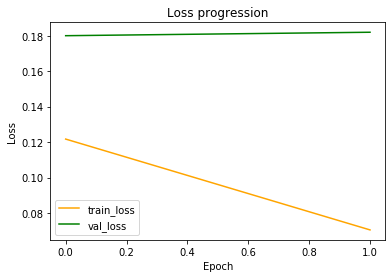

Starting Epoch 2
Will sample from train_loader
Train: [6400/1000 (10%)]	Loss: 0.060300	Elapsed time: 0:00:21.923436	FCWeights (Diff, Avg, Total): (1.0263149738311768, 0.03285921365022659, 5383.6533203125)
Train: [12800/1000 (20%)]	Loss: 0.059932	Elapsed time: 0:00:43.726283	FCWeights (Diff, Avg, Total): (2.356567621231079, 0.032863643020391464, 5384.37939453125)
Train: [19200/1000 (30%)]	Loss: 0.057827	Elapsed time: 0:01:05.619198	FCWeights (Diff, Avg, Total): (1.0775521993637085, 0.03286870941519737, 5385.20947265625)
Train: [25600/1000 (40%)]	Loss: 0.056344	Elapsed time: 0:01:27.385076	FCWeights (Diff, Avg, Total): (1.1907581090927124, 0.03287449851632118, 5386.15771484375)
Train: [32000/1000 (50%)]	Loss: 0.057233	Elapsed time: 0:01:49.183685	FCWeights (Diff, Avg, Total): (1.0467584133148193, 0.03287815302610397, 5386.7568359375)
Train: [38400/1000 (60%)]	Loss: 0.056001	Elapsed time: 0:02:10.964916	FCWeights (Diff, Avg, Total): (0.9980822205543518, 0.0328819639980793, 5387.380859375)

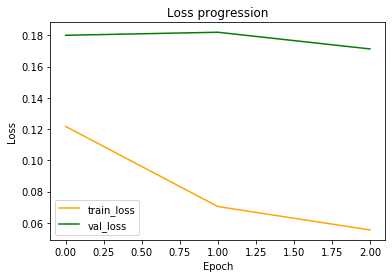

Starting Epoch 3
Will sample from train_loader
Train: [6400/1000 (10%)]	Loss: 0.053207	Elapsed time: 0:00:21.883138	FCWeights (Diff, Avg, Total): (0.5954225063323975, 0.032899729907512665, 5390.29150390625)
Train: [12800/1000 (20%)]	Loss: 0.040611	Elapsed time: 0:00:43.531321	FCWeights (Diff, Avg, Total): (0.5358575582504272, 0.03289971128106117, 5390.28857421875)
Train: [19200/1000 (30%)]	Loss: 0.047209	Elapsed time: 0:01:05.301570	FCWeights (Diff, Avg, Total): (0.651799201965332, 0.03290192037820816, 5390.650390625)
Train: [25600/1000 (40%)]	Loss: 0.047486	Elapsed time: 0:01:27.121557	FCWeights (Diff, Avg, Total): (0.41376492381095886, 0.032902441918849945, 5390.73583984375)
Train: [32000/1000 (50%)]	Loss: 0.043483	Elapsed time: 0:01:48.905021	FCWeights (Diff, Avg, Total): (0.6085222363471985, 0.032903365790843964, 5390.8876953125)
Train: [38400/1000 (60%)]	Loss: 0.045969	Elapsed time: 0:02:10.465955	FCWeights (Diff, Avg, Total): (0.47833308577537537, 0.032904382795095444, 5391.05419

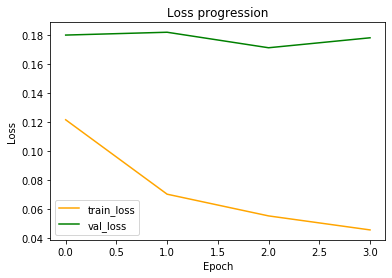

Starting Epoch 4
Will sample from train_loader
Train: [6400/1000 (10%)]	Loss: 0.056916	Elapsed time: 0:00:21.828024	FCWeights (Diff, Avg, Total): (4.096202373504639, 0.03291650861501694, 5393.041015625)
Train: [12800/1000 (20%)]	Loss: 0.065922	Elapsed time: 0:00:43.564929	FCWeights (Diff, Avg, Total): (3.2987632751464844, 0.03292987868189812, 5395.2314453125)
Train: [18300/1000 (30%)]	Loss: 0.058684	Elapsed time: 0:01:05.373947	FCWeights (Diff, Avg, Total): (3.1412298679351807, 0.03293808549642563, 5396.576171875)
Train: [25600/1000 (40%)]	Loss: 0.058189	Elapsed time: 0:01:27.188643	FCWeights (Diff, Avg, Total): (2.626012086868286, 0.032949402928352356, 5398.43017578125)
Train: [32000/1000 (50%)]	Loss: 0.058269	Elapsed time: 0:01:48.798676	FCWeights (Diff, Avg, Total): (2.941669225692749, 0.0329604297876358, 5400.23681640625)
Train: [38400/1000 (60%)]	Loss: 0.061092	Elapsed time: 0:02:10.547660	FCWeights (Diff, Avg, Total): (2.372523069381714, 0.032969798892736435, 5401.77197265625)
Tr

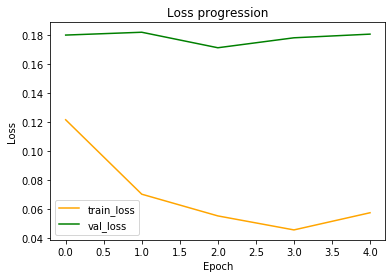

Starting Epoch 5
Will sample from train_loader
Train: [6400/1000 (10%)]	Loss: 0.052302	Elapsed time: 0:00:21.968140	FCWeights (Diff, Avg, Total): (1.9309751987457275, 0.03302006050944328, 5410.0068359375)
Train: [12800/1000 (20%)]	Loss: 0.060525	Elapsed time: 0:00:43.694661	FCWeights (Diff, Avg, Total): (2.7261221408843994, 0.033029619604349136, 5411.57275390625)
Train: [19200/1000 (30%)]	Loss: 0.055137	Elapsed time: 0:01:05.335956	FCWeights (Diff, Avg, Total): (3.4399967193603516, 0.03303973004221916, 5413.2294921875)
Train: [25600/1000 (40%)]	Loss: 0.061107	Elapsed time: 0:01:27.038325	FCWeights (Diff, Avg, Total): (1.9015560150146484, 0.03305131569504738, 5415.12744140625)
Train: [32000/1000 (50%)]	Loss: 0.051271	Elapsed time: 0:01:48.804731	FCWeights (Diff, Avg, Total): (1.688672661781311, 0.03306041657924652, 5416.61865234375)
Train: [38400/1000 (60%)]	Loss: 0.047614	Elapsed time: 0:02:10.464650	FCWeights (Diff, Avg, Total): (2.987699508666992, 0.03306915611028671, 5418.0502929687

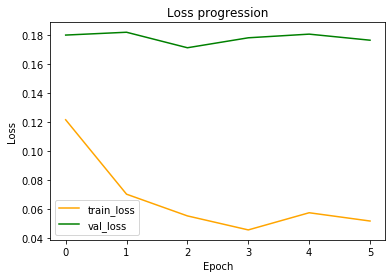

Starting Epoch 6
Will sample from train_loader
Train: [6400/1000 (10%)]	Loss: 0.046135	Elapsed time: 0:00:21.867390	FCWeights (Diff, Avg, Total): (2.1414902210235596, 0.03311074525117874, 5424.86474609375)
Train: [12600/1000 (20%)]	Loss: 0.053174	Elapsed time: 0:00:43.664829	FCWeights (Diff, Avg, Total): (1.9692646265029907, 0.03311727195978165, 5425.93359375)
Train: [18900/1000 (30%)]	Loss: 0.045792	Elapsed time: 0:01:05.364165	FCWeights (Diff, Avg, Total): (2.480206251144409, 0.0331290028989315, 5427.85595703125)
Train: [24400/1000 (40%)]	Loss: 0.042633	Elapsed time: 0:01:27.086194	FCWeights (Diff, Avg, Total): (2.0621602535247803, 0.03313419595360756, 5428.70654296875)
Train: [32000/1000 (50%)]	Loss: 0.047869	Elapsed time: 0:01:48.925902	FCWeights (Diff, Avg, Total): (1.8676769733428955, 0.03314277157187462, 5430.11181640625)
Train: [35400/1000 (60%)]	Loss: 0.043672	Elapsed time: 0:02:10.649580	FCWeights (Diff, Avg, Total): (1.505945086479187, 0.03315195441246033, 5431.6162109375)
T

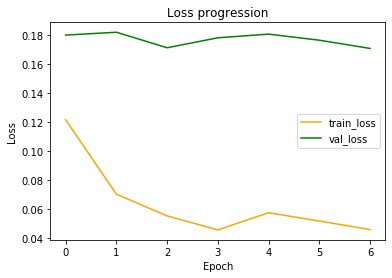

Starting Epoch 7
Will sample from train_loader
Train: [5800/1000 (10%)]	Loss: 0.048171	Elapsed time: 0:00:21.792670	FCWeights (Diff, Avg, Total): (2.215059280395508, 0.033190224319696426, 5437.88623046875)
Train: [12800/1000 (20%)]	Loss: 0.046171	Elapsed time: 0:00:43.426639	FCWeights (Diff, Avg, Total): (1.612242579460144, 0.033196937292814255, 5438.986328125)
Train: [19200/1000 (30%)]	Loss: 0.038857	Elapsed time: 0:01:05.016258	FCWeights (Diff, Avg, Total): (1.9119850397109985, 0.03320254385471344, 5439.90478515625)
Train: [25600/1000 (40%)]	Loss: 0.043630	Elapsed time: 0:01:26.730807	FCWeights (Diff, Avg, Total): (2.7458717823028564, 0.03320963308215141, 5441.06640625)
Train: [30500/1000 (50%)]	Loss: 0.039637	Elapsed time: 0:01:48.474172	FCWeights (Diff, Avg, Total): (1.5777164697647095, 0.033216558396816254, 5442.20068359375)
Train: [38400/1000 (60%)]	Loss: 0.040867	Elapsed time: 0:02:10.274842	FCWeights (Diff, Avg, Total): (1.477168321609497, 0.03322024270892143, 5442.8046875)
Tra

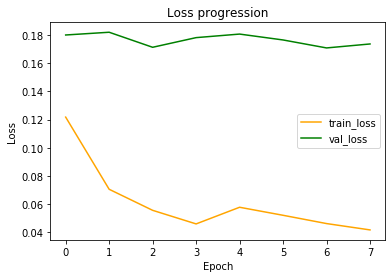

Starting Epoch 8
Will sample from train_loader
Train: [6400/1000 (10%)]	Loss: 0.039656	Elapsed time: 0:00:21.874180	FCWeights (Diff, Avg, Total): (1.197990894317627, 0.03325318172574043, 5448.201171875)
Train: [12800/1000 (20%)]	Loss: 0.038151	Elapsed time: 0:00:43.532742	FCWeights (Diff, Avg, Total): (0.987420916557312, 0.03325646370649338, 5448.7392578125)
Train: [19200/1000 (30%)]	Loss: 0.035735	Elapsed time: 0:01:05.156669	FCWeights (Diff, Avg, Total): (1.3992328643798828, 0.03325994685292244, 5449.3095703125)
Train: [25600/1000 (40%)]	Loss: 0.036549	Elapsed time: 0:01:26.817343	FCWeights (Diff, Avg, Total): (1.3109592199325562, 0.03326600417494774, 5450.30224609375)
Train: [32000/1000 (50%)]	Loss: 0.044047	Elapsed time: 0:01:48.595055	FCWeights (Diff, Avg, Total): (1.6855723857879639, 0.033269524574279785, 5450.87890625)
Train: [38400/1000 (60%)]	Loss: 0.042515	Elapsed time: 0:02:10.358639	FCWeights (Diff, Avg, Total): (0.9774380922317505, 0.03327443450689316, 5451.68310546875)
Tr

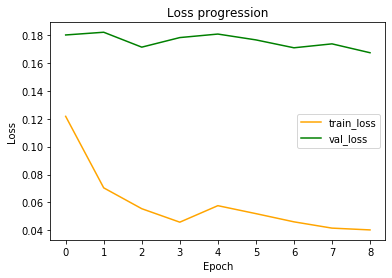

Starting Epoch 9
Will sample from train_loader
Train: [6400/1000 (10%)]	Loss: 0.036070	Elapsed time: 0:00:22.014833	FCWeights (Diff, Avg, Total): (1.1552962064743042, 0.03329391032457352, 5454.8740234375)
Train: [12800/1000 (20%)]	Loss: 0.029980	Elapsed time: 0:00:43.907296	FCWeights (Diff, Avg, Total): (0.8018311262130737, 0.033298201858997345, 5455.57763671875)
Train: [19200/1000 (30%)]	Loss: 0.038334	Elapsed time: 0:01:05.559334	FCWeights (Diff, Avg, Total): (1.4786958694458008, 0.03330027312040329, 5455.9169921875)
Train: [25600/1000 (40%)]	Loss: 0.043653	Elapsed time: 0:01:27.372442	FCWeights (Diff, Avg, Total): (0.9714157581329346, 0.033303044736385345, 5456.37109375)
Train: [32000/1000 (50%)]	Loss: 0.035234	Elapsed time: 0:01:49.007960	FCWeights (Diff, Avg, Total): (0.9575932025909424, 0.03330567106604576, 5456.80126953125)
Train: [38400/1000 (60%)]	Loss: 0.032771	Elapsed time: 0:02:10.799644	FCWeights (Diff, Avg, Total): (1.192111611366272, 0.03330759331583977, 5457.1162109375)

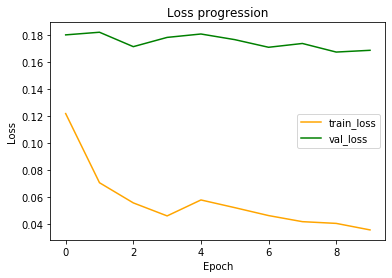

Starting Epoch 10
Will sample from train_loader
Train: [5900/1000 (10%)]	Loss: 0.039221	Elapsed time: 0:00:21.896851	FCWeights (Diff, Avg, Total): (0.5722146034240723, 0.0333210751414299, 5459.3251953125)
Train: [12800/1000 (20%)]	Loss: 0.031172	Elapsed time: 0:00:43.715701	FCWeights (Diff, Avg, Total): (0.47727569937705994, 0.033322326838970184, 5459.5302734375)
Train: [19200/1000 (30%)]	Loss: 0.032085	Elapsed time: 0:01:05.367127	FCWeights (Diff, Avg, Total): (0.453019380569458, 0.03332392871379852, 5459.79248046875)
Train: [25600/1000 (40%)]	Loss: 0.037441	Elapsed time: 0:01:27.067348	FCWeights (Diff, Avg, Total): (0.5185322165489197, 0.03332514688372612, 5459.9921875)
Train: [32000/1000 (50%)]	Loss: 0.028546	Elapsed time: 0:01:48.732003	FCWeights (Diff, Avg, Total): (0.9253013134002686, 0.03332598879933357, 5460.1298828125)
Train: [38400/1000 (60%)]	Loss: 0.035759	Elapsed time: 0:02:10.391466	FCWeights (Diff, Avg, Total): (0.6427291035652161, 0.033326856791973114, 5460.27197265625)

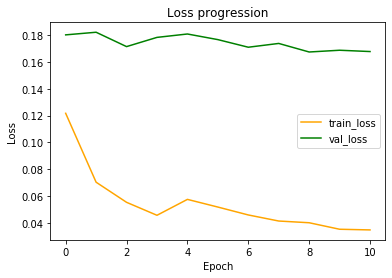

Starting Epoch 11
Will sample from train_loader
Train: [6400/1000 (10%)]	Loss: 0.026461	Elapsed time: 0:00:21.910508	FCWeights (Diff, Avg, Total): (0.24260313808918, 0.03333248943090439, 5461.19482421875)
Train: [12800/1000 (20%)]	Loss: 0.032543	Elapsed time: 0:00:43.487223	FCWeights (Diff, Avg, Total): (0.25501343607902527, 0.03333204239606857, 5461.12158203125)
Train: [19200/1000 (30%)]	Loss: 0.032326	Elapsed time: 0:01:05.344136	FCWeights (Diff, Avg, Total): (0.30904102325439453, 0.0333326980471611, 5461.22900390625)
Train: [25600/1000 (40%)]	Loss: 0.029384	Elapsed time: 0:01:27.037228	FCWeights (Diff, Avg, Total): (0.3390175700187683, 0.03333337977528572, 5461.3408203125)
Train: [32000/1000 (50%)]	Loss: 0.030065	Elapsed time: 0:01:48.740859	FCWeights (Diff, Avg, Total): (0.2379969209432602, 0.03333386406302452, 5461.42041015625)
Train: [38400/1000 (60%)]	Loss: 0.030429	Elapsed time: 0:02:10.515279	FCWeights (Diff, Avg, Total): (0.2722622752189636, 0.03333420306444168, 5461.47558593

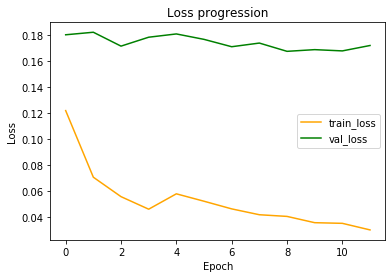

Starting Epoch 12
Will sample from train_loader
Train: [6400/1000 (10%)]	Loss: 0.038603	Elapsed time: 0:00:22.021086	FCWeights (Diff, Avg, Total): (2.514301061630249, 0.03334935009479523, 5463.95751953125)
Train: [11800/1000 (20%)]	Loss: 0.048062	Elapsed time: 0:00:43.706493	FCWeights (Diff, Avg, Total): (4.525233268737793, 0.033359356224536896, 5465.5966796875)
Train: [19200/1000 (30%)]	Loss: 0.035795	Elapsed time: 0:01:05.524267	FCWeights (Diff, Avg, Total): (1.9603508710861206, 0.033370211720466614, 5467.37548828125)
Train: [25600/1000 (40%)]	Loss: 0.038374	Elapsed time: 0:01:27.244865	FCWeights (Diff, Avg, Total): (2.667212724685669, 0.033383190631866455, 5469.501953125)
Train: [32000/1000 (50%)]	Loss: 0.040362	Elapsed time: 0:01:49.009898	FCWeights (Diff, Avg, Total): (2.249629020690918, 0.033393509685993195, 5471.1923828125)
Train: [38400/1000 (60%)]	Loss: 0.039775	Elapsed time: 0:02:10.882748	FCWeights (Diff, Avg, Total): (2.112748861312866, 0.033404164016246796, 5472.9379882812

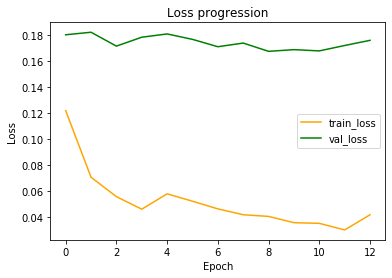

Starting Epoch 13
Will sample from train_loader
Train: [6400/1000 (10%)]	Loss: 0.048486	Elapsed time: 0:00:21.934995	FCWeights (Diff, Avg, Total): (2.497455596923828, 0.033456478267908096, 5481.50927734375)
Train: [12800/1000 (20%)]	Loss: 0.042768	Elapsed time: 0:00:43.550954	FCWeights (Diff, Avg, Total): (1.927074909210205, 0.033464688807725906, 5482.8544921875)
Train: [19200/1000 (30%)]	Loss: 0.035145	Elapsed time: 0:01:05.265676	FCWeights (Diff, Avg, Total): (2.861912727355957, 0.03347442299127579, 5484.44970703125)
Train: [25600/1000 (40%)]	Loss: 0.040831	Elapsed time: 0:01:27.029612	FCWeights (Diff, Avg, Total): (2.164294481277466, 0.0334845669567585, 5486.111328125)
Train: [32000/1000 (50%)]	Loss: 0.043207	Elapsed time: 0:01:48.834344	FCWeights (Diff, Avg, Total): (2.7858529090881348, 0.0334935188293457, 5487.578125)
Train: [38400/1000 (60%)]	Loss: 0.038888	Elapsed time: 0:02:10.725955	FCWeights (Diff, Avg, Total): (2.793811321258545, 0.03350379317998886, 5489.26123046875)
Train:

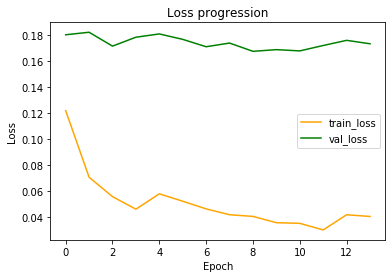

Starting Epoch 14
Will sample from train_loader
Train: [6400/1000 (10%)]	Loss: 0.041934	Elapsed time: 0:00:21.905870	FCWeights (Diff, Avg, Total): (2.187128782272339, 0.03355098143219948, 5496.99267578125)
Train: [12800/1000 (20%)]	Loss: 0.036458	Elapsed time: 0:00:43.505700	FCWeights (Diff, Avg, Total): (2.9550893306732178, 0.033562757074832916, 5498.92236328125)
Train: [18900/1000 (30%)]	Loss: 0.040030	Elapsed time: 0:01:05.114335	FCWeights (Diff, Avg, Total): (2.401667833328247, 0.03356844186782837, 5499.853515625)
Train: [25600/1000 (40%)]	Loss: 0.034233	Elapsed time: 0:01:26.871280	FCWeights (Diff, Avg, Total): (1.92471444606781, 0.03357838839292526, 5501.4833984375)
Train: [32000/1000 (50%)]	Loss: 0.038161	Elapsed time: 0:01:48.549958	FCWeights (Diff, Avg, Total): (2.436089515686035, 0.03358805924654007, 5503.06787109375)
Train: [36600/1000 (60%)]	Loss: 0.038826	Elapsed time: 0:02:10.205967	FCWeights (Diff, Avg, Total): (2.557689905166626, 0.033597566187381744, 5504.62548828125)


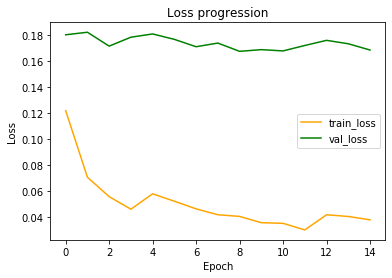

Starting Epoch 15
Will sample from train_loader
Train: [6400/1000 (10%)]	Loss: 0.031797	Elapsed time: 0:00:21.912181	FCWeights (Diff, Avg, Total): (3.401850700378418, 0.033638253808021545, 5511.29150390625)
Train: [12800/1000 (20%)]	Loss: 0.035616	Elapsed time: 0:00:43.614235	FCWeights (Diff, Avg, Total): (2.6815552711486816, 0.03364475816488266, 5512.357421875)
Train: [19200/1000 (30%)]	Loss: 0.039253	Elapsed time: 0:01:05.324002	FCWeights (Diff, Avg, Total): (2.78486967086792, 0.03365417569875717, 5513.89990234375)
Train: [25600/1000 (40%)]	Loss: 0.031186	Elapsed time: 0:01:27.026717	FCWeights (Diff, Avg, Total): (1.8661079406738281, 0.03365873172879219, 5514.646484375)
Train: [29500/1000 (50%)]	Loss: 0.033372	Elapsed time: 0:01:48.816740	FCWeights (Diff, Avg, Total): (2.395075559616089, 0.03366551548242569, 5515.7578125)
Train: [38400/1000 (60%)]	Loss: 0.037124	Elapsed time: 0:02:10.602807	FCWeights (Diff, Avg, Total): (2.903512954711914, 0.03367624804377556, 5517.5166015625)
Train:

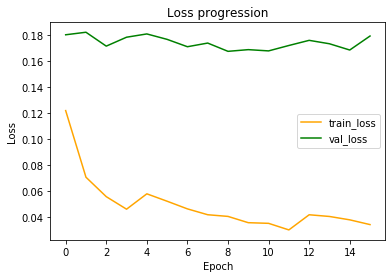

Starting Epoch 16
Will sample from train_loader
Train: [6300/1000 (10%)]	Loss: 0.038212	Elapsed time: 0:00:21.911857	FCWeights (Diff, Avg, Total): (2.3843934535980225, 0.03371531143784523, 5523.91650390625)
Train: [12800/1000 (20%)]	Loss: 0.038231	Elapsed time: 0:00:43.705505	FCWeights (Diff, Avg, Total): (2.755317449569702, 0.03372320160269737, 5525.20947265625)
Train: [18900/1000 (30%)]	Loss: 0.040864	Elapsed time: 0:01:05.448271	FCWeights (Diff, Avg, Total): (2.2269294261932373, 0.033730823546648026, 5526.4580078125)
Train: [25200/1000 (40%)]	Loss: 0.037259	Elapsed time: 0:01:27.110312	FCWeights (Diff, Avg, Total): (1.8342865705490112, 0.03373662382364273, 5527.408203125)
Train: [32000/1000 (50%)]	Loss: 0.038499	Elapsed time: 0:01:48.776964	FCWeights (Diff, Avg, Total): (2.860584020614624, 0.03374564275145531, 5528.88623046875)
Train: [38400/1000 (60%)]	Loss: 0.033466	Elapsed time: 0:02:10.638125	FCWeights (Diff, Avg, Total): (2.5939691066741943, 0.03375128284096718, 5529.8100585937

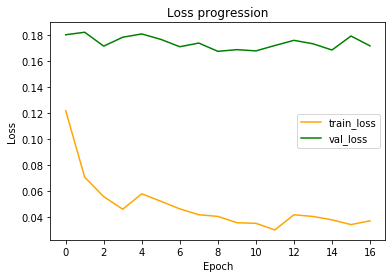

Starting Epoch 17
Will sample from train_loader
Train: [6400/1000 (10%)]	Loss: 0.030683	Elapsed time: 0:00:22.057391	FCWeights (Diff, Avg, Total): (2.8285083770751953, 0.03378426656126976, 5535.21435546875)
Train: [12800/1000 (20%)]	Loss: 0.037705	Elapsed time: 0:00:43.731646	FCWeights (Diff, Avg, Total): (1.9760401248931885, 0.03379475325345993, 5536.9326171875)
Train: [18900/1000 (30%)]	Loss: 0.034728	Elapsed time: 0:01:05.377171	FCWeights (Diff, Avg, Total): (1.6419293880462646, 0.03380199149250984, 5538.1181640625)
Train: [25600/1000 (40%)]	Loss: 0.027809	Elapsed time: 0:01:27.106465	FCWeights (Diff, Avg, Total): (2.1065750122070312, 0.03380623832345009, 5538.81396484375)
Train: [32000/1000 (50%)]	Loss: 0.031212	Elapsed time: 0:01:48.726747	FCWeights (Diff, Avg, Total): (1.8628149032592773, 0.03381304442882538, 5539.92919921875)
Train: [38400/1000 (60%)]	Loss: 0.034361	Elapsed time: 0:02:10.609578	FCWeights (Diff, Avg, Total): (2.350797176361084, 0.033821240067481995, 5541.27197265

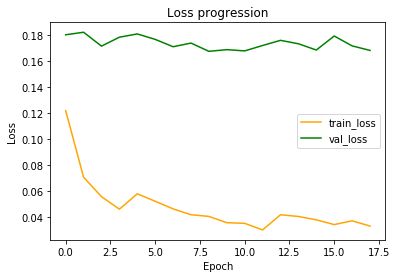

Starting Epoch 18
Will sample from train_loader
Train: [6400/1000 (10%)]	Loss: 0.029835	Elapsed time: 0:00:21.984815	FCWeights (Diff, Avg, Total): (1.653351902961731, 0.03384646773338318, 5545.4052734375)
Train: [12800/1000 (20%)]	Loss: 0.038954	Elapsed time: 0:00:43.662902	FCWeights (Diff, Avg, Total): (1.9271204471588135, 0.03385692462325096, 5547.11865234375)
Train: [19200/1000 (30%)]	Loss: 0.030001	Elapsed time: 0:01:05.410032	FCWeights (Diff, Avg, Total): (1.7124066352844238, 0.03385753557085991, 5547.21875)
Train: [25600/1000 (40%)]	Loss: 0.030502	Elapsed time: 0:01:27.162391	FCWeights (Diff, Avg, Total): (1.8934301137924194, 0.033859983086586, 5547.61962890625)
Train: [29500/1000 (50%)]	Loss: 0.033454	Elapsed time: 0:01:48.756726	FCWeights (Diff, Avg, Total): (2.569263458251953, 0.03386940807104111, 5549.1640625)
Train: [38400/1000 (60%)]	Loss: 0.022320	Elapsed time: 0:02:10.403673	FCWeights (Diff, Avg, Total): (1.957297444343567, 0.033872298896312714, 5549.6376953125)
Train: [4

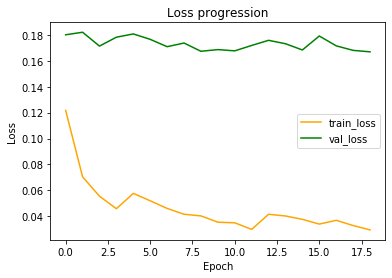

Starting Epoch 19
Will sample from train_loader
Train: [6400/1000 (10%)]	Loss: 0.031968	Elapsed time: 0:00:21.839816	FCWeights (Diff, Avg, Total): (1.5783236026763916, 0.03389640152454376, 5553.58642578125)
Train: [12600/1000 (20%)]	Loss: 0.026392	Elapsed time: 0:00:43.659841	FCWeights (Diff, Avg, Total): (2.12919282913208, 0.03389973193407059, 5554.1318359375)
Train: [17700/1000 (30%)]	Loss: 0.039122	Elapsed time: 0:01:05.301908	FCWeights (Diff, Avg, Total): (2.1809608936309814, 0.033909816294908524, 5555.7841796875)
Train: [25600/1000 (40%)]	Loss: 0.032155	Elapsed time: 0:01:27.156269	FCWeights (Diff, Avg, Total): (1.0320568084716797, 0.03391213342547417, 5556.1640625)
Train: [32000/1000 (50%)]	Loss: 0.030473	Elapsed time: 0:01:48.847737	FCWeights (Diff, Avg, Total): (1.7542914152145386, 0.03391651436686516, 5556.8818359375)
Train: [38400/1000 (60%)]	Loss: 0.030862	Elapsed time: 0:02:10.576225	FCWeights (Diff, Avg, Total): (1.8556355237960815, 0.03391874581575394, 5557.2470703125)
Tr

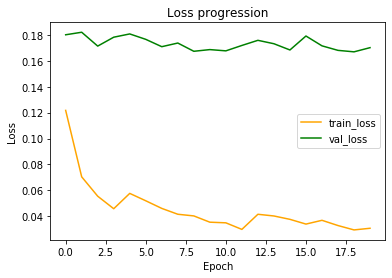

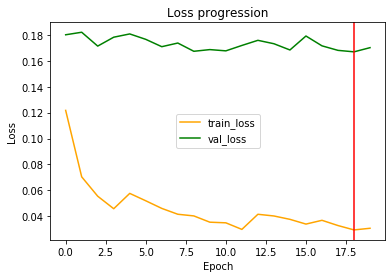

In [7]:
train_loader = DataLoader(training_set, batch_size=1, shuffle=False, num_workers=0)
val_loader = DataLoader(validation_set, batch_size=1, shuffle=False, num_workers=0)
metrics = []  # [EmbeddingCosineSimilarityAndDistanceLossMetric()]
fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, start_epoch=start_epoch, save_progress_path=save_path, metrics=metrics, measure_weights=True)

## Test trained model

### Load model

In [4]:
test_folder_path = r"E:\Users\root\Projects\VideoSynchronizationWithPytorch\trainings\reset_classifier_freeze_bn_fc_128_1e-4"
load_state_path = test_folder_path + r"\training_state_19.pth"
print(load_state_path)
state = torch.load(load_state_path)
model.load_state_dict(state['model'])
model.eval()   

E:\Users\root\Projects\VideoSynchronizationWithPytorch\trainings\reset_classifier_freeze_bn_fc_128_1e-4\training_state_19.pth


DataParallel(
  (module): MultiSiameseNet(
    (embedding_net): MobileNetV2(
      (features): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (2): ReLU6(inplace)
        )
        (1): InvertedResidual(
          (conv): Sequential(
            (0): ConvBNReLU(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
              (2): ReLU6(inplace)
            )
            (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          )
        )
        (2): InvertedResidual(
          (conv): Sequential(
            (0): ConvBNReLU(
     

### Load test set

In [30]:
test_paths = [r'C:\Users\root\Data\Angiographie']
test_paths = [
    r'C:\Users\root\Data\Angiographie\ABL-5',
    r'C:\Users\root\Data\Angiographie\G1',
    r'C:\Users\root\Data\Angiographie\G18'
]
test_set = get_test_set(test_paths)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=1)

105 valid frames [32, 136] @21 and contracted at index 21, in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30LAO25CAU
110 valid frames [50, 159] @22 and contracted at index 16, in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30RAO
109 valid frames [44, 152] @22 and contracted at index 1, in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30RAO25CAU
76 valid frames [56, 131] @20 and contracted at index 14, in C:\Users\root\Data\Angiographie\AA-4\export\LCA_AP
79 valid frames [53, 131] @21 and contracted at index 17, in C:\Users\root\Data\Angiographie\AA-4\export\LCA_LAT
121 valid frames [35, 155] @21 and contracted at index 27, in C:\Users\root\Data\Angiographie\AA-4\export\RCA_AP
113 valid frames [35, 147] @20 and contracted at index 26, in C:\Users\root\Data\Angiographie\AA-4\export\RCA_LAT
76 valid frames [33, 108] @18 and contracted at index 25, in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_30LAO25CRA
82 valid frames [41, 122] @18 and contracted at index 21, in C:\Users\

78 valid frames [37, 114] @17 and contracted at index 22, in C:\Users\root\Data\Angiographie\G18\export\15
75 valid frames [31, 105] @17 and contracted at index 17, in C:\Users\root\Data\Angiographie\G18\export\17
75 valid frames [30, 104] @18 and contracted at index 18, in C:\Users\root\Data\Angiographie\G18\export\18
72 valid frames [35, 106] @18 and contracted at index 20, in C:\Users\root\Data\Angiographie\G18\export\19
96 valid frames [35, 130] @17 and contracted at index 35, in C:\Users\root\Data\Angiographie\G18\export\20
111 valid frames [38, 148] @17 and contracted at index 27, in C:\Users\root\Data\Angiographie\G18\export\9
49 valid frames [26, 74] @9 and contracted at index 6, in C:\Users\root\Data\Angiographie\G2\export\10
55 valid frames [28, 82] @9 and contracted at index 21, in C:\Users\root\Data\Angiographie\G2\export\11
51 valid frames [28, 78] @9 and contracted at index 6, in C:\Users\root\Data\Angiographie\G2\export\7
50 valid frames [26, 75] @9 and contracted at ind

54 valid frames [20, 73] @14 and contracted at index 23, in C:\Users\root\Data\Angiographie\MJY-9\export\RCA_LAT
42 valid frames [17, 58] @10 and contracted at index 24, in C:\Users\root\Data\Angiographie\SB-6\export\RCA_AP
41 valid frames [15, 55] @10 and contracted at index 25, in C:\Users\root\Data\Angiographie\SB-6\export\RCA_LAT
Computing pair similarities (1/154)
Computing pair similarities (2/154)
Computing pair similarities (3/154)
Computing pair similarities (4/154)
Computing pair similarities (5/154)
Computing pair similarities (6/154)
Computing pair similarities (7/154)
Computing pair similarities (8/154)
Computing pair similarities (9/154)
Computing pair similarities (10/154)
Computing pair similarities (11/154)
Computing pair similarities (12/154)
Computing pair similarities (13/154)
Computing pair similarities (14/154)
Computing pair similarities (15/154)
Computing pair similarities (16/154)
Computing pair similarities (17/154)
Computing pair similarities (18/154)
Computi

### Compute distance and similarity matrices for each video

Batch 1/154 (AA-4 LCA_30LAO25CAU) with 103 sequences


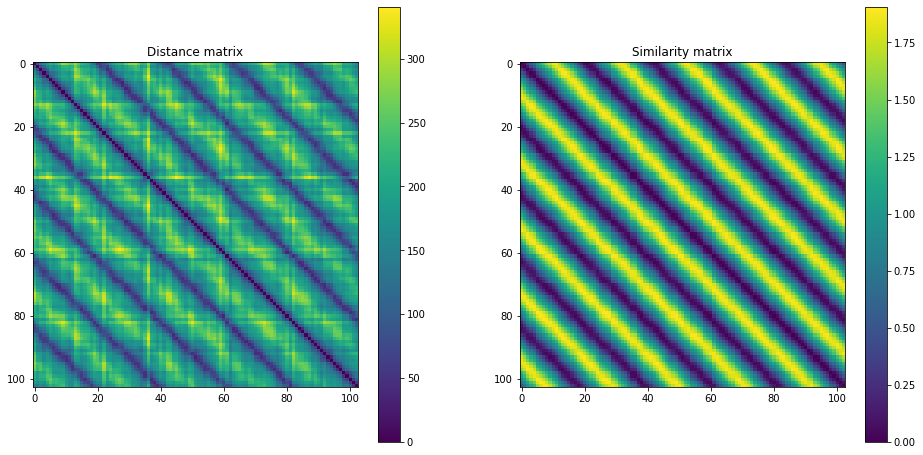

Batch 2/154 (AA-4 LCA_30RAO) with 108 sequences


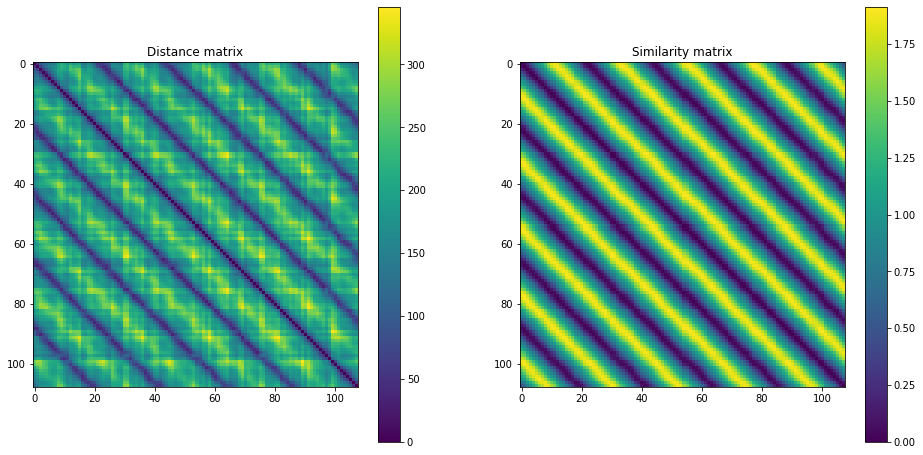

Batch 3/154 (AA-4 LCA_30RAO25CAU) with 107 sequences


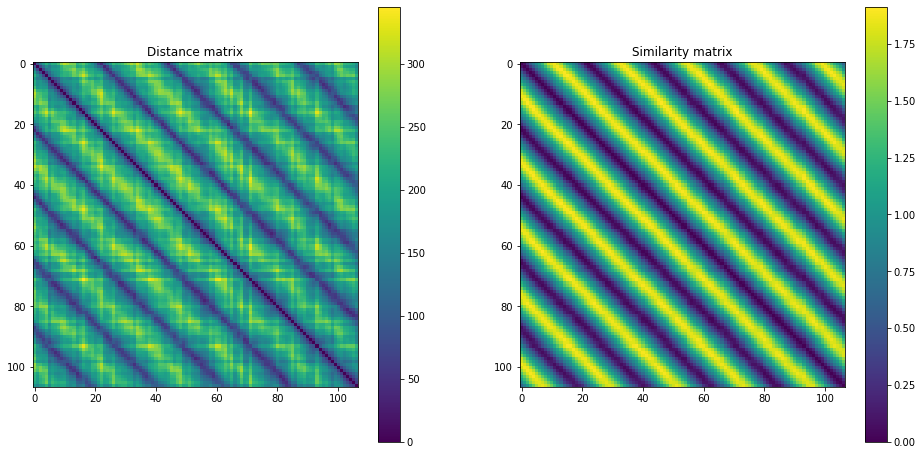

Batch 4/154 (AA-4 LCA_AP) with 74 sequences


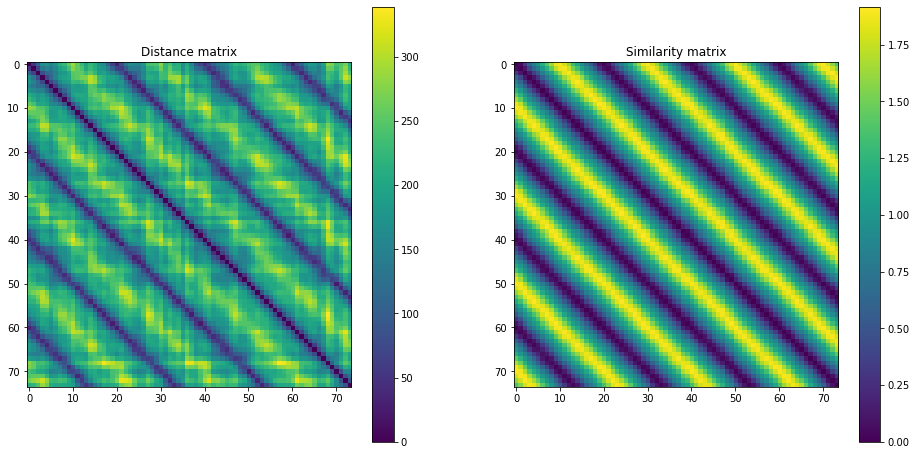

Batch 5/154 (AA-4 LCA_LAT) with 77 sequences


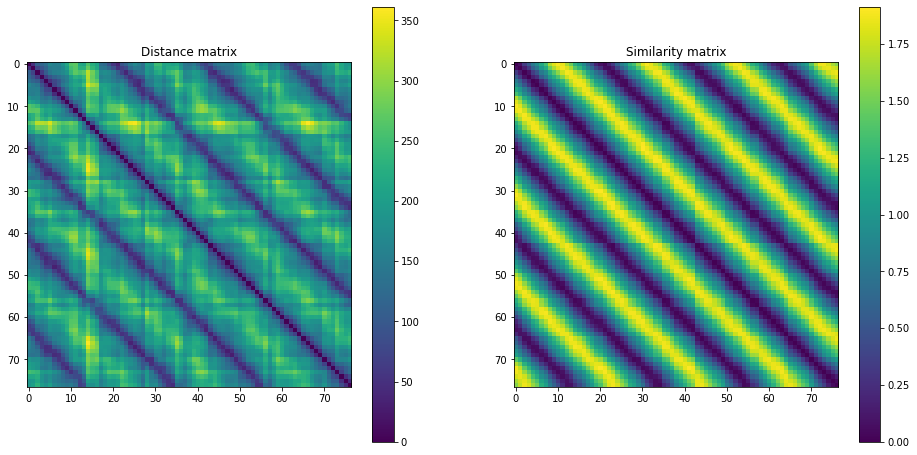

Batch 6/154 (AA-4 RCA_AP) with 119 sequences


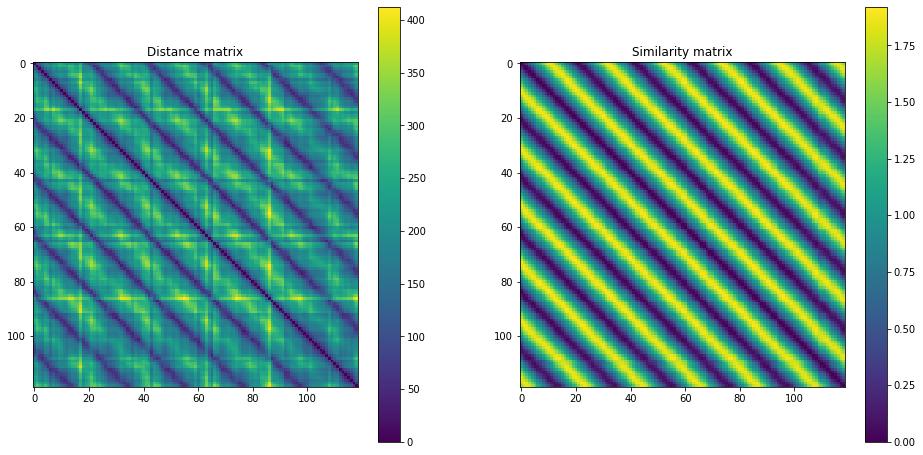

Batch 7/154 (AA-4 RCA_LAT) with 111 sequences


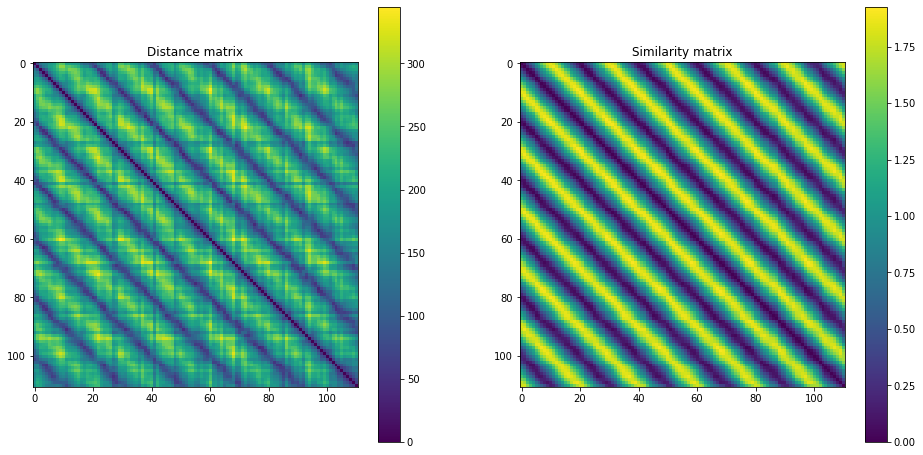

Batch 8/154 (ABL-5 LCA_30LAO25CRA) with 74 sequences


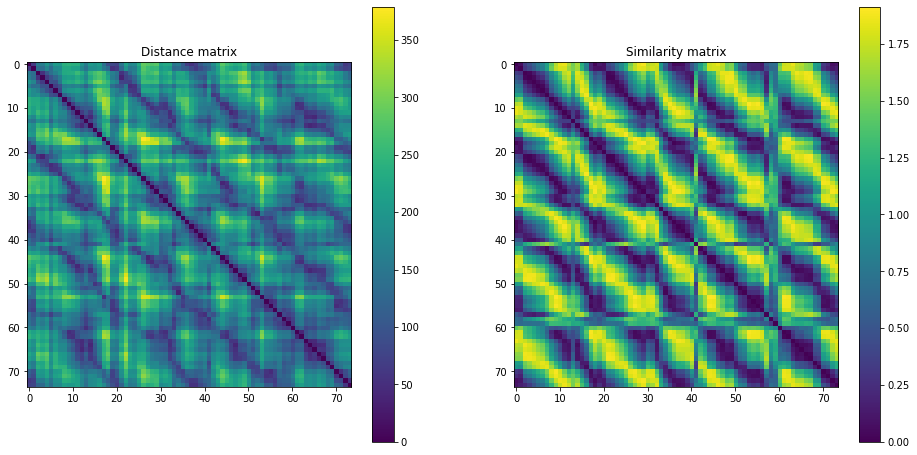

Batch 9/154 (ABL-5 LCA_30RAO) with 80 sequences


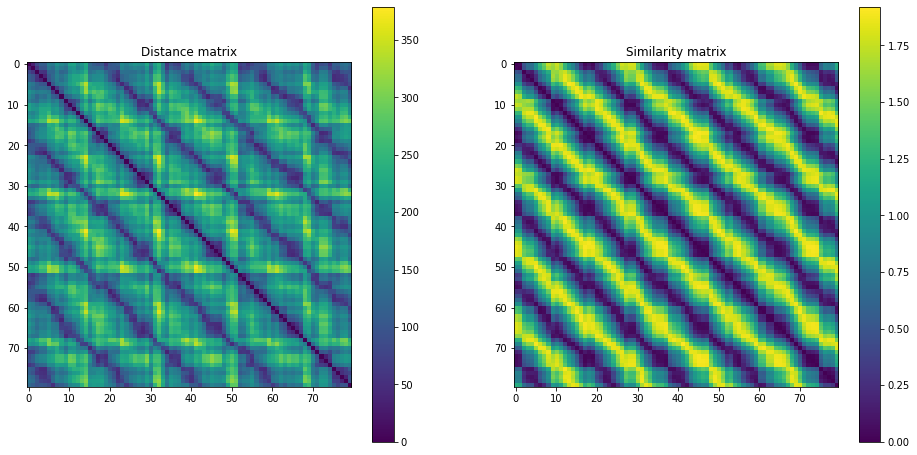

Batch 10/154 (ABL-5 LCA_AP) with 87 sequences


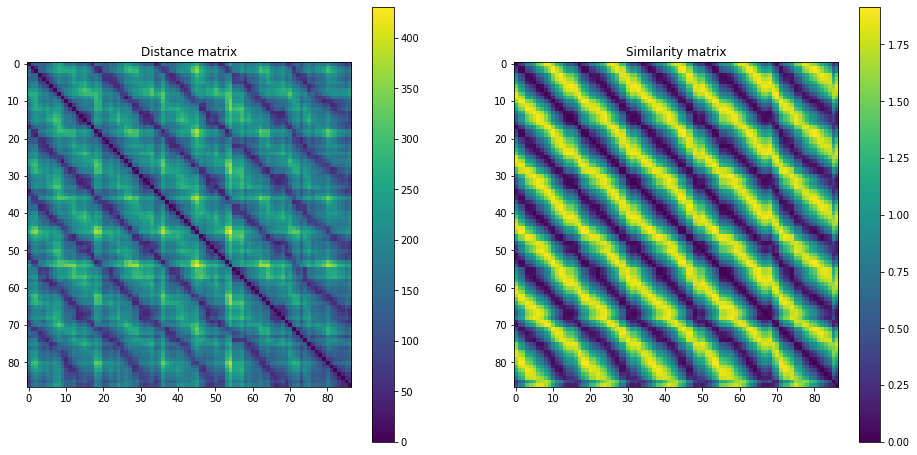

Batch 11/154 (ABL-5 LCA_LAT) with 91 sequences


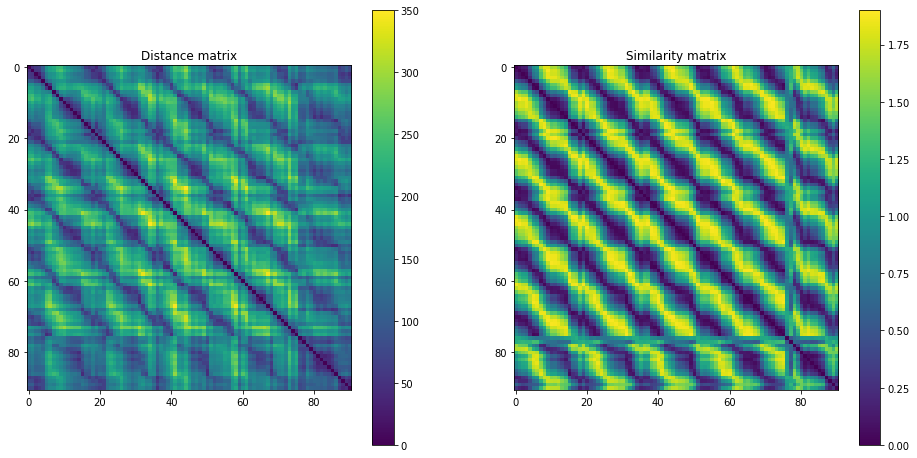

Batch 12/154 (ABL-5 RCA_AP) with 38 sequences


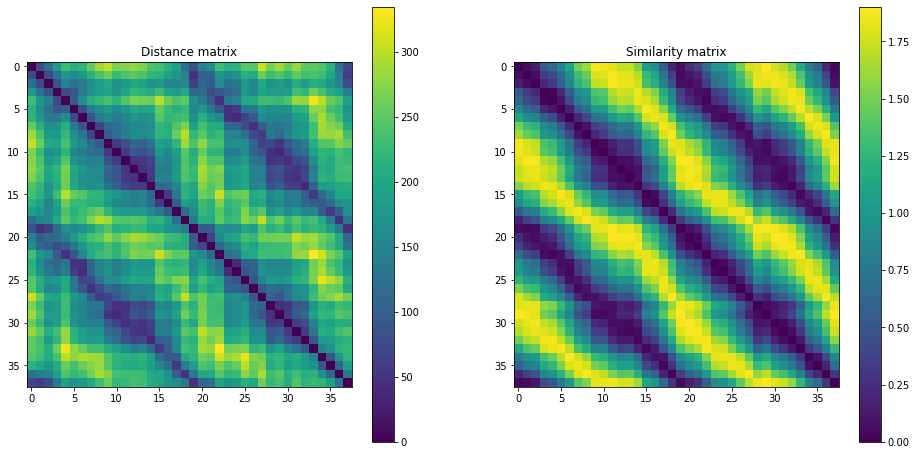

Batch 13/154 (ABL-5 RCA_LAT) with 38 sequences


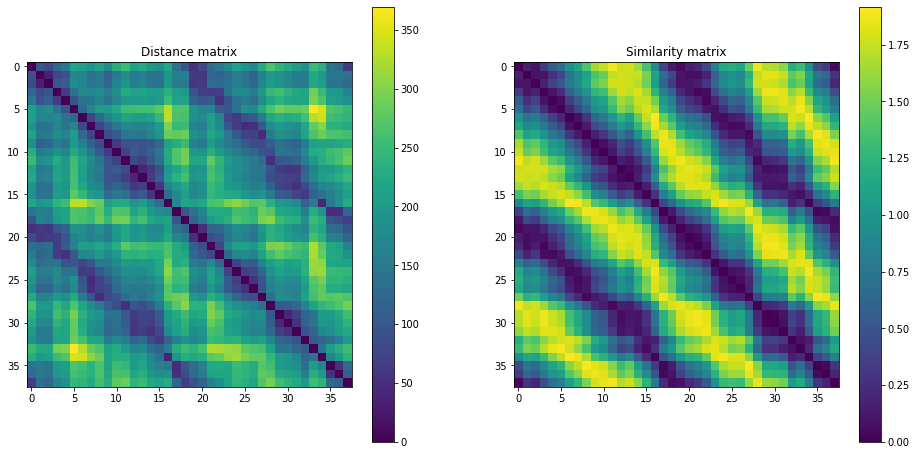

Batch 14/154 (AC-1 LCA_40RA015CAU) with 44 sequences


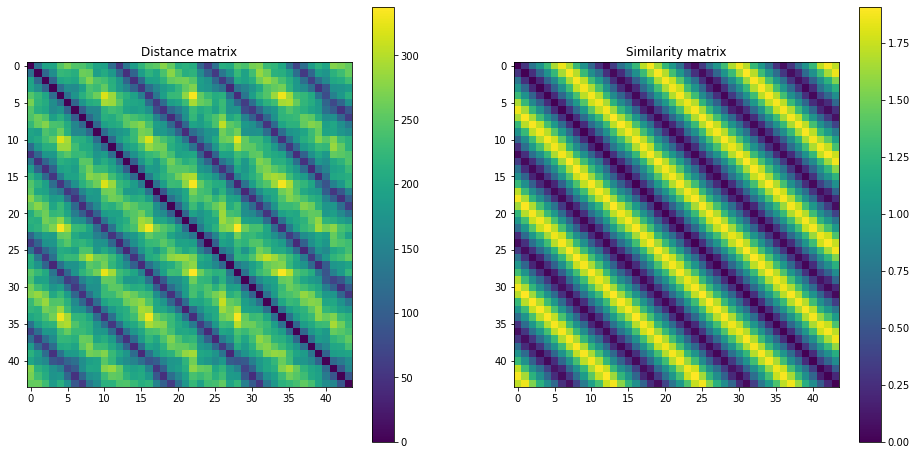

Batch 15/154 (AC-1 LCA_45LAO) with 47 sequences


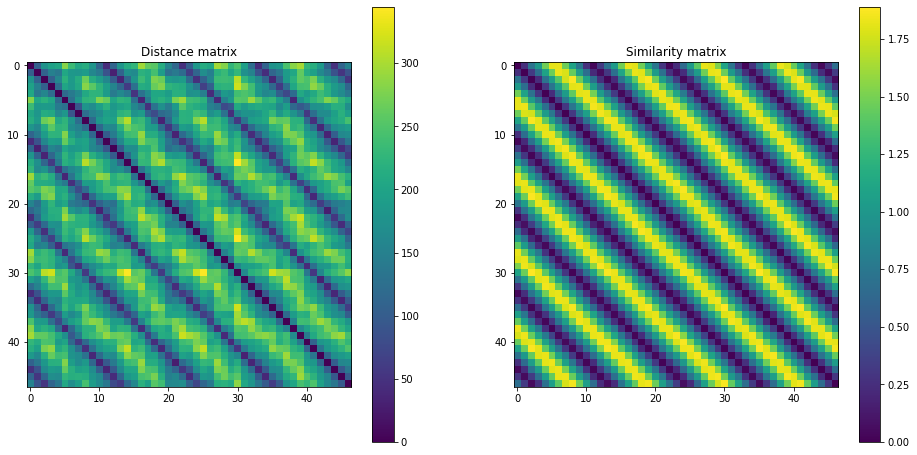

Batch 16/154 (AC-1 LCA_AP) with 51 sequences


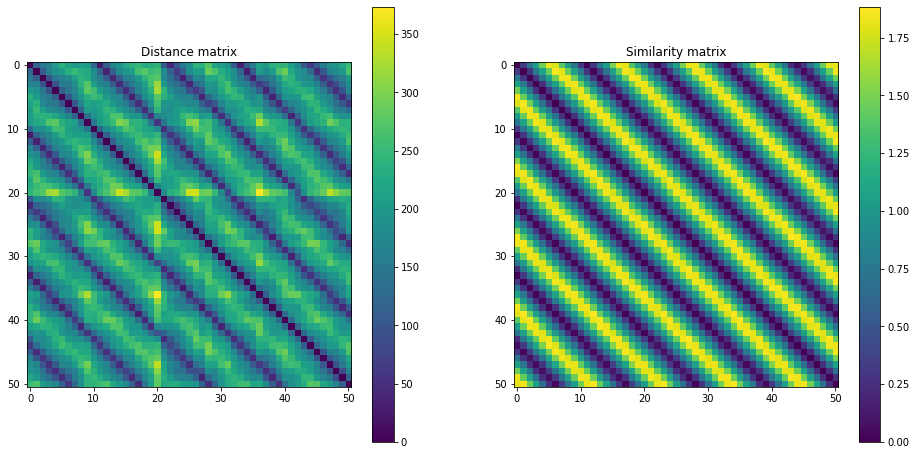

Batch 17/154 (AC-1 LCA_LAT) with 49 sequences


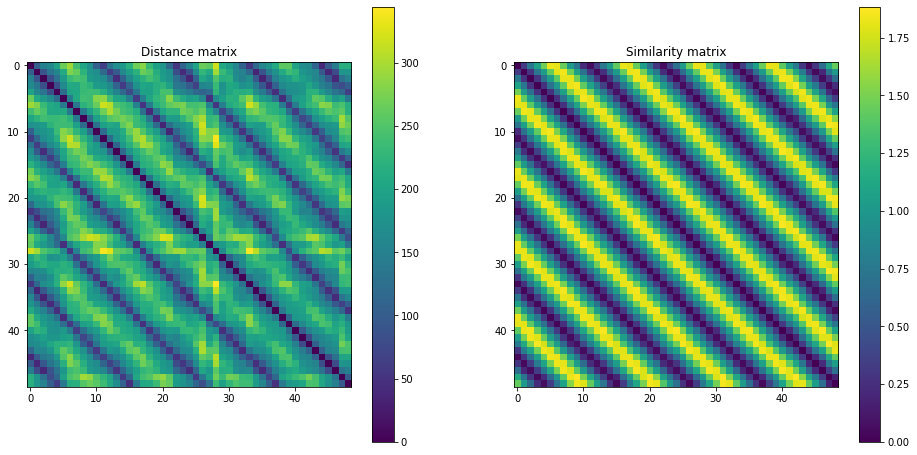

Batch 18/154 (AC-1 RCA_AP) with 67 sequences


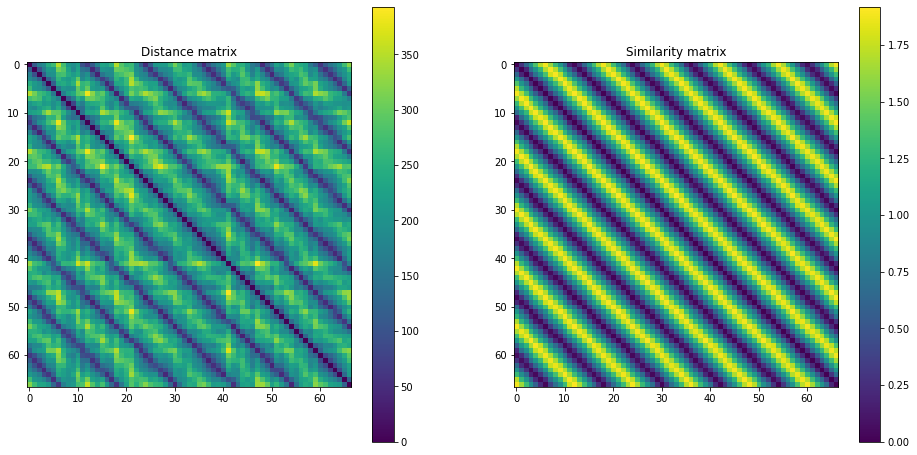

Batch 19/154 (AC-1 RCA_LAT) with 64 sequences


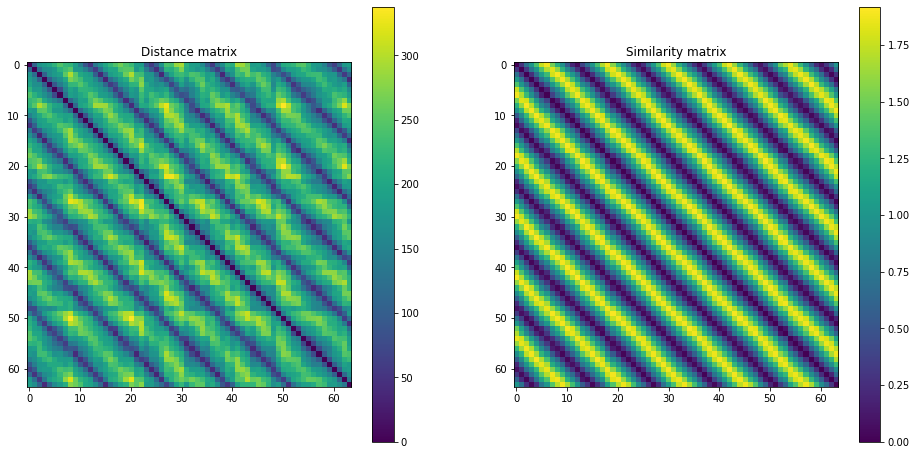

Batch 20/154 (ALR-2 LCA_30LAO25CRA) with 51 sequences


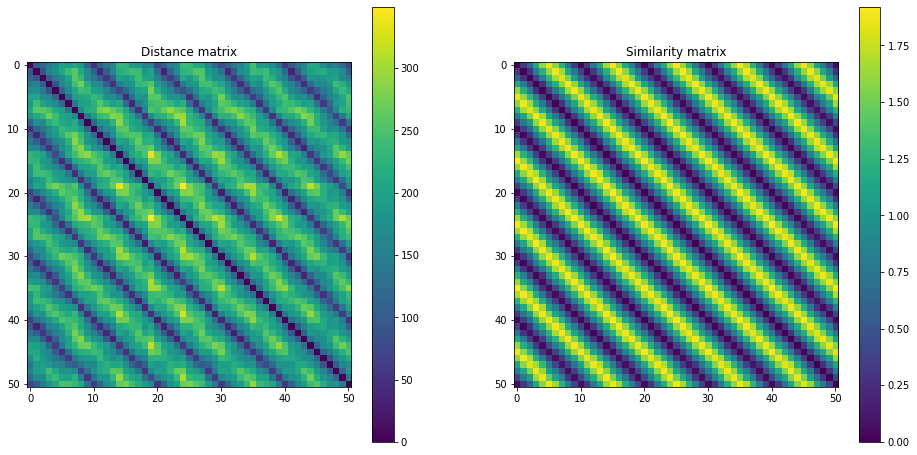

Batch 21/154 (ALR-2 LCA_30RAO) with 47 sequences


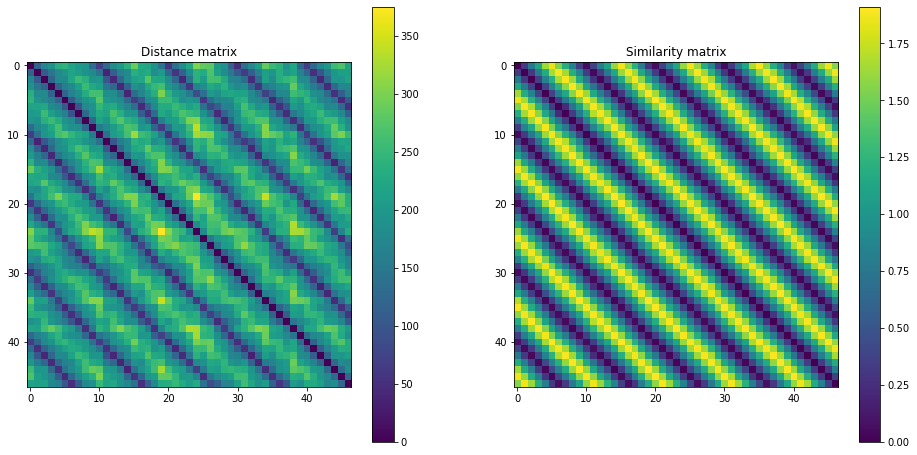

Batch 22/154 (ALR-2 LCA_AP) with 46 sequences


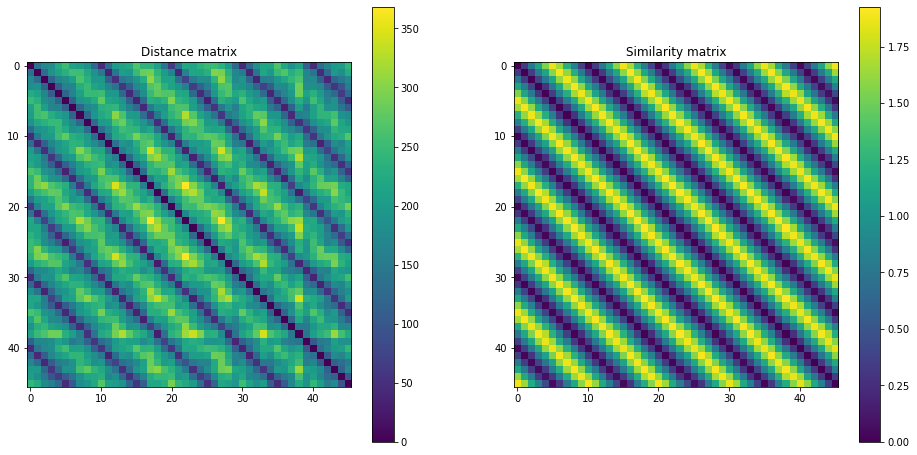

Batch 23/154 (ALR-2 LCA_LAT) with 47 sequences


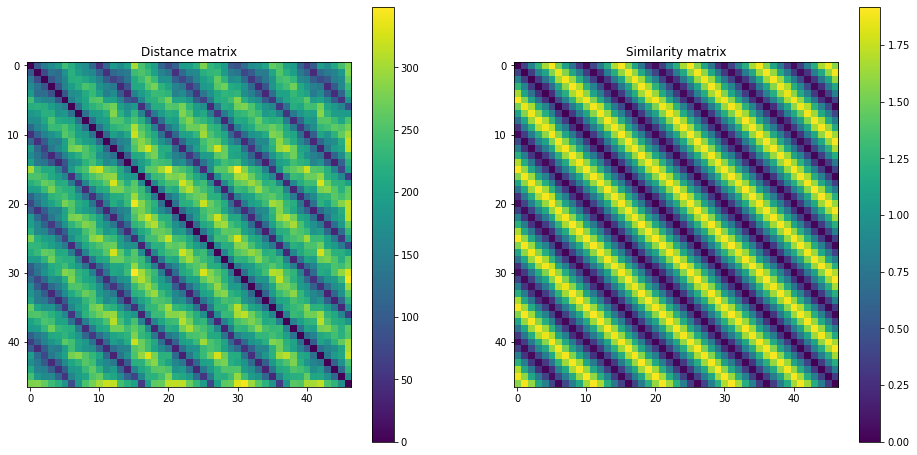

Batch 24/154 (ALR-2 RCA_AP) with 60 sequences


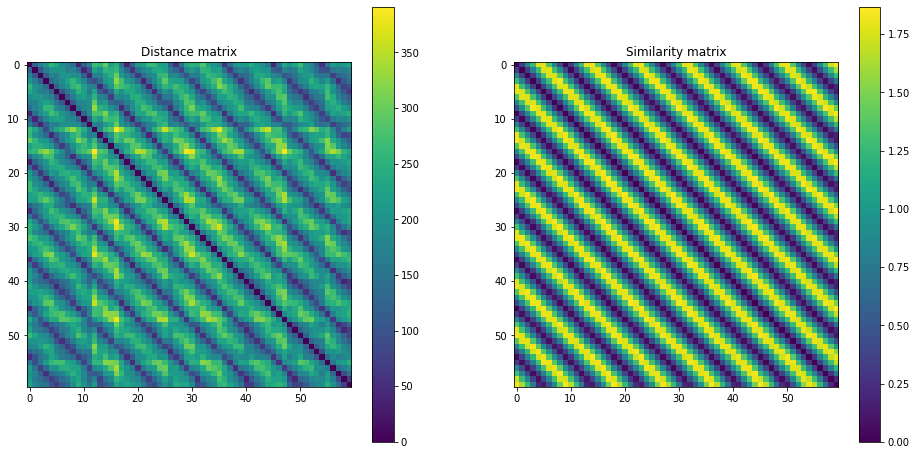

Batch 25/154 (G1 15) with 37 sequences


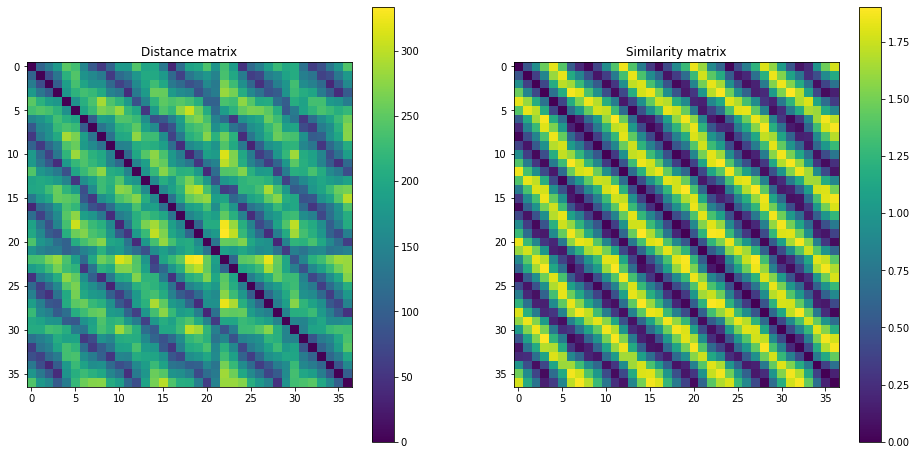

Batch 26/154 (G1 16) with 40 sequences


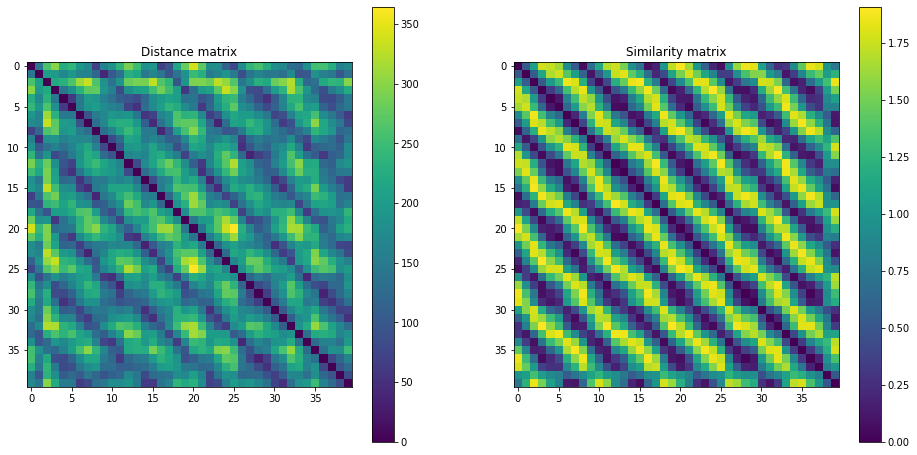

Batch 27/154 (G1 17) with 37 sequences


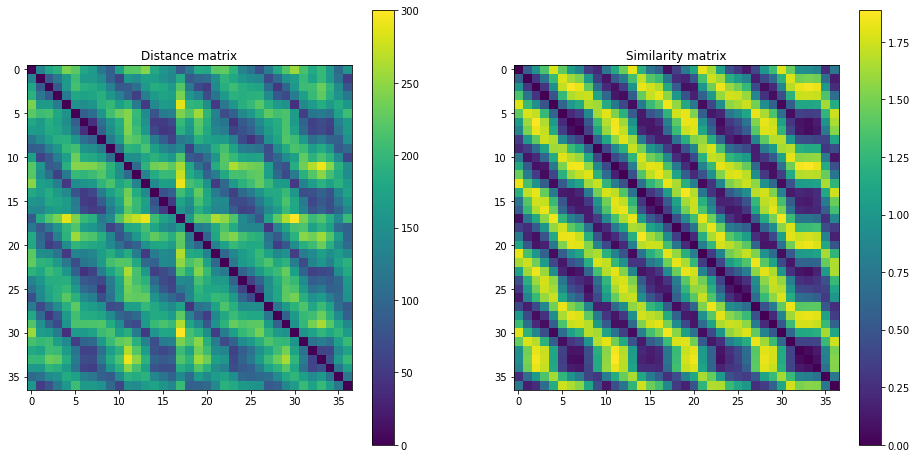

Batch 28/154 (G1 18) with 25 sequences


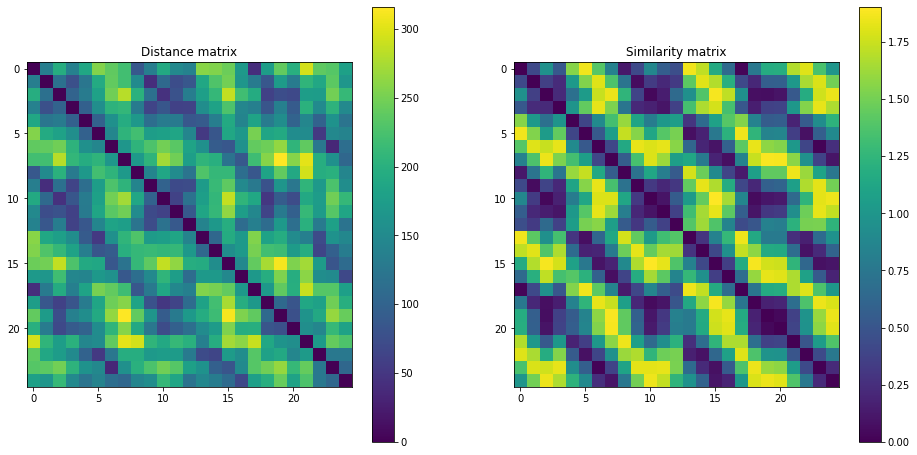

Batch 29/154 (G1 19) with 36 sequences


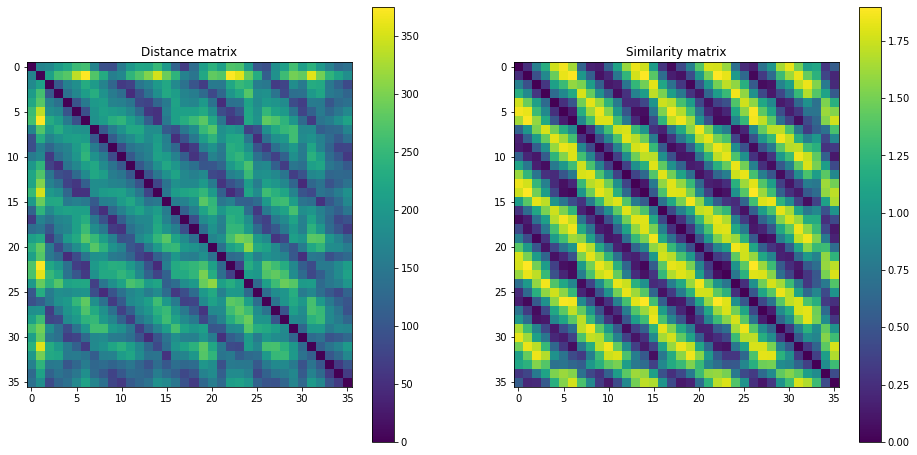

Batch 30/154 (G1 20) with 40 sequences


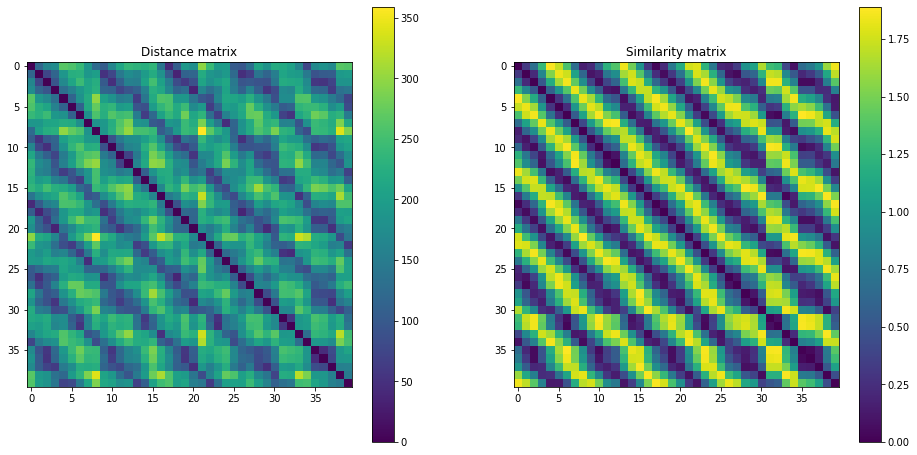

Batch 31/154 (G1 21) with 45 sequences


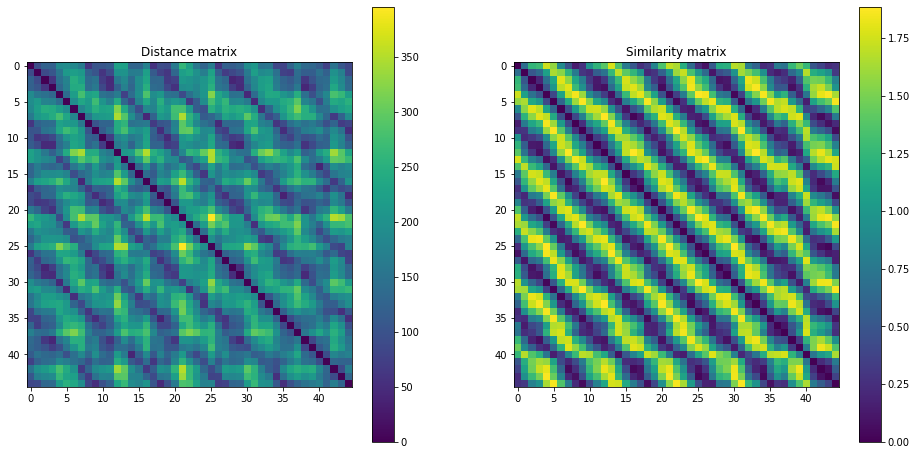

Batch 32/154 (G1 22) with 43 sequences


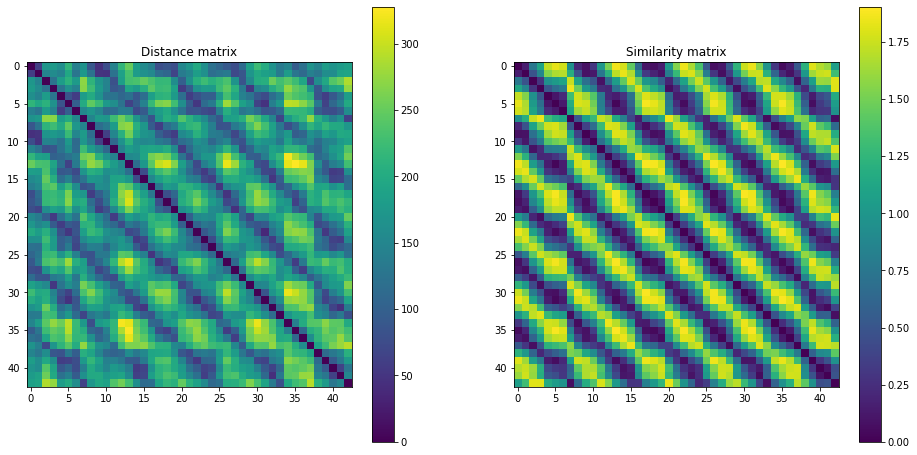

Batch 33/154 (G1 23) with 40 sequences


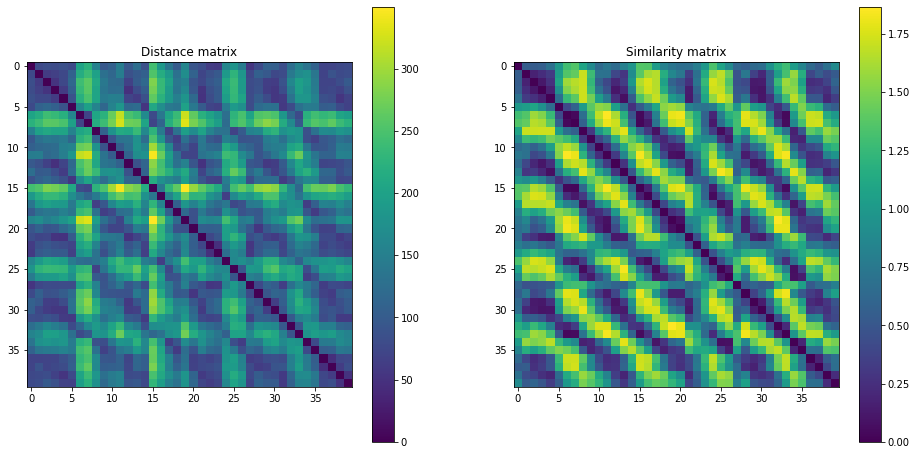

Batch 34/154 (G10 7) with 40 sequences


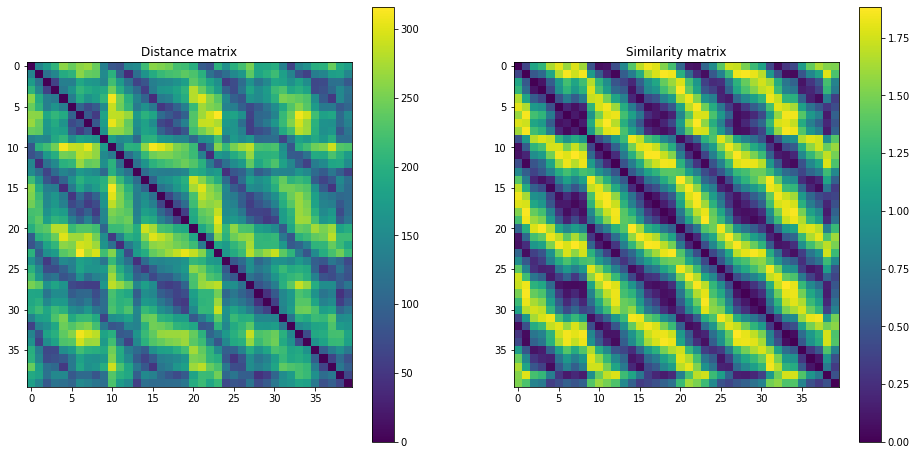

Batch 35/154 (G10 8) with 37 sequences


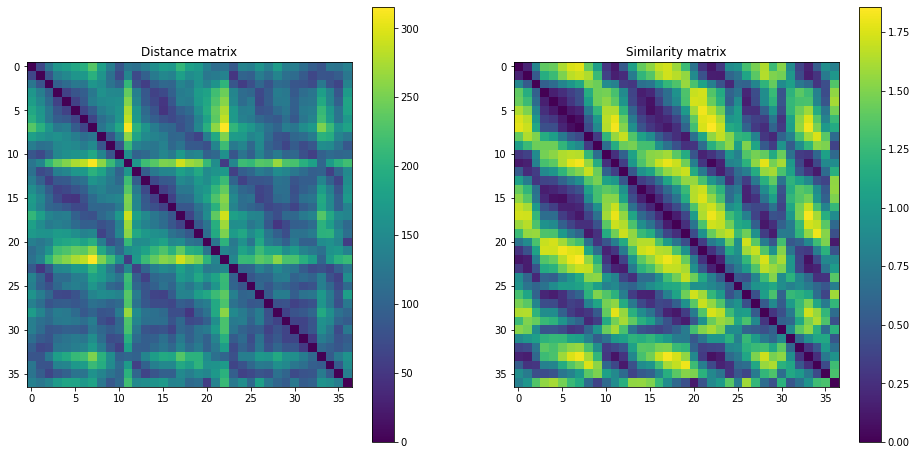

Batch 36/154 (G12 7) with 42 sequences


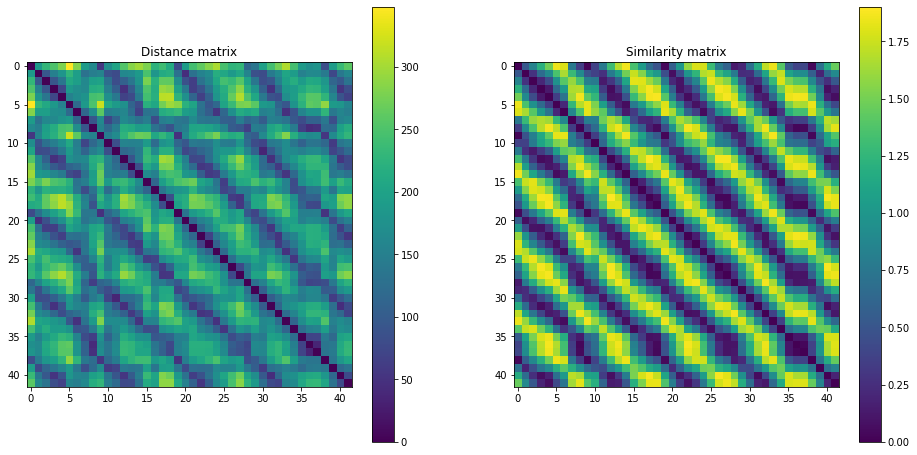

Batch 37/154 (G12 8) with 39 sequences


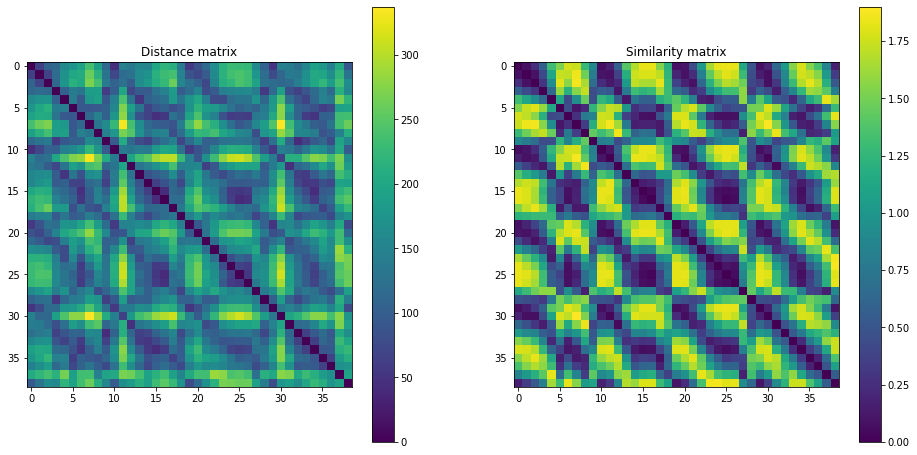

Batch 38/154 (G13 10) with 34 sequences


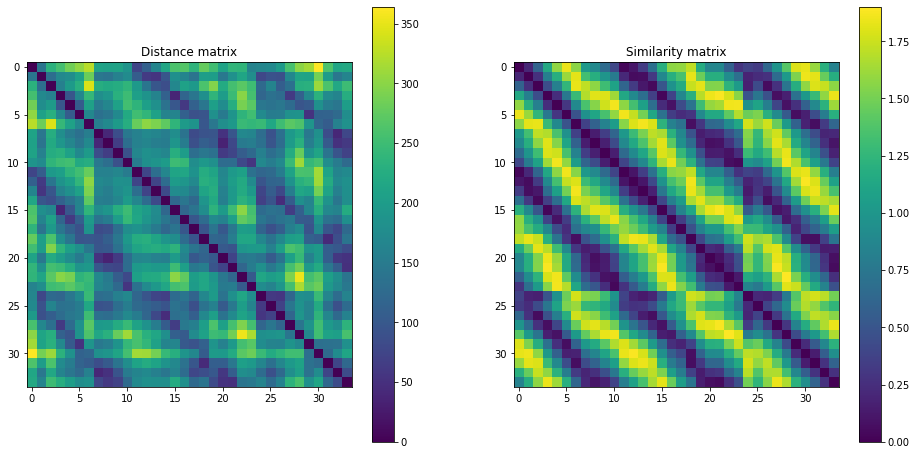

Batch 39/154 (G13 11) with 34 sequences


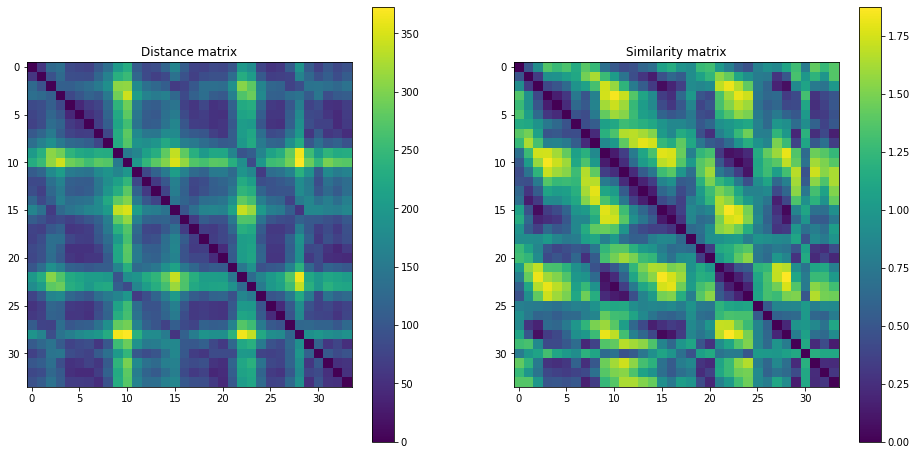

Batch 40/154 (G13 12) with 35 sequences


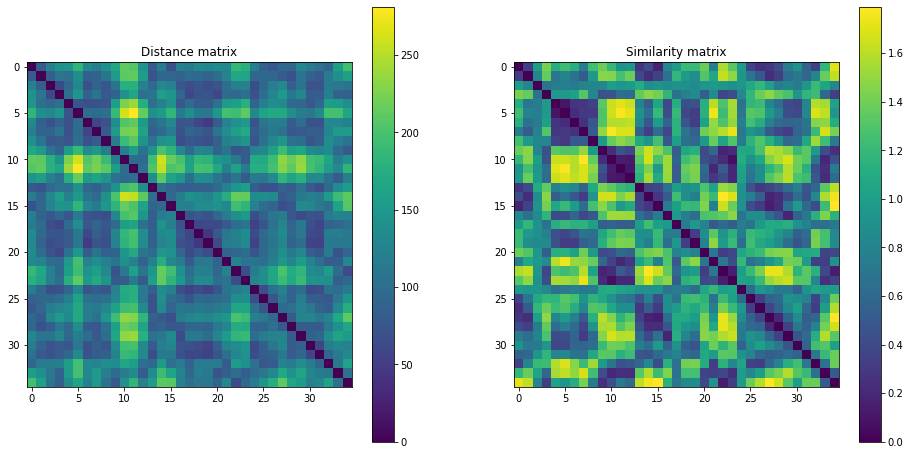

Batch 41/154 (G13 13) with 40 sequences


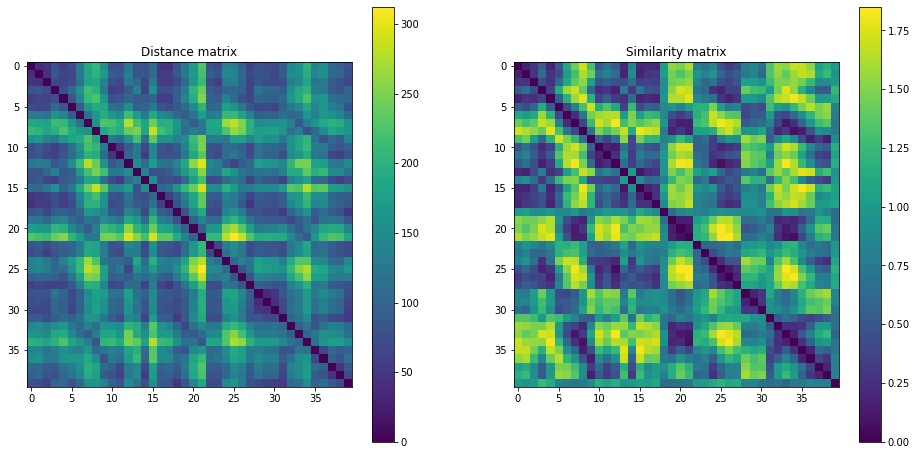

Batch 42/154 (G13 6) with 40 sequences


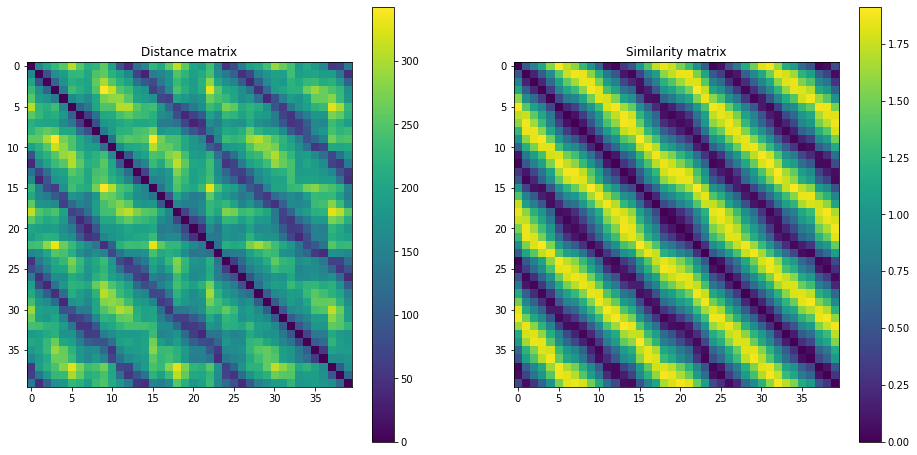

Batch 43/154 (G13 7) with 43 sequences


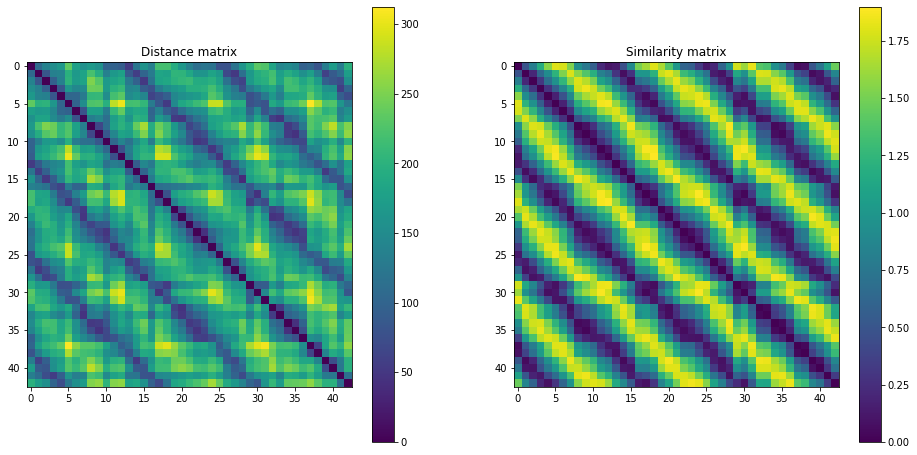

Batch 44/154 (G13 8) with 26 sequences


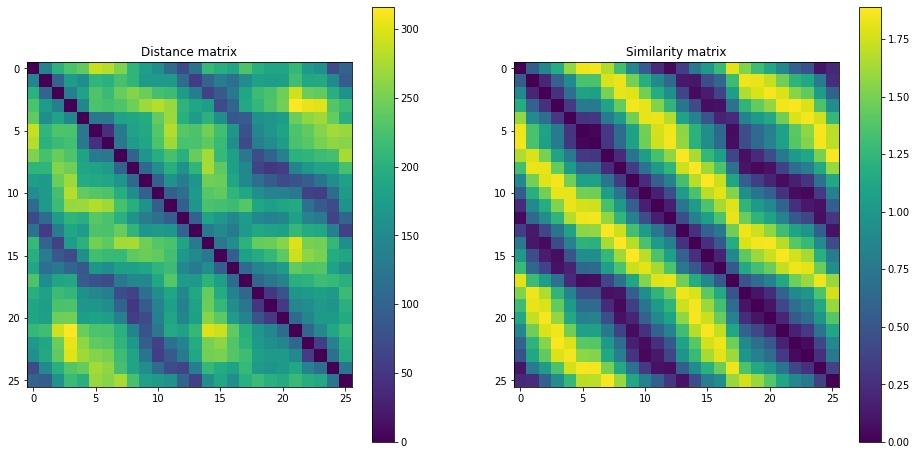

Batch 45/154 (G13 9) with 45 sequences


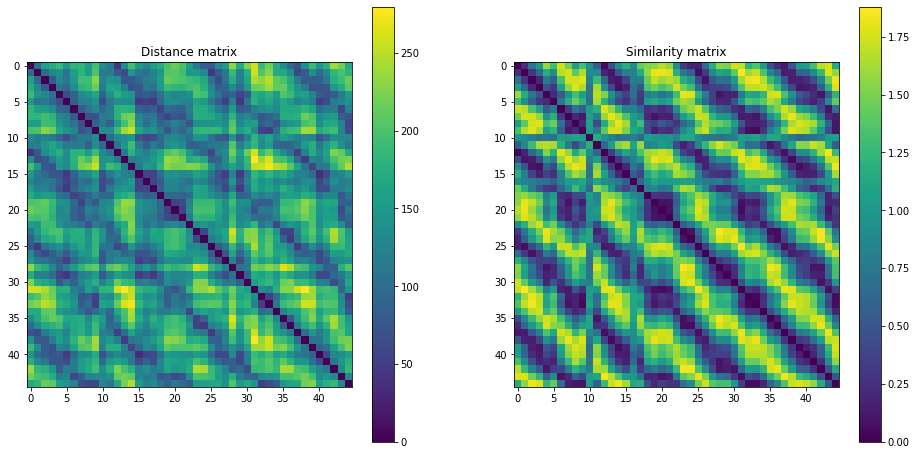

Batch 46/154 (G14 10) with 42 sequences


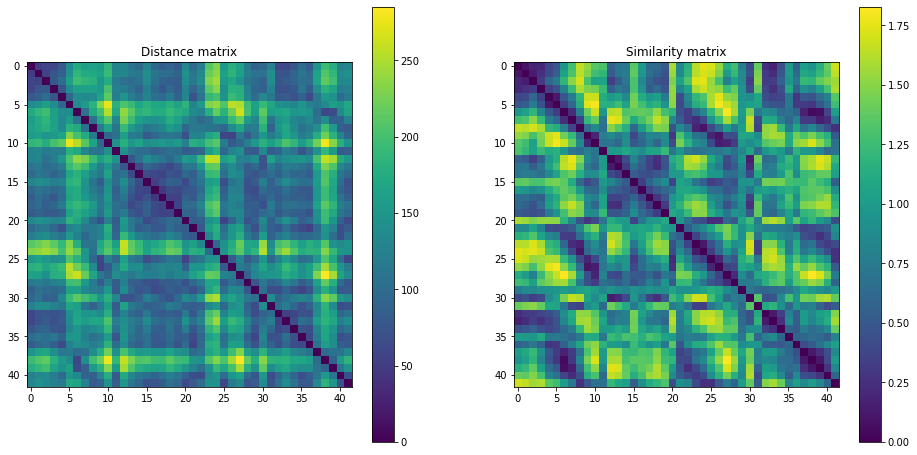

Batch 47/154 (G14 2) with 55 sequences


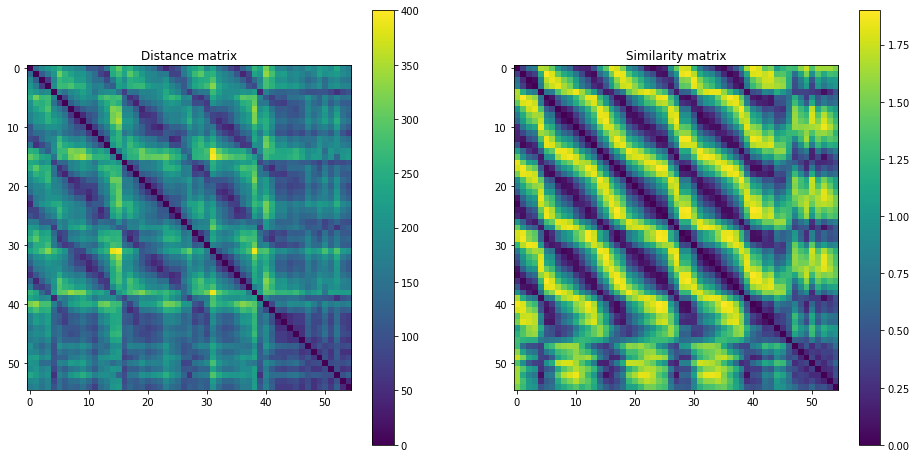

Batch 48/154 (G14 6) with 37 sequences


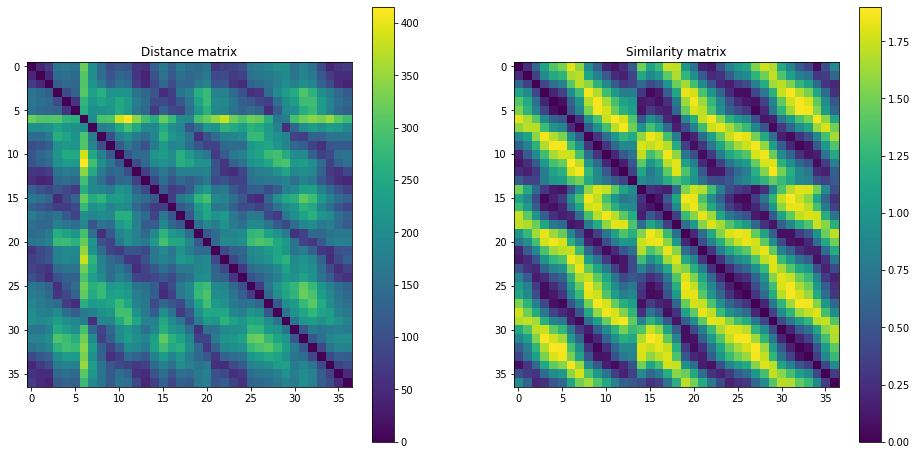

Batch 49/154 (G14 8) with 50 sequences


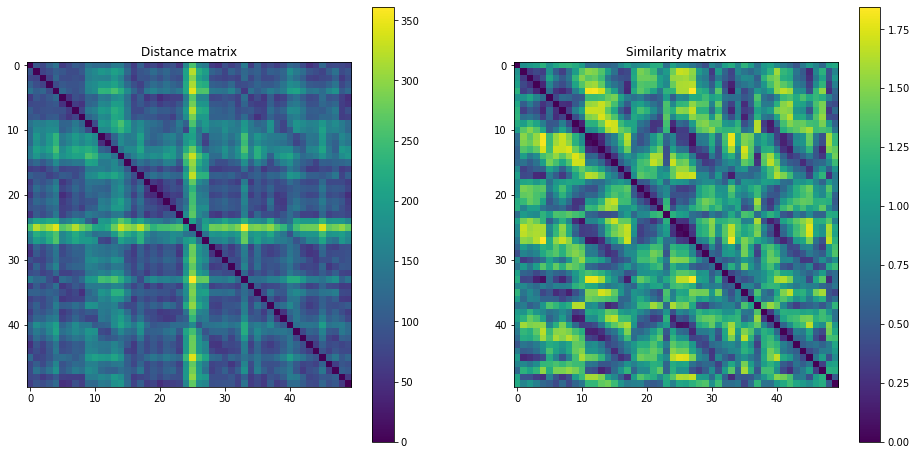

Batch 50/154 (G15 2) with 58 sequences


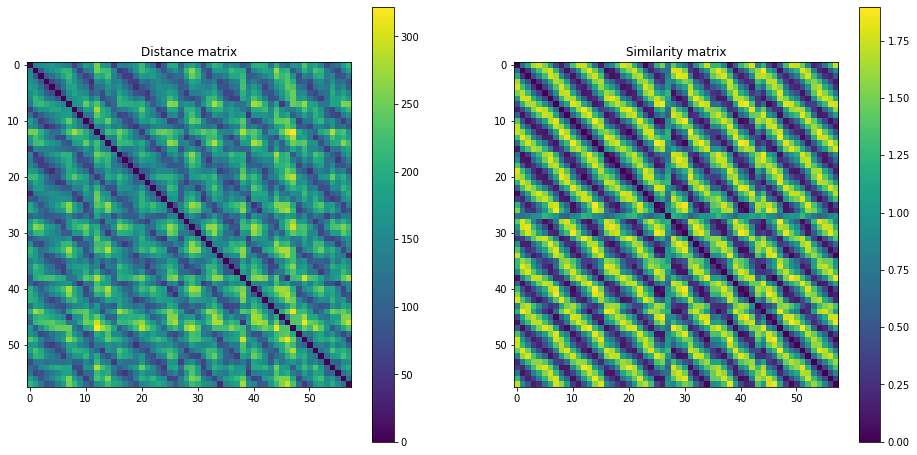

Batch 51/154 (G15 3) with 47 sequences


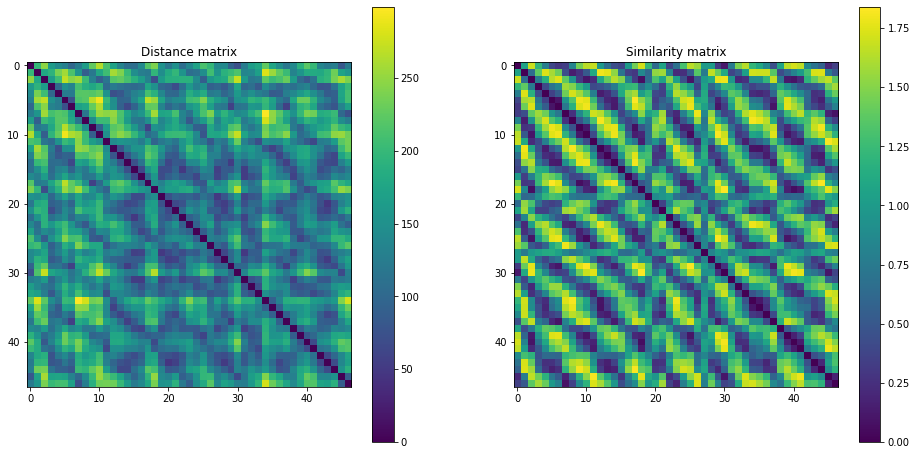

Batch 52/154 (G15 4) with 30 sequences


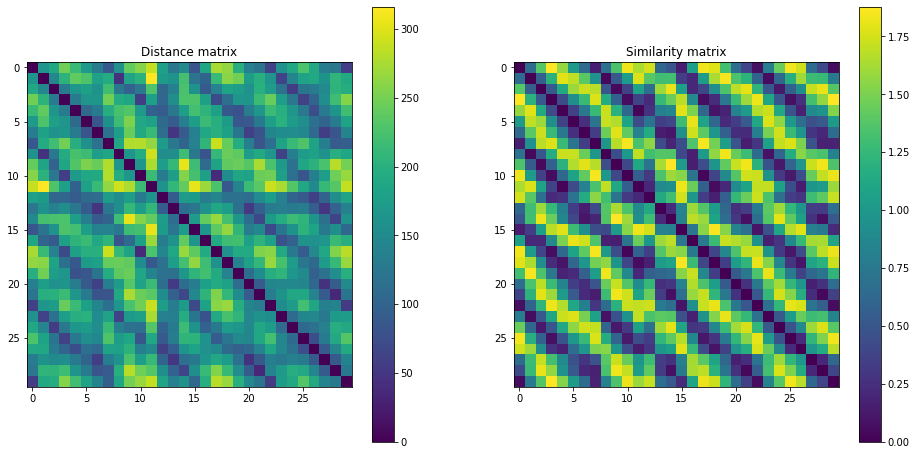

Batch 53/154 (G15 5) with 27 sequences


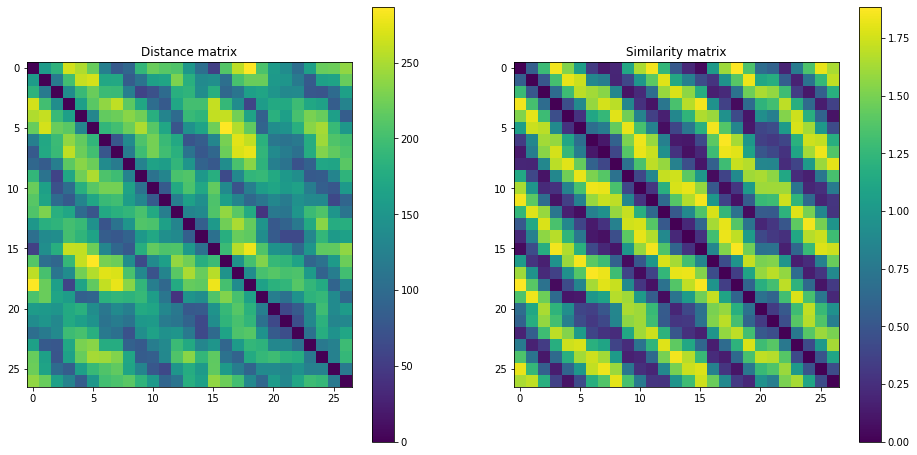

Batch 54/154 (G15 6) with 32 sequences


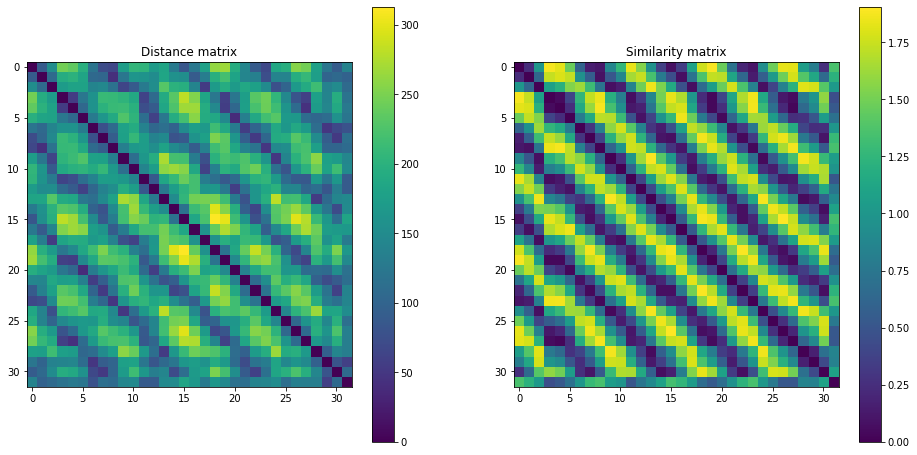

Batch 55/154 (G15 9) with 21 sequences


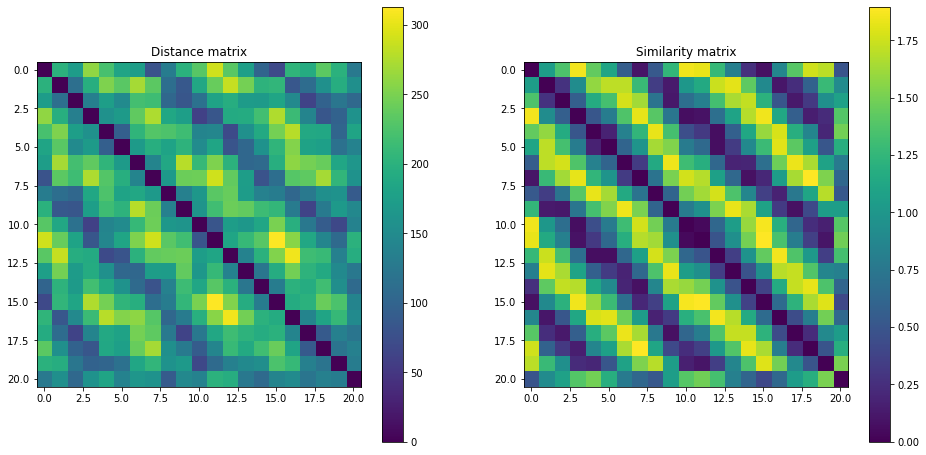

Batch 56/154 (G16 10) with 22 sequences


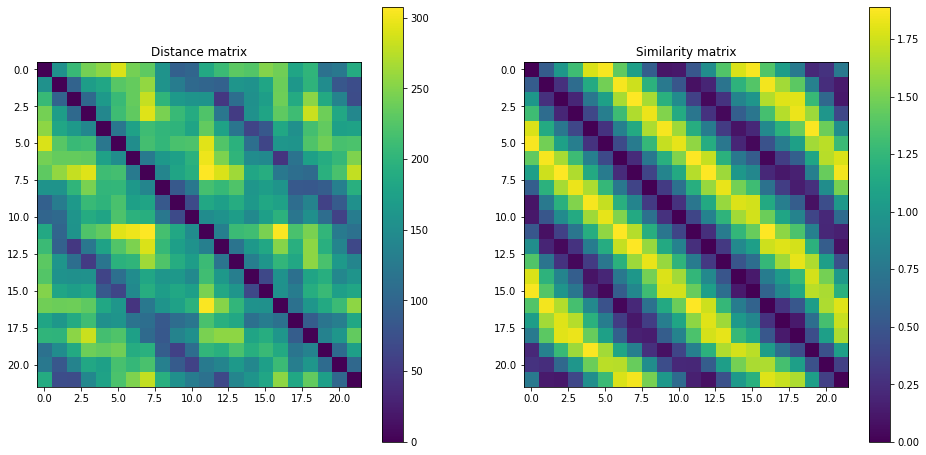

Batch 57/154 (G16 11) with 46 sequences


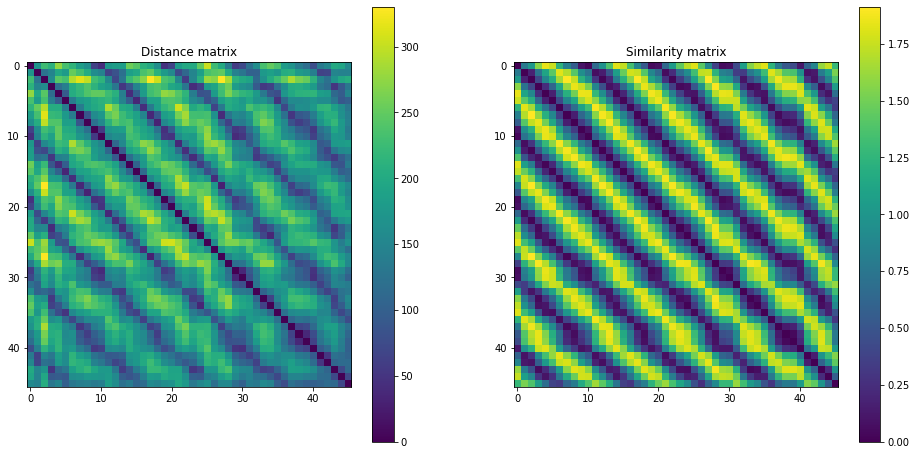

Batch 58/154 (G16 12) with 34 sequences


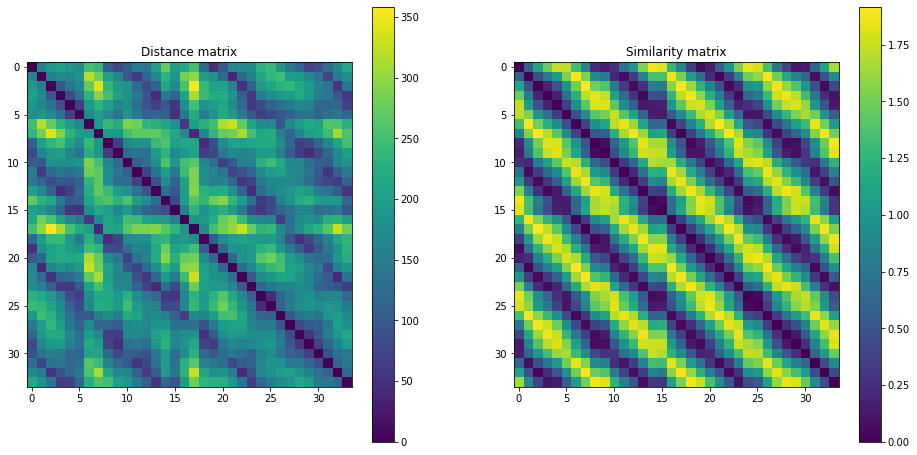

Batch 59/154 (G16 13) with 41 sequences


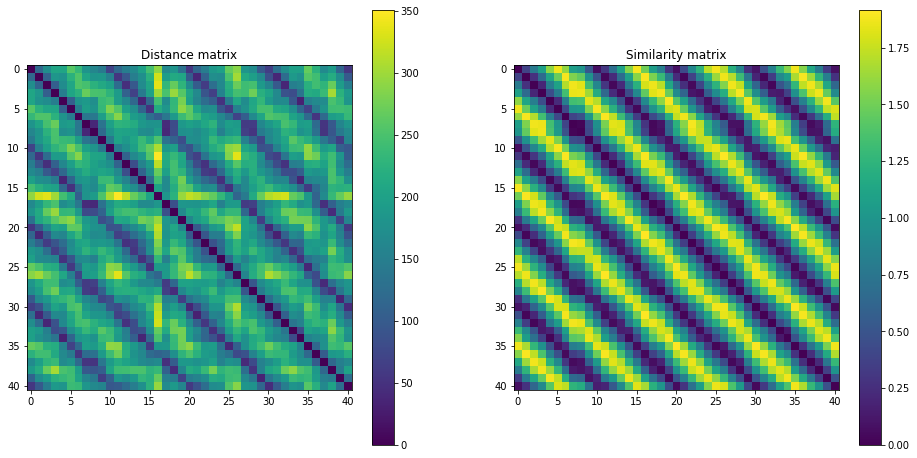

Batch 60/154 (G16 4) with 27 sequences


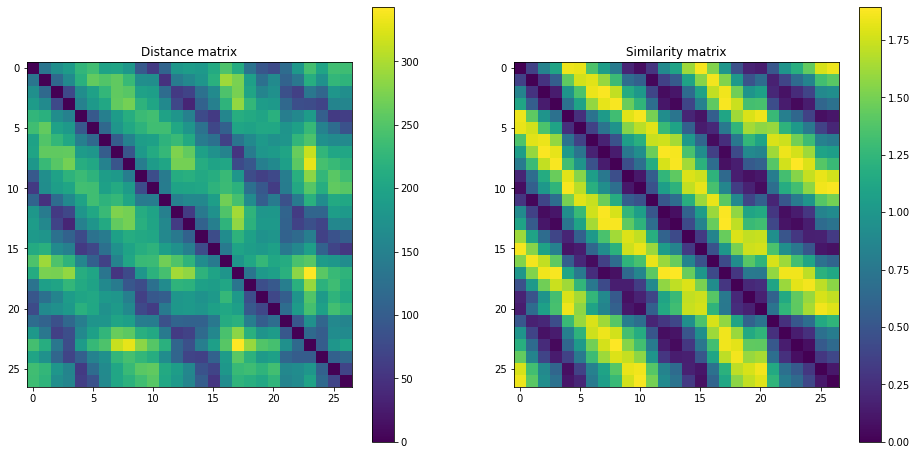

Batch 61/154 (G16 5) with 28 sequences


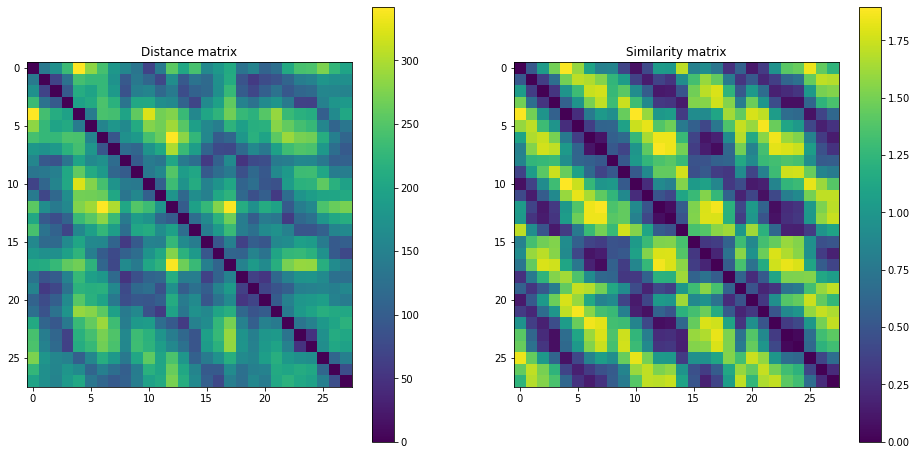

Batch 62/154 (G16 6) with 25 sequences


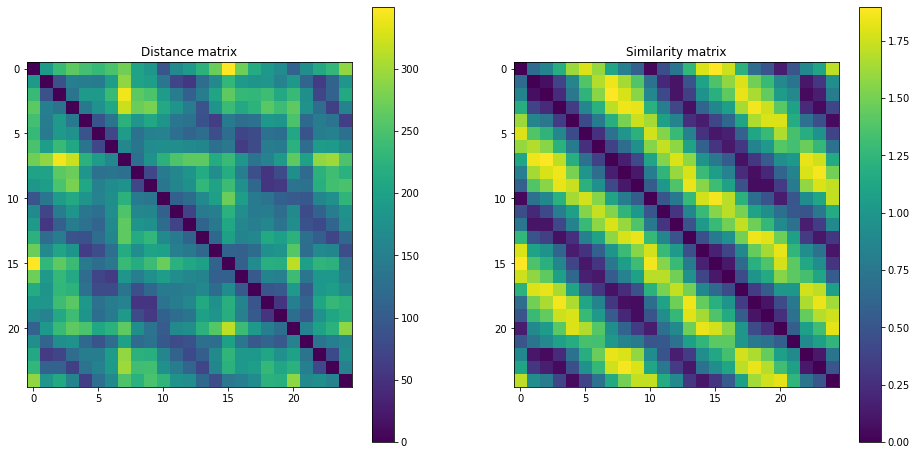

Batch 63/154 (G16 7) with 28 sequences


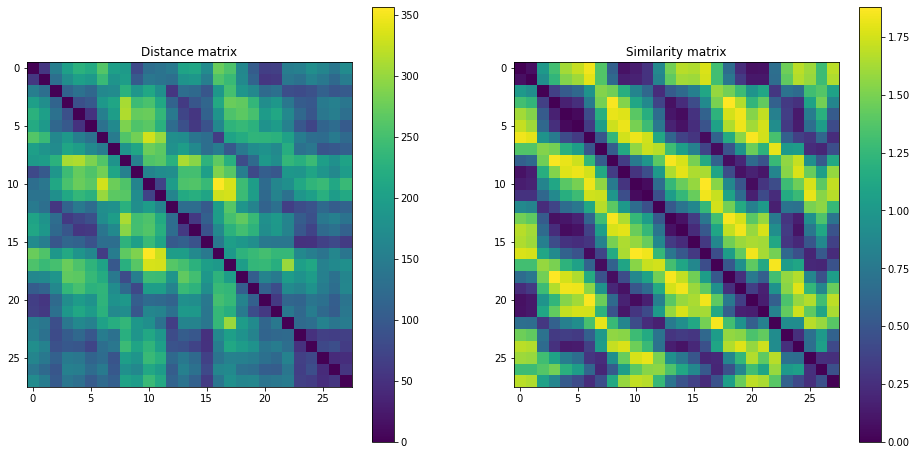

Batch 64/154 (G16 8) with 28 sequences


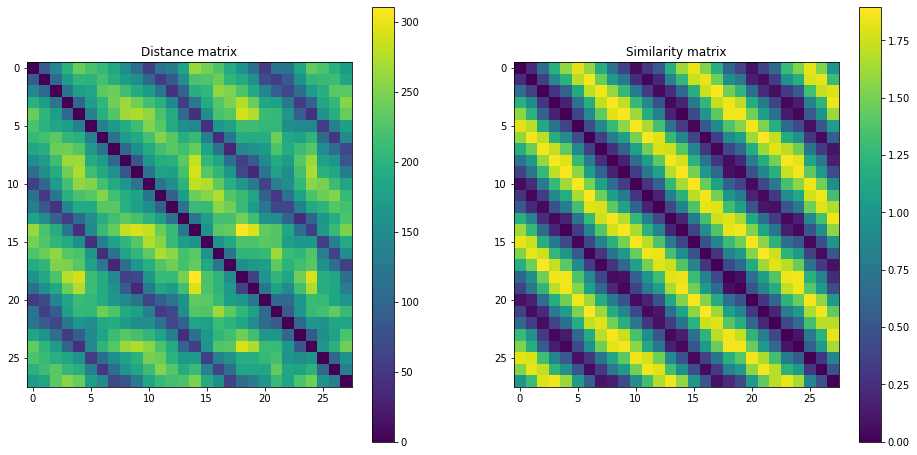

Batch 65/154 (G16 9) with 41 sequences


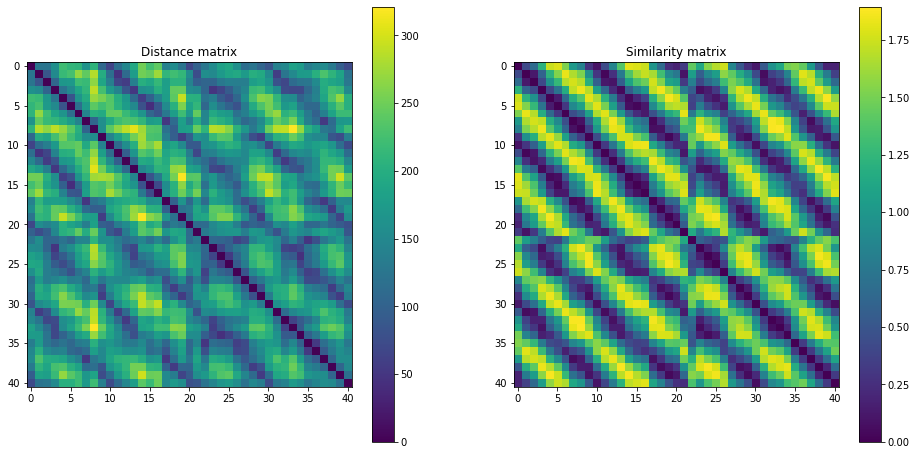

Batch 66/154 (G17 11) with 48 sequences


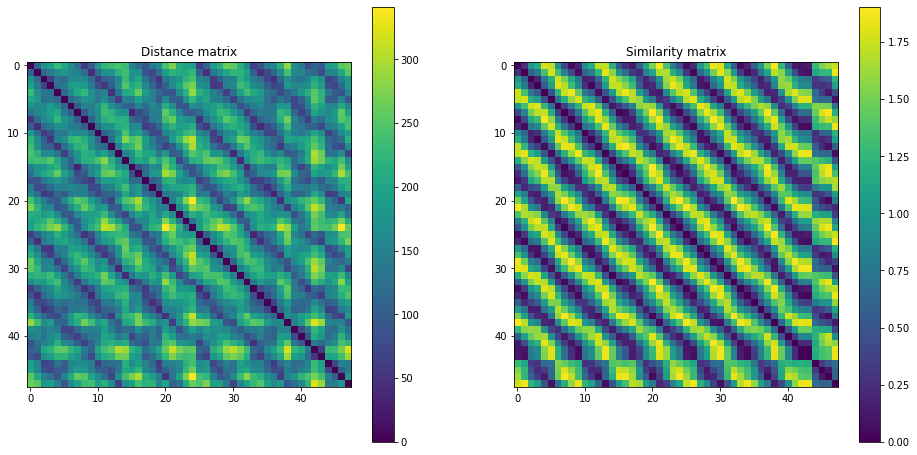

Batch 67/154 (G17 12) with 38 sequences


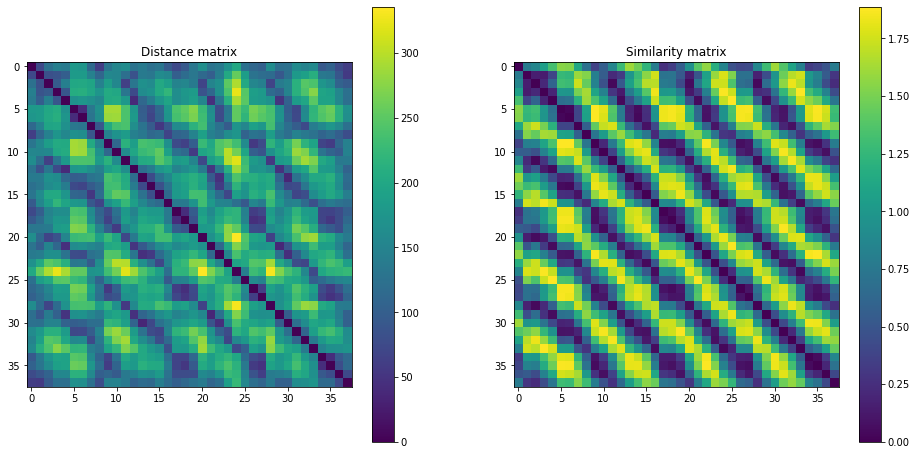

Batch 68/154 (G17 13) with 48 sequences


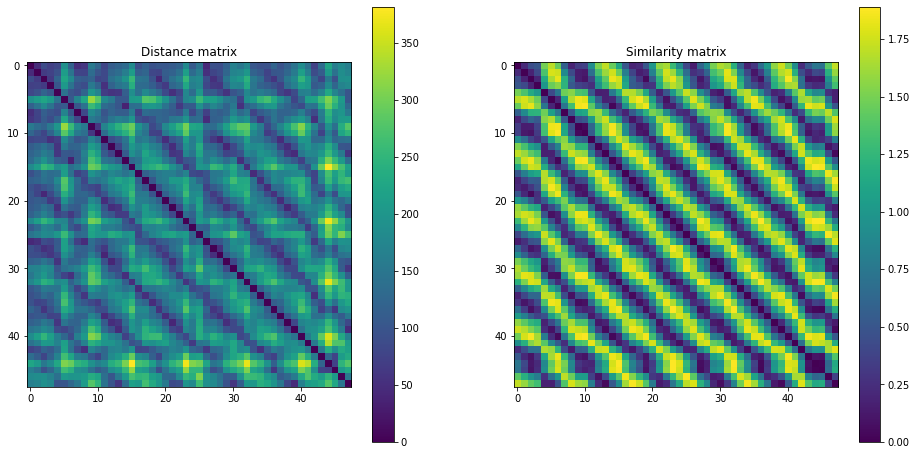

Batch 69/154 (G17 15) with 36 sequences


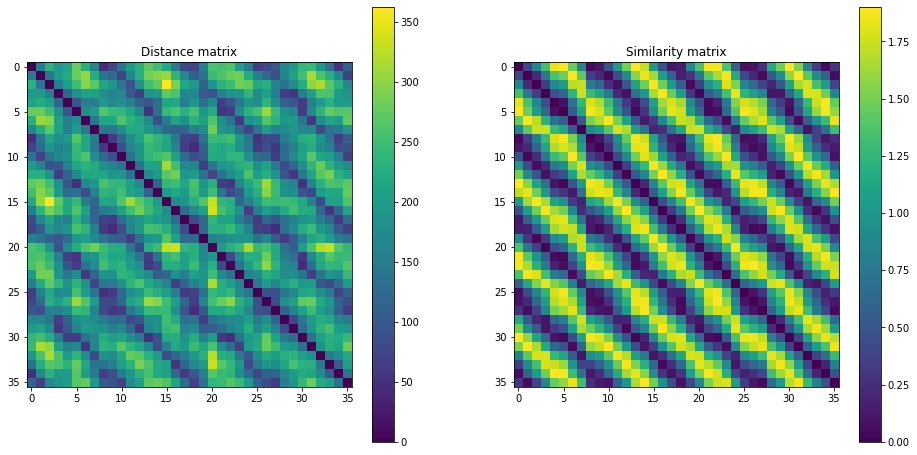

Batch 70/154 (G17 3) with 28 sequences


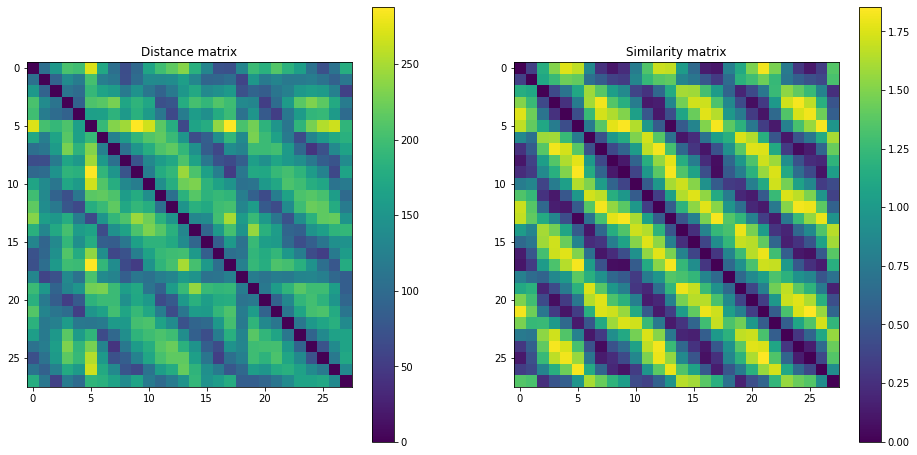

Batch 71/154 (G17 5) with 17 sequences


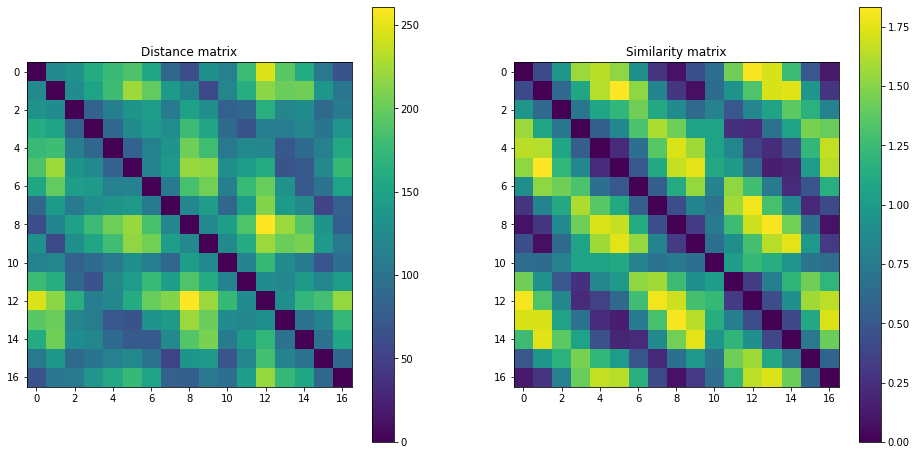

Batch 72/154 (G17 7) with 42 sequences


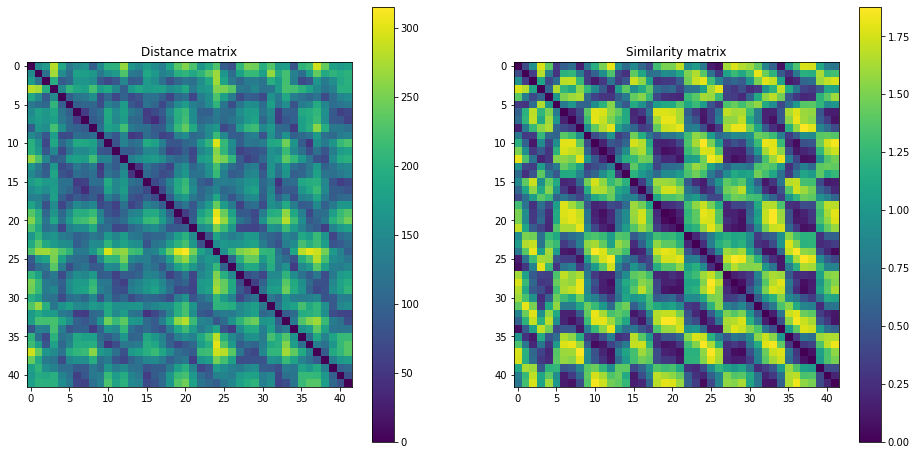

Batch 73/154 (G17 8) with 63 sequences


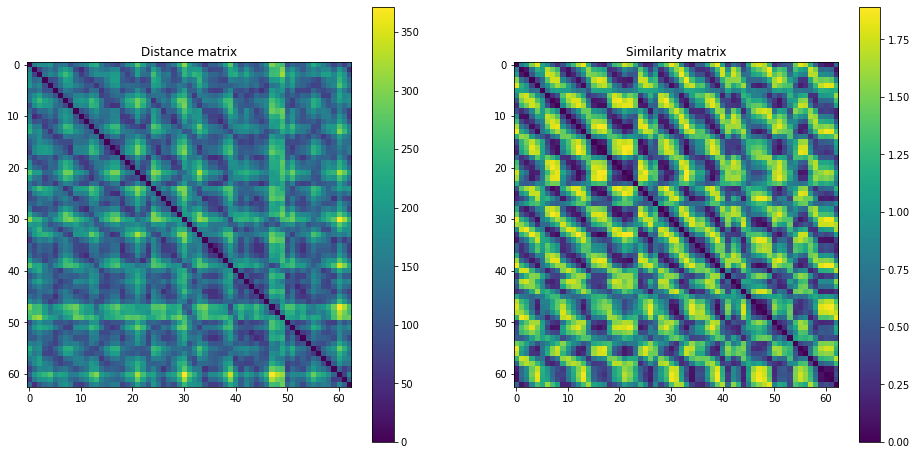

Batch 74/154 (G18 10) with 109 sequences


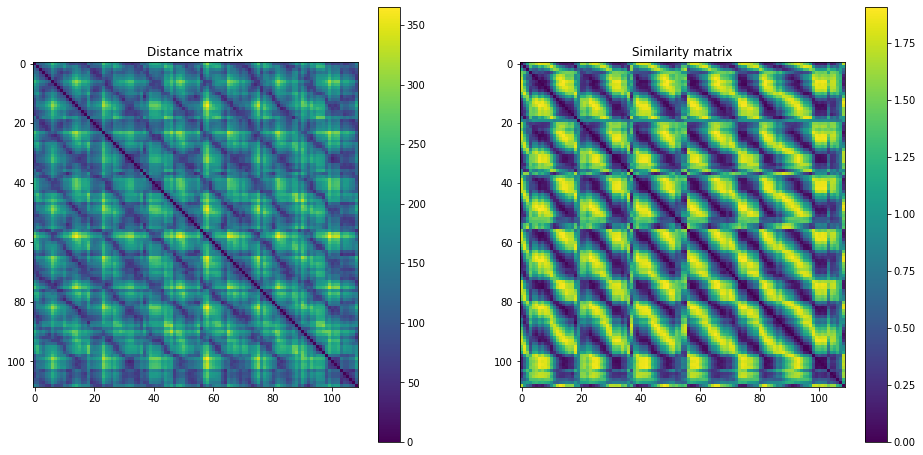

Batch 75/154 (G18 13) with 85 sequences


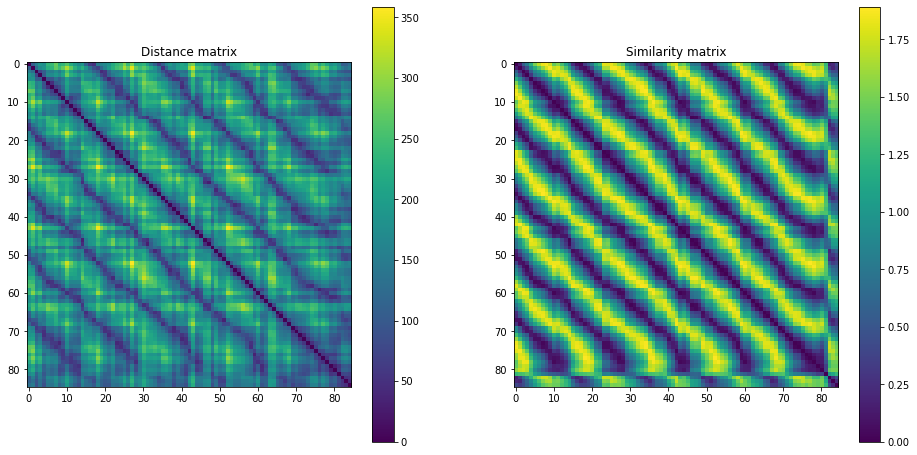

Batch 76/154 (G18 14) with 87 sequences


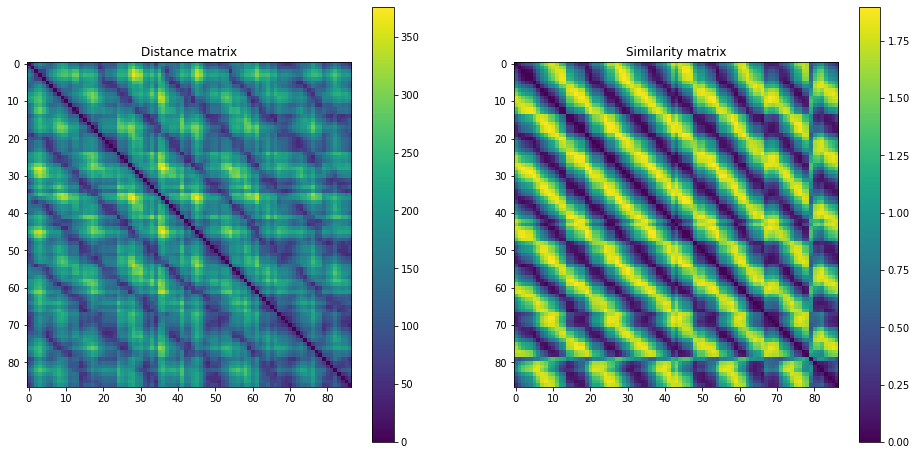

Batch 77/154 (G18 15) with 76 sequences


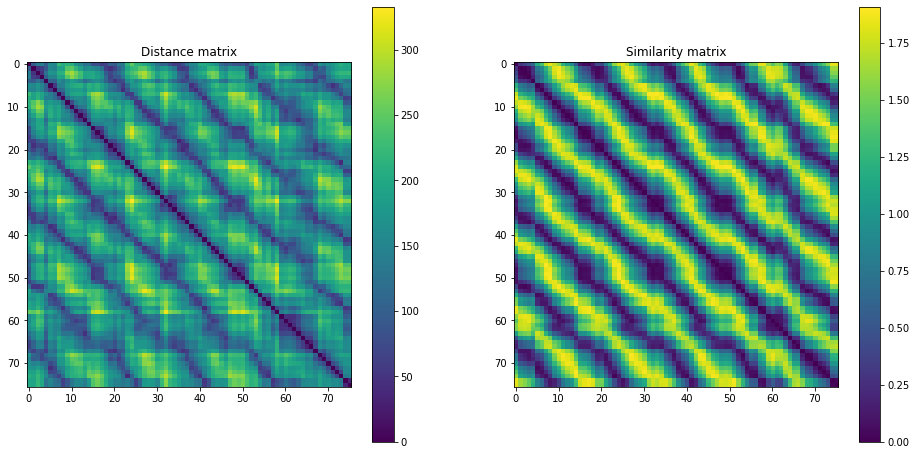

Batch 78/154 (G18 17) with 73 sequences


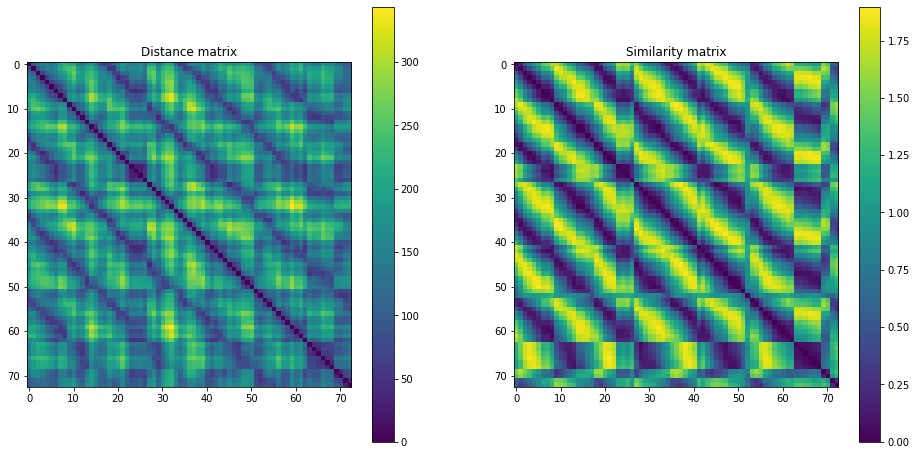

Batch 79/154 (G18 18) with 73 sequences


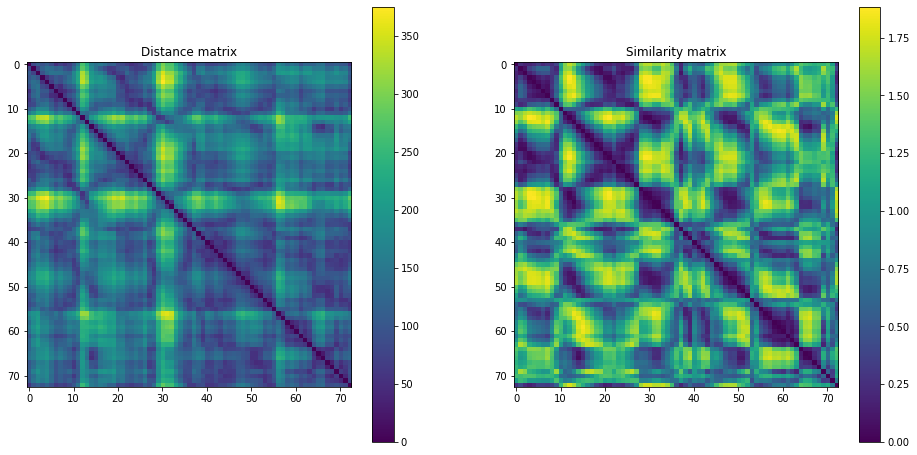

Batch 80/154 (G18 19) with 70 sequences


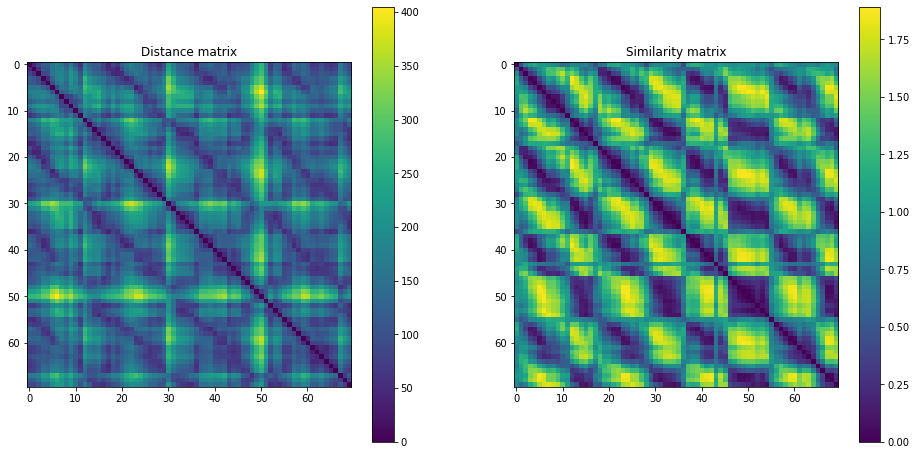

Batch 81/154 (G18 20) with 94 sequences


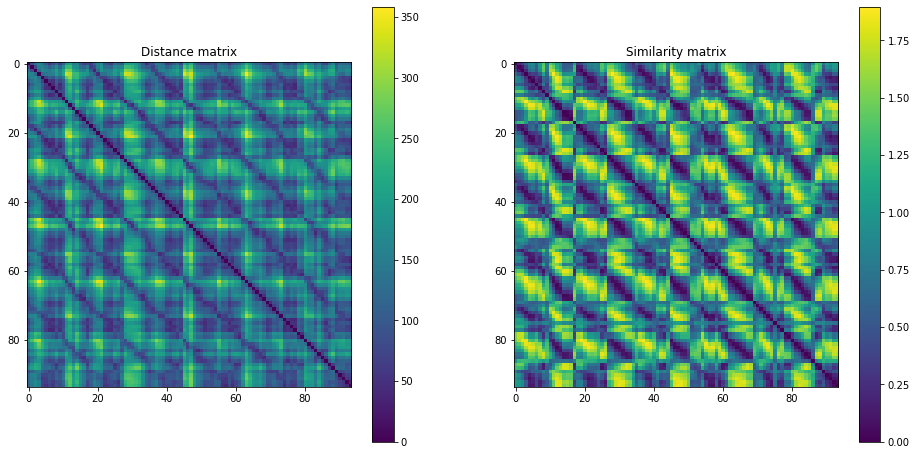

Batch 82/154 (G18 9) with 109 sequences


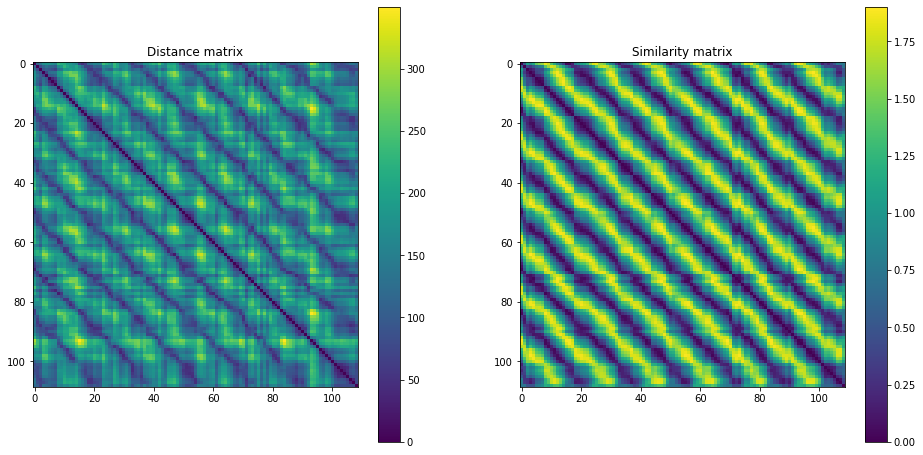

Batch 83/154 (G2 10) with 47 sequences


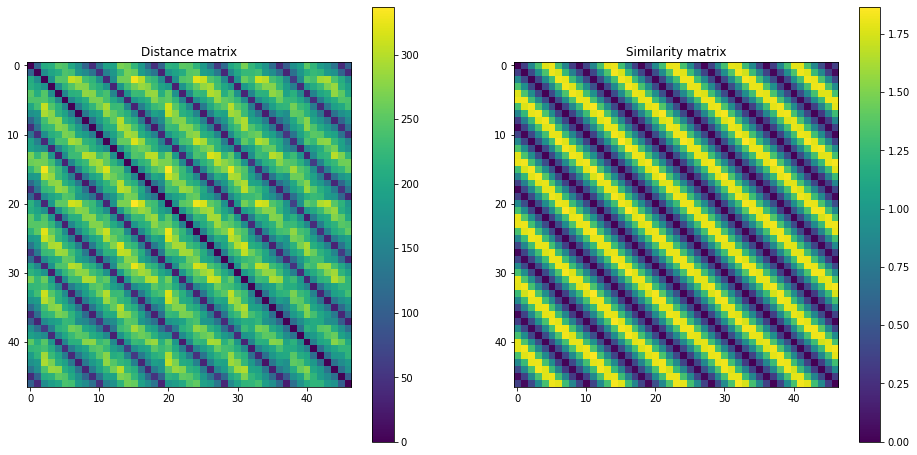

Batch 84/154 (G2 11) with 53 sequences


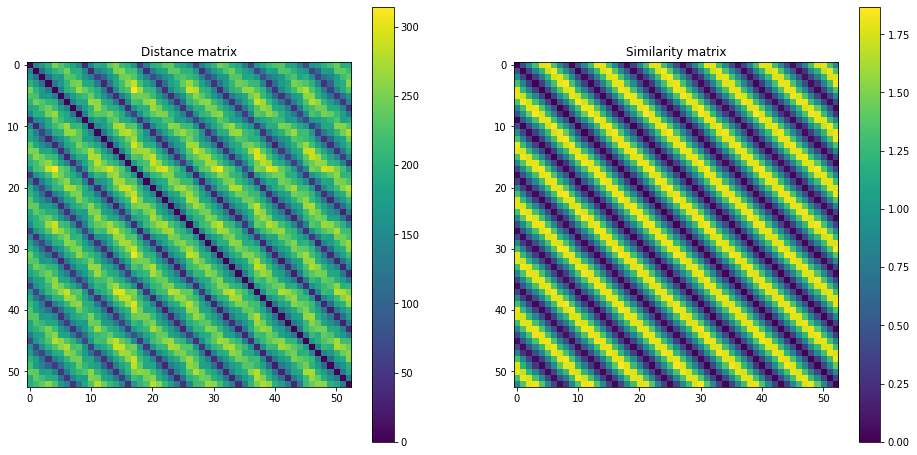

Batch 85/154 (G2 7) with 49 sequences


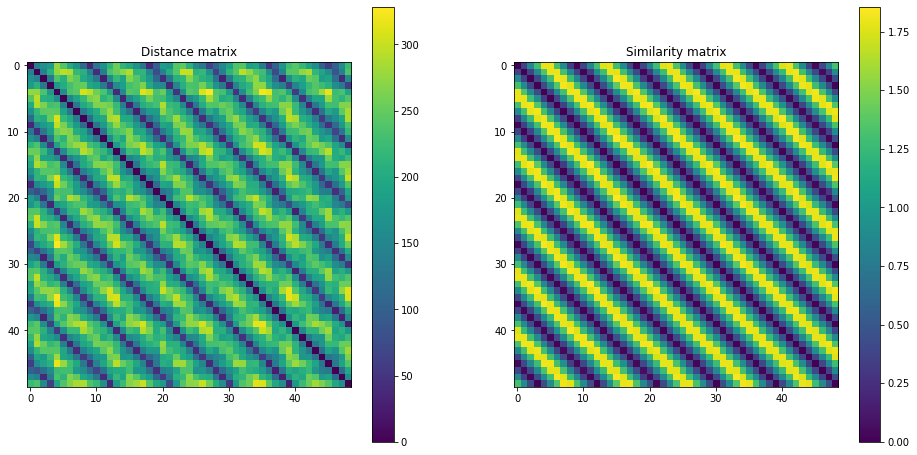

Batch 86/154 (G2 8) with 48 sequences


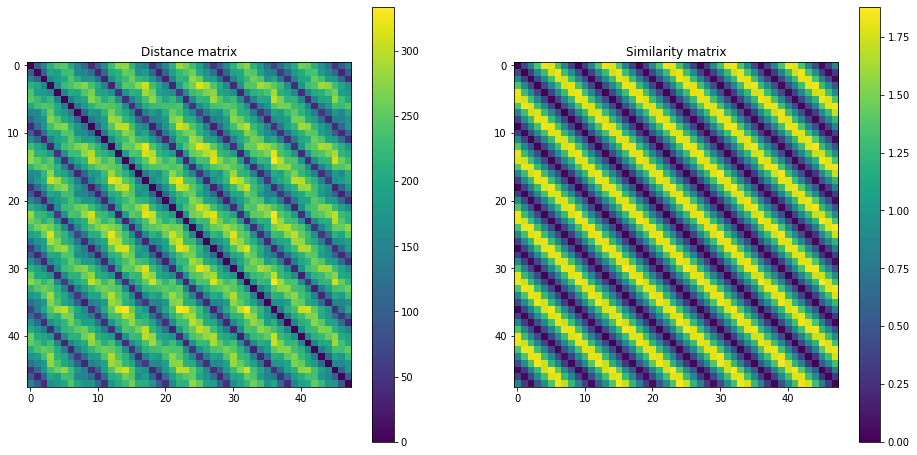

Batch 87/154 (G2 9) with 51 sequences


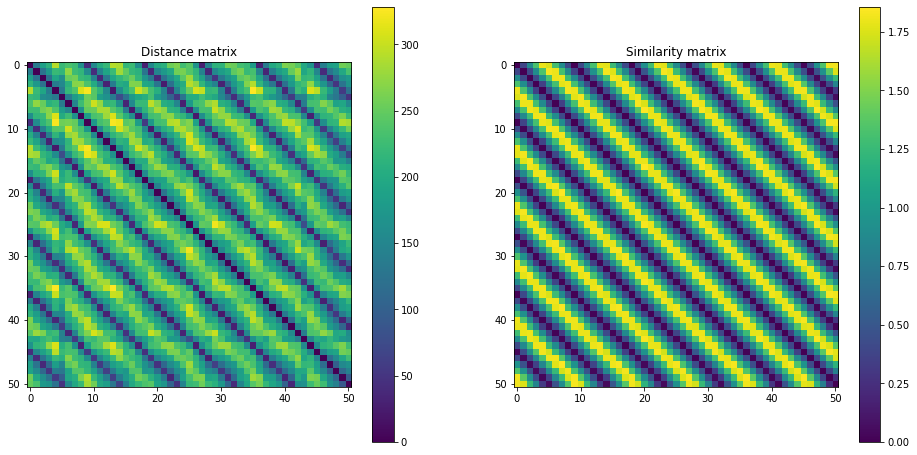

Batch 88/154 (G3 3) with 40 sequences


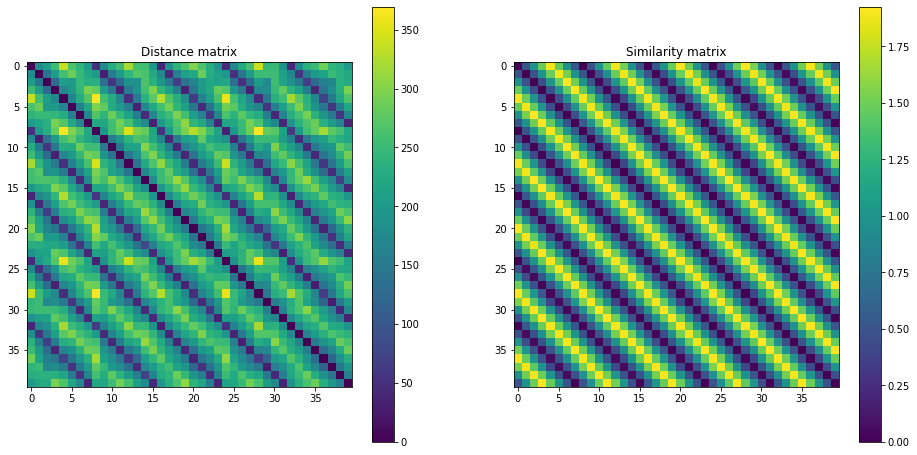

Batch 89/154 (G3 4) with 32 sequences


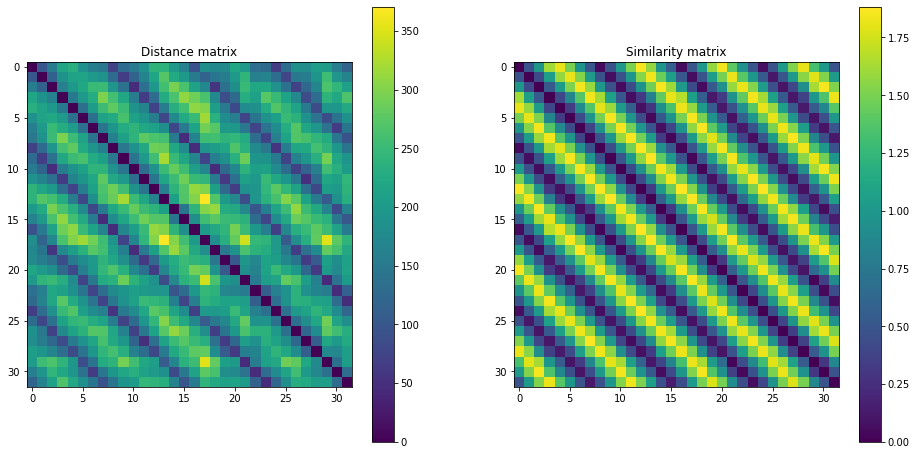

Batch 90/154 (G3 5) with 31 sequences


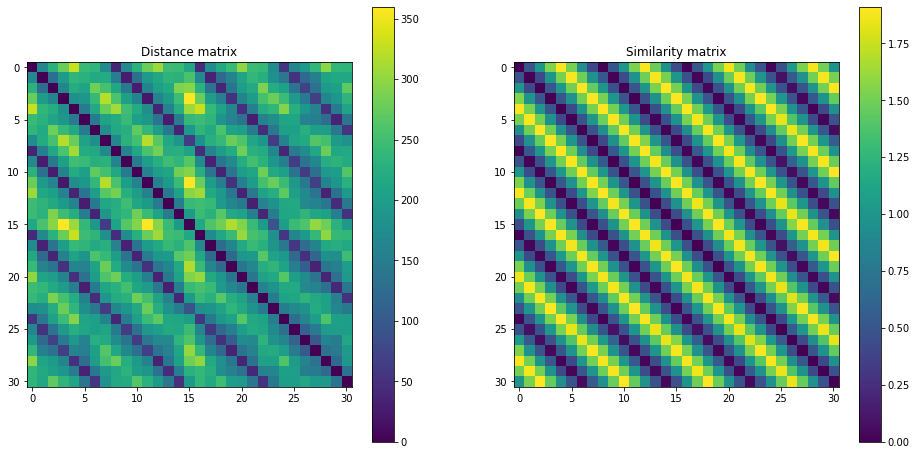

Batch 91/154 (G3 6) with 27 sequences


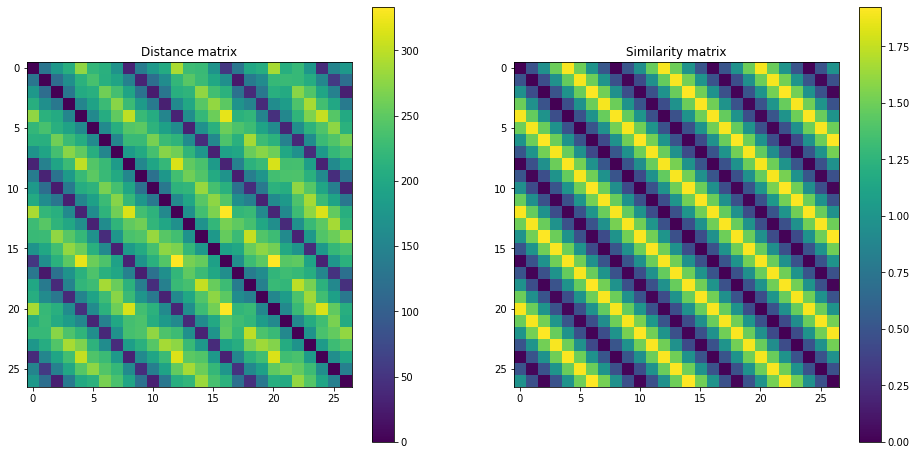

Batch 92/154 (G3 7) with 29 sequences


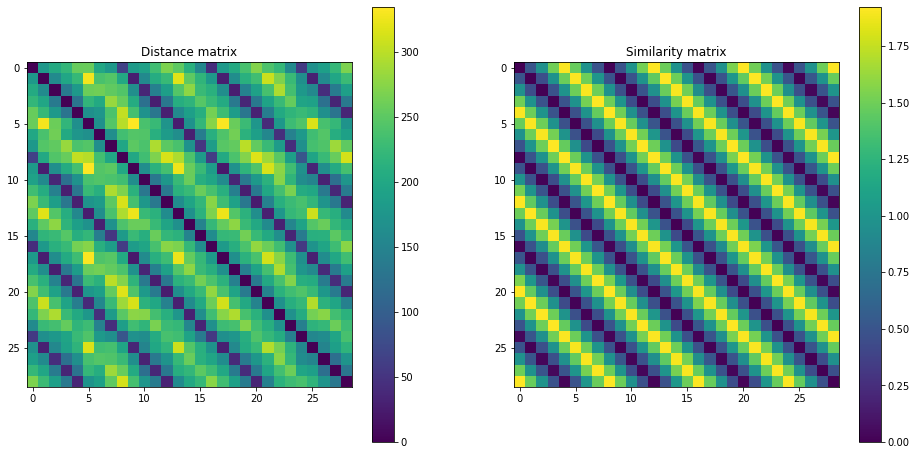

Batch 93/154 (G3 8) with 31 sequences


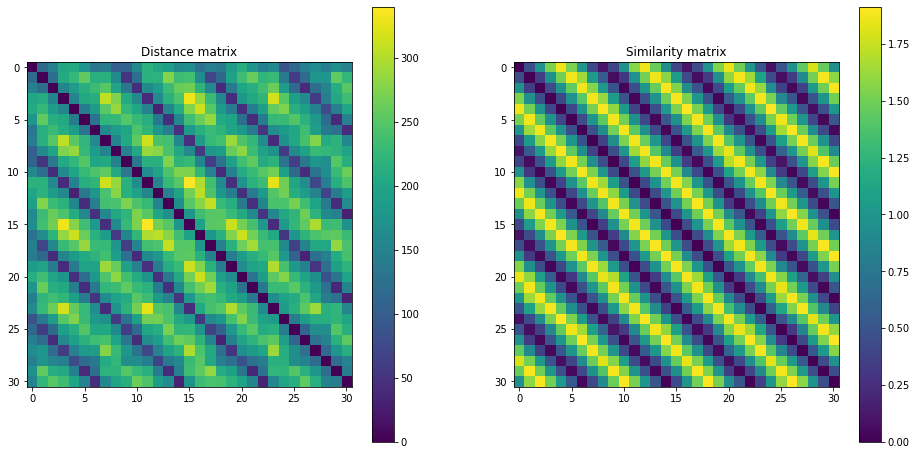

Batch 94/154 (G3 9) with 38 sequences


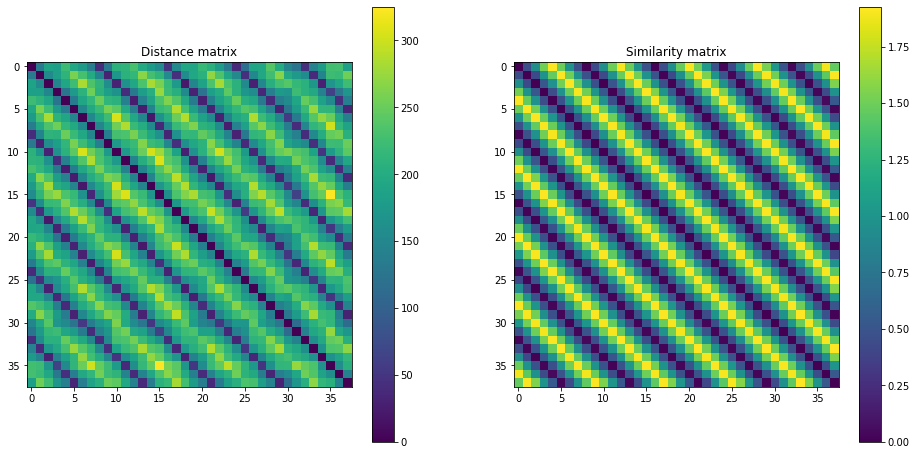

Batch 95/154 (G5 2) with 35 sequences


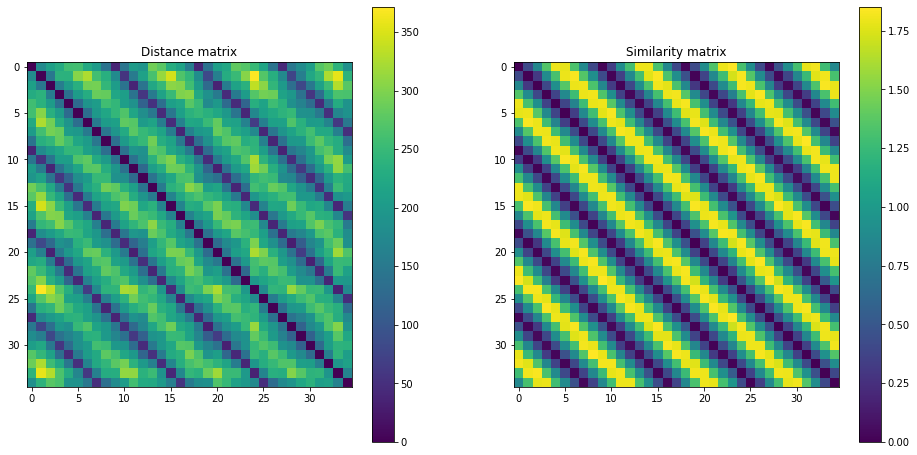

Batch 96/154 (G5 3) with 29 sequences


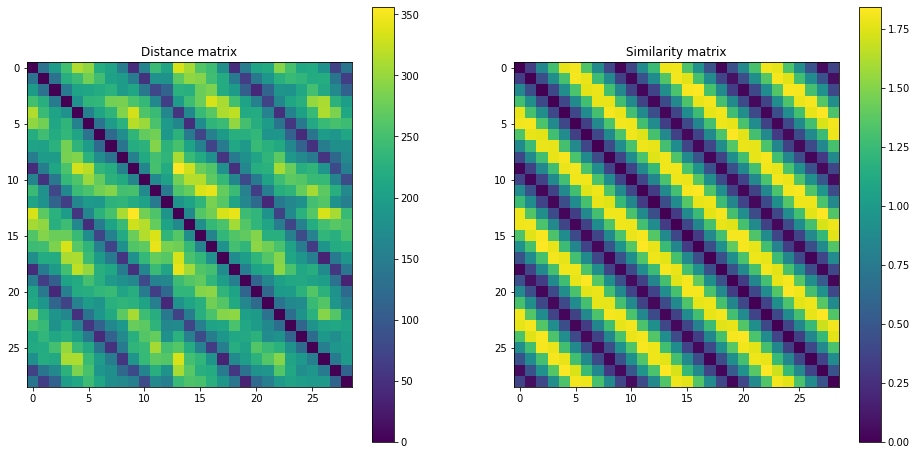

Batch 97/154 (G5 4) with 27 sequences


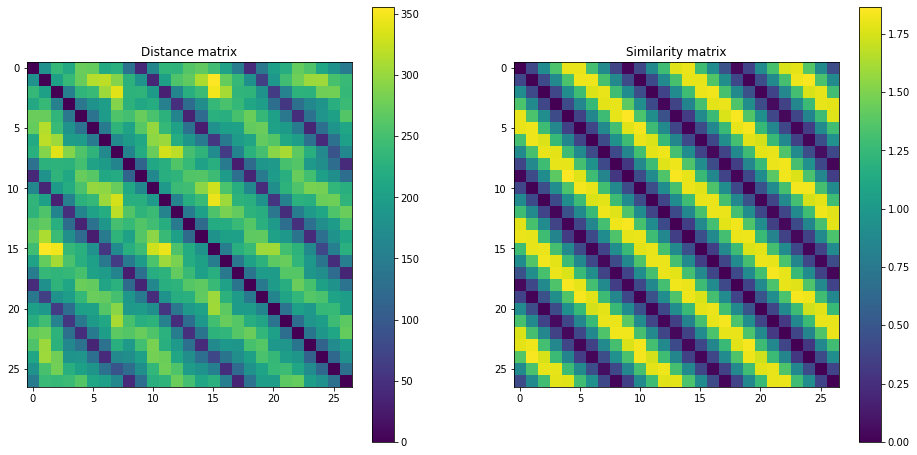

Batch 98/154 (G5 5) with 45 sequences


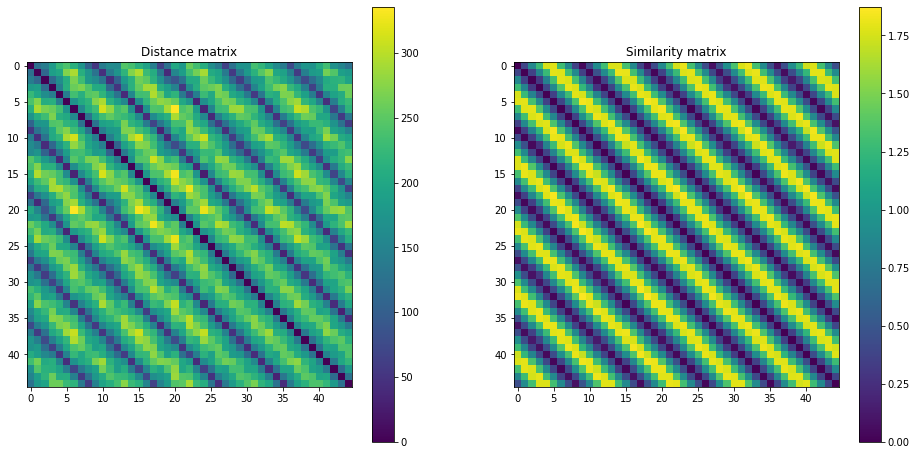

Batch 99/154 (G5 6) with 49 sequences


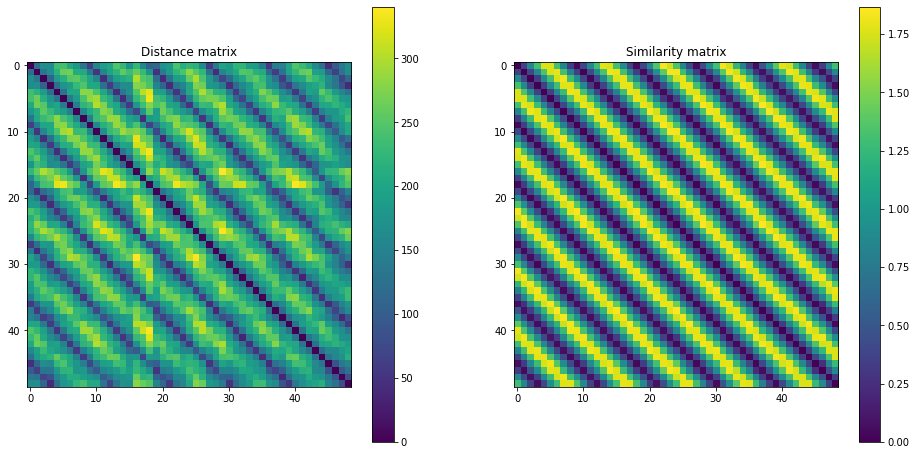

Batch 100/154 (G5 7) with 39 sequences


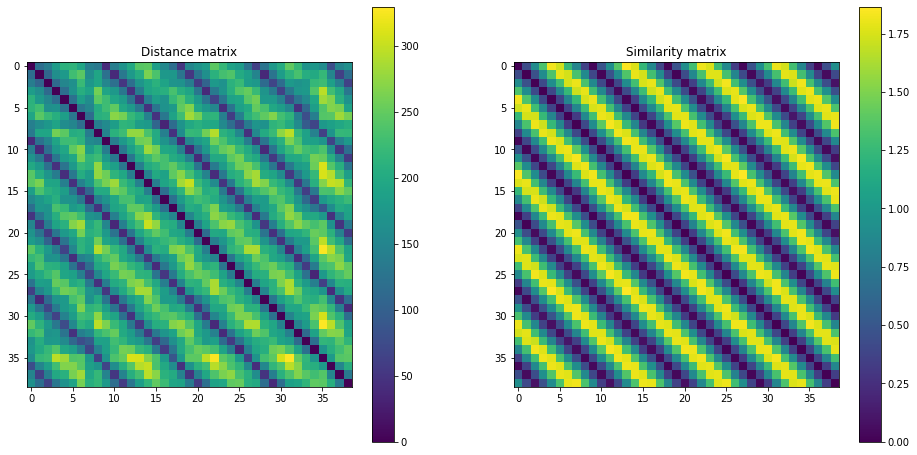

Batch 101/154 (G5 8) with 49 sequences


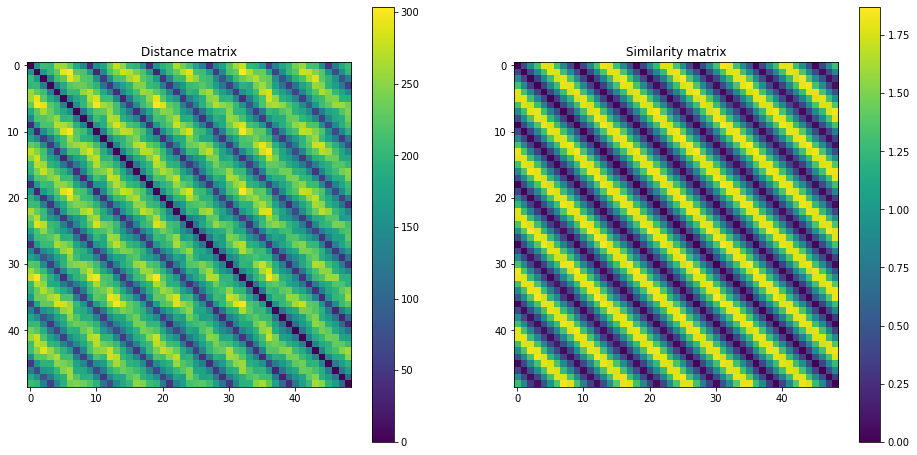

Batch 102/154 (G5 9) with 50 sequences


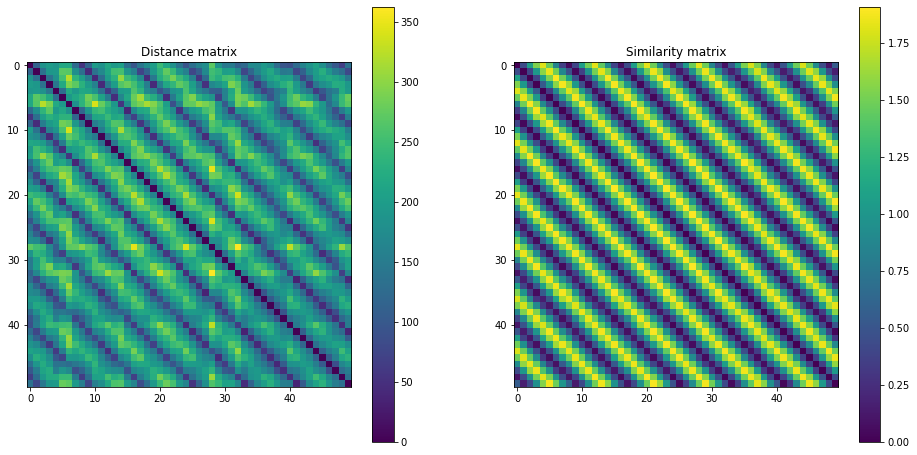

Batch 103/154 (G6 3) with 40 sequences


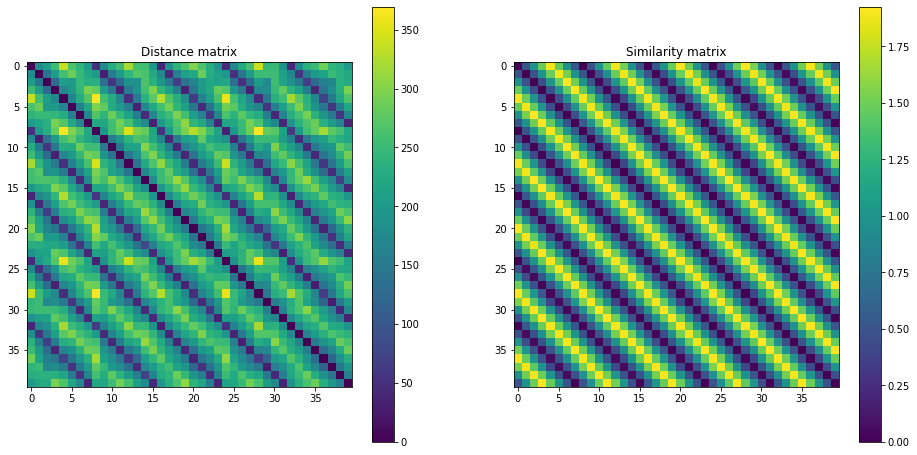

Batch 104/154 (G6 4) with 32 sequences


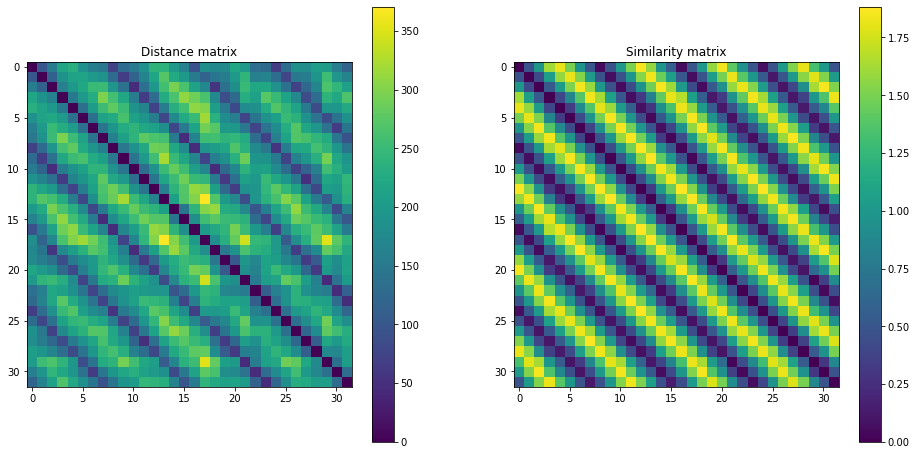

Batch 105/154 (G6 5) with 31 sequences


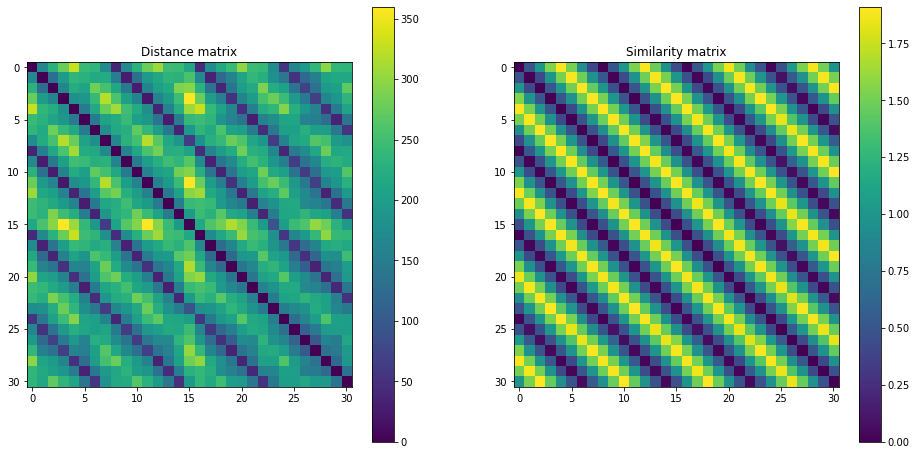

Batch 106/154 (G6 6) with 27 sequences


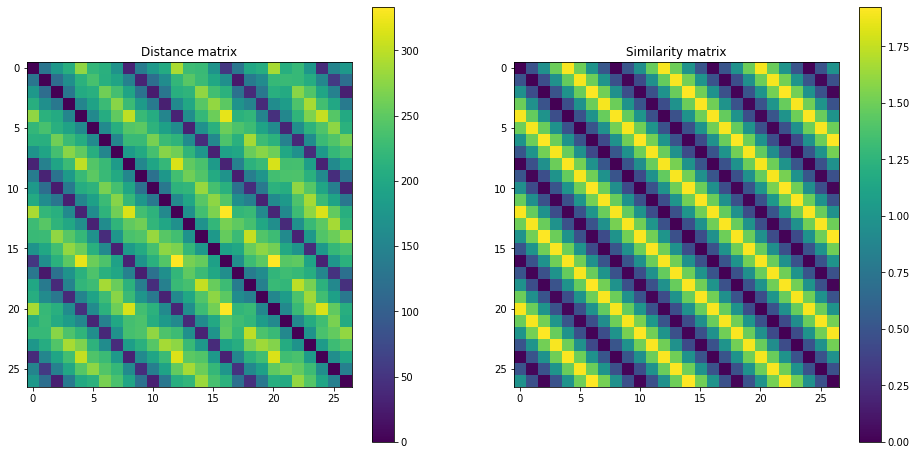

Batch 107/154 (G6 7) with 29 sequences


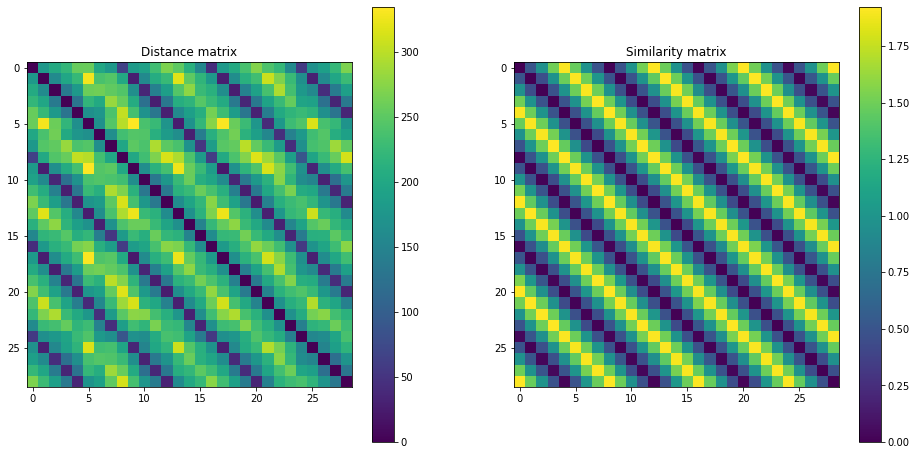

Batch 108/154 (G6 8) with 31 sequences


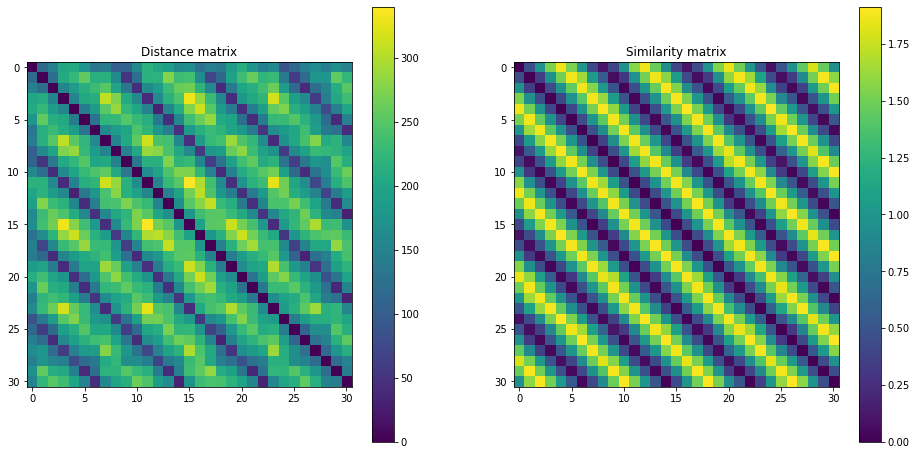

Batch 109/154 (G6 9) with 38 sequences


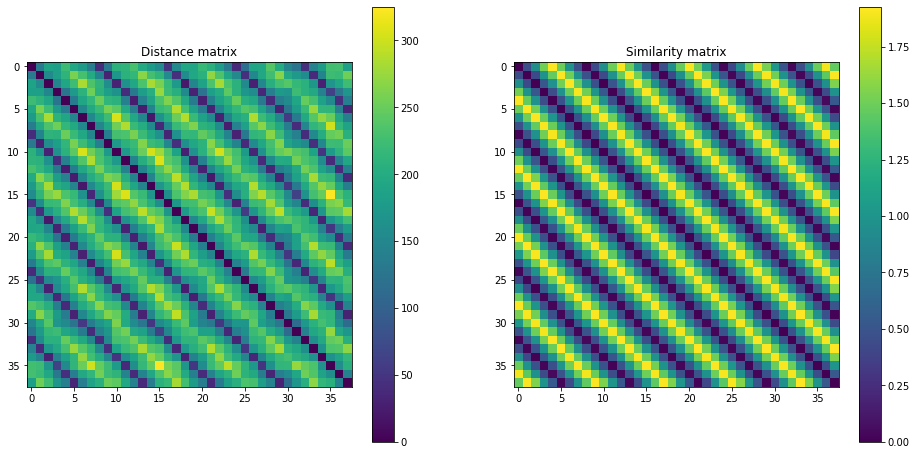

Batch 110/154 (G8 10) with 88 sequences


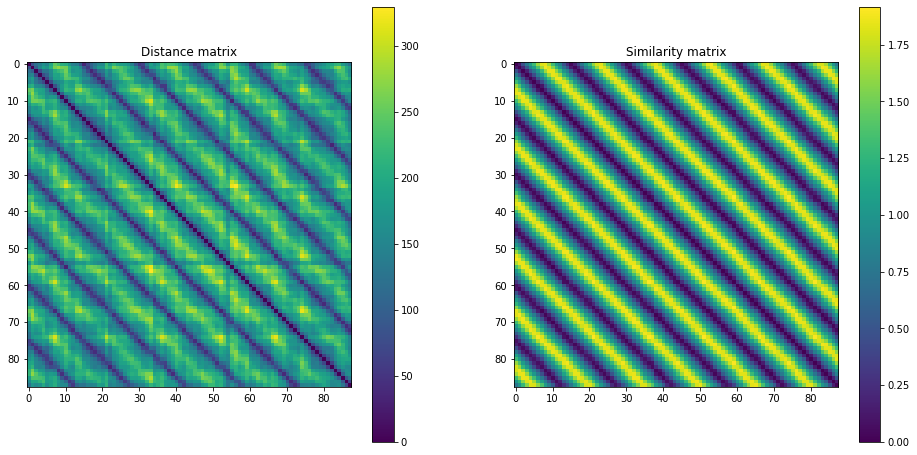

Batch 111/154 (G8 11) with 75 sequences


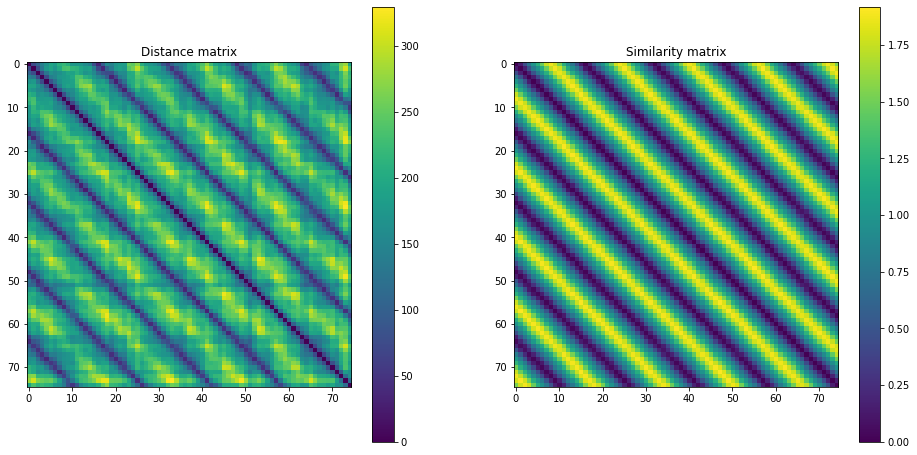

Batch 112/154 (G8 12) with 71 sequences


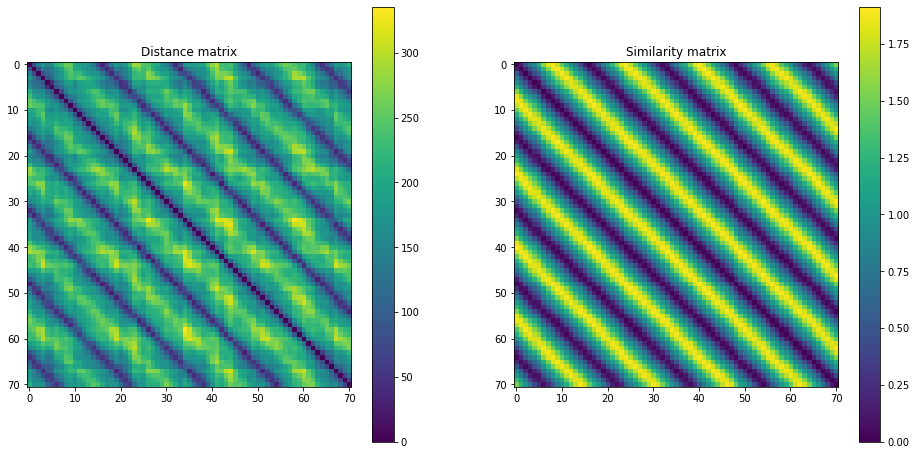

Batch 113/154 (G8 6) with 117 sequences


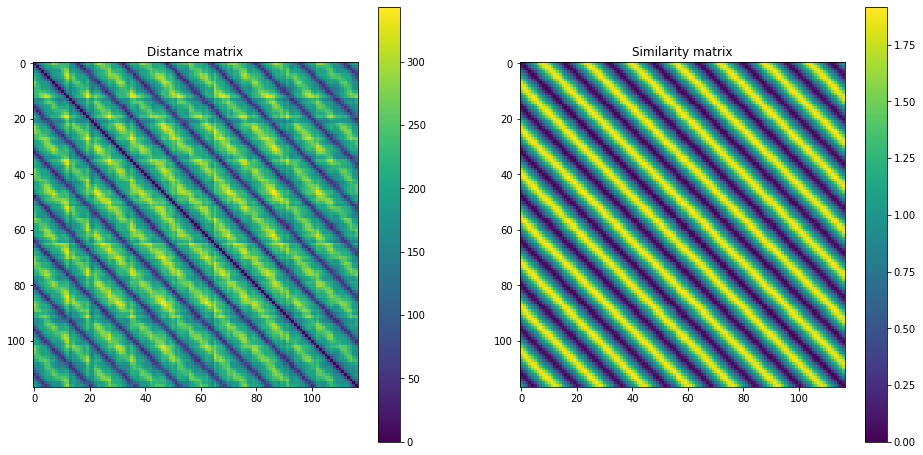

Batch 114/154 (G8 7) with 125 sequences


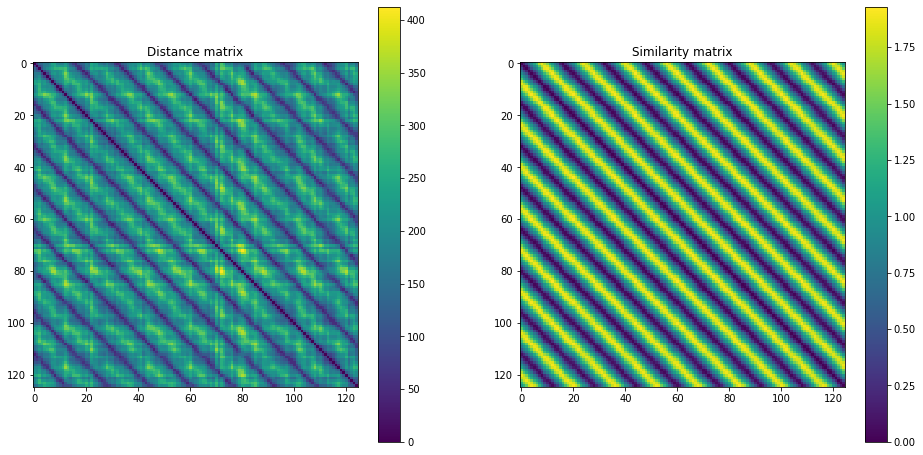

Batch 115/154 (G8 8) with 88 sequences


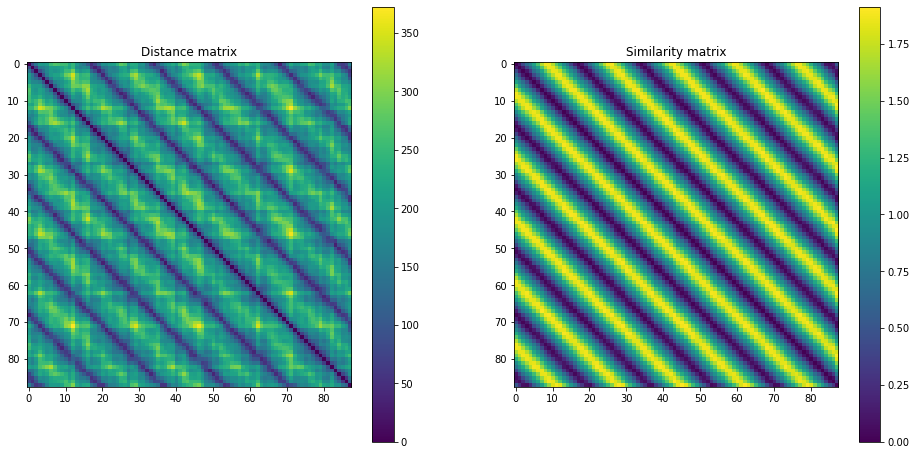

Batch 116/154 (G8 9) with 101 sequences


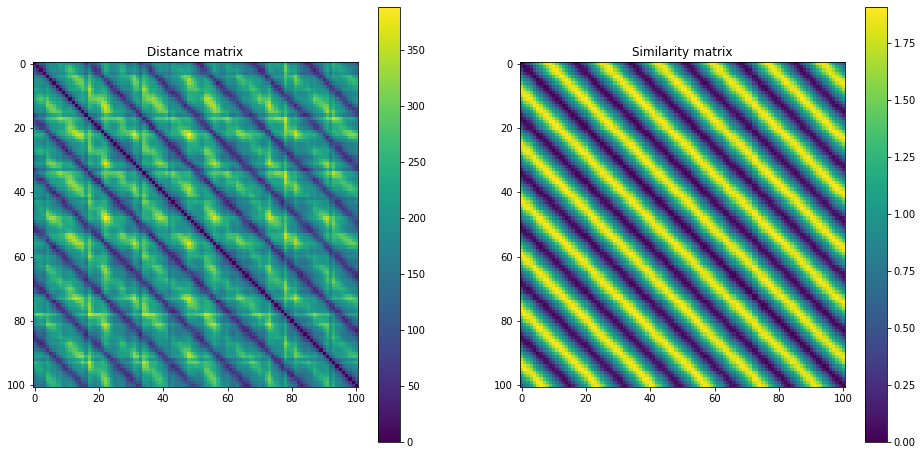

Batch 117/154 (G9 12) with 61 sequences


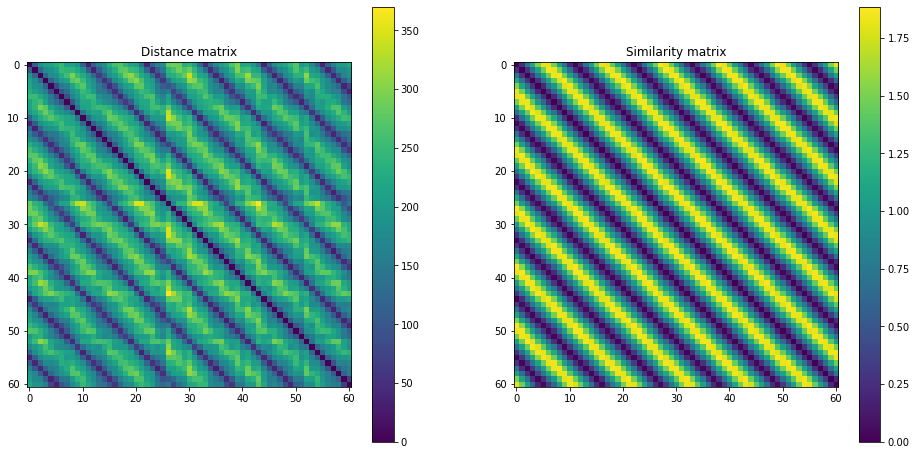

Batch 118/154 (G9 14) with 46 sequences


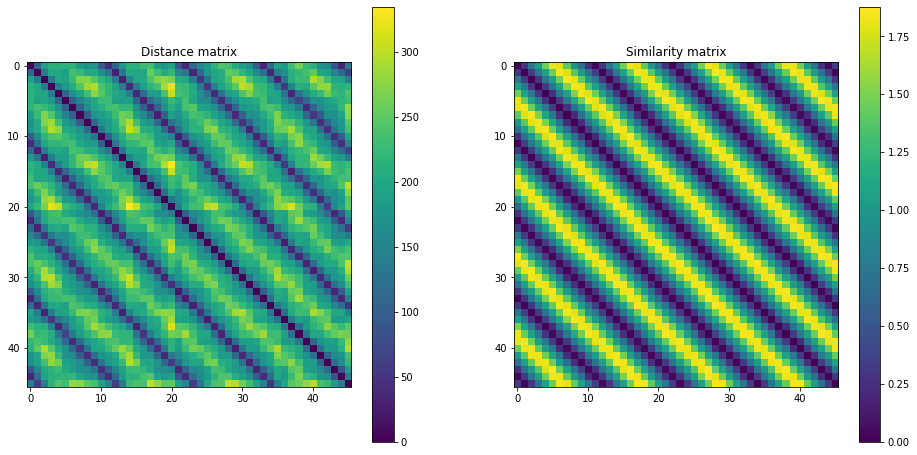

Batch 119/154 (G9 15) with 42 sequences


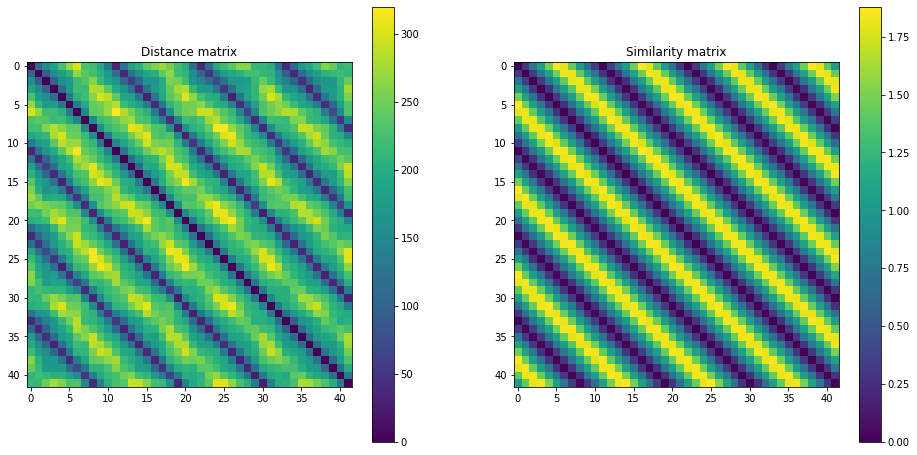

Batch 120/154 (G9 16) with 38 sequences


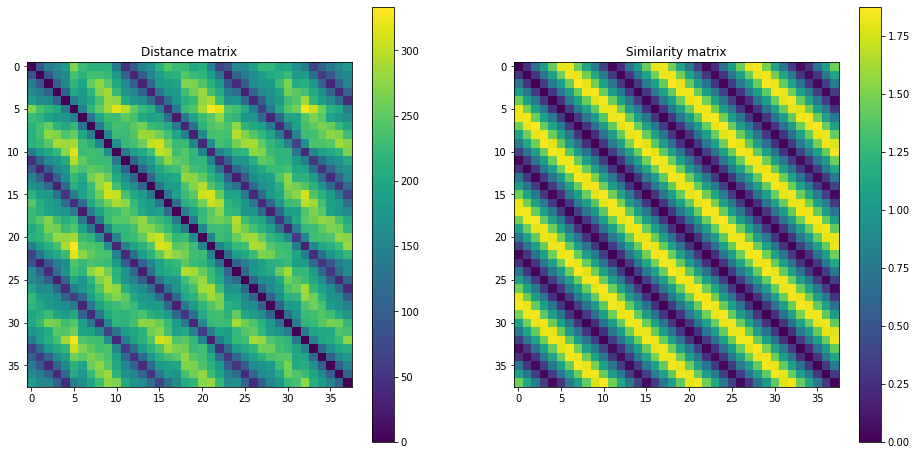

Batch 121/154 (G9 17) with 51 sequences


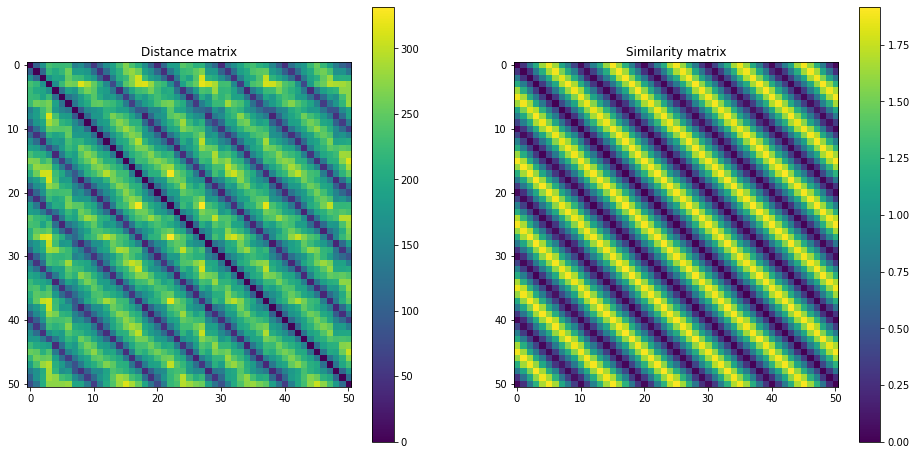

Batch 122/154 (G9 18) with 47 sequences


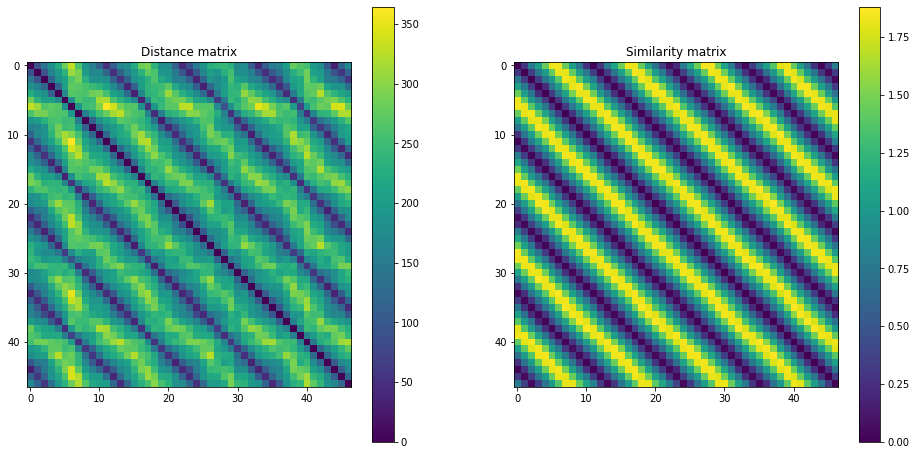

Batch 123/154 (JEL-10 LCA_30RA025CAU) with 53 sequences


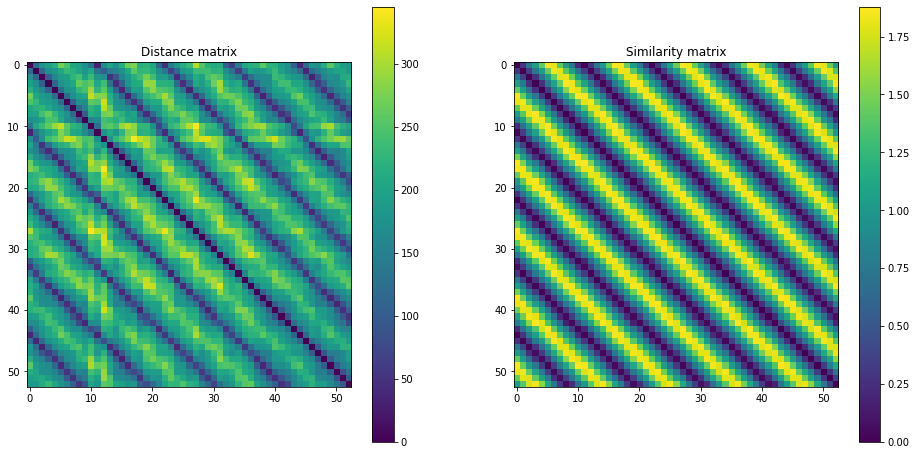

Batch 124/154 (JEL-10 LCA_30RAO) with 44 sequences


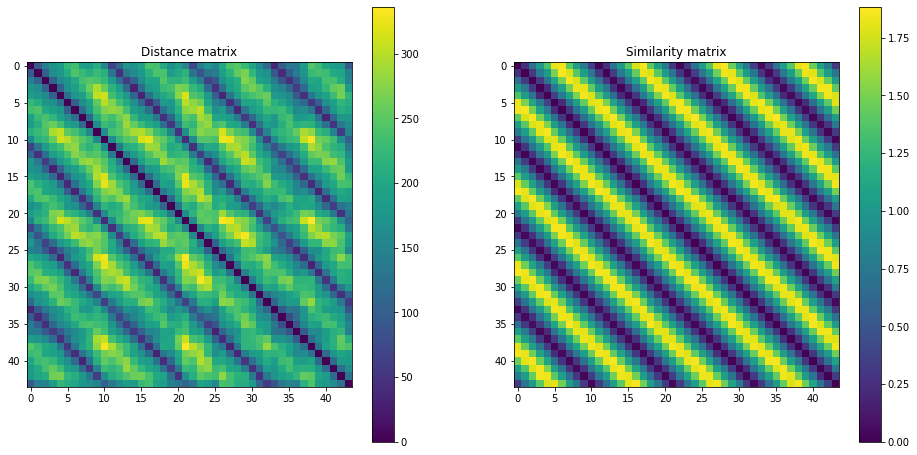

Batch 125/154 (JEL-10 LCA_AP) with 65 sequences


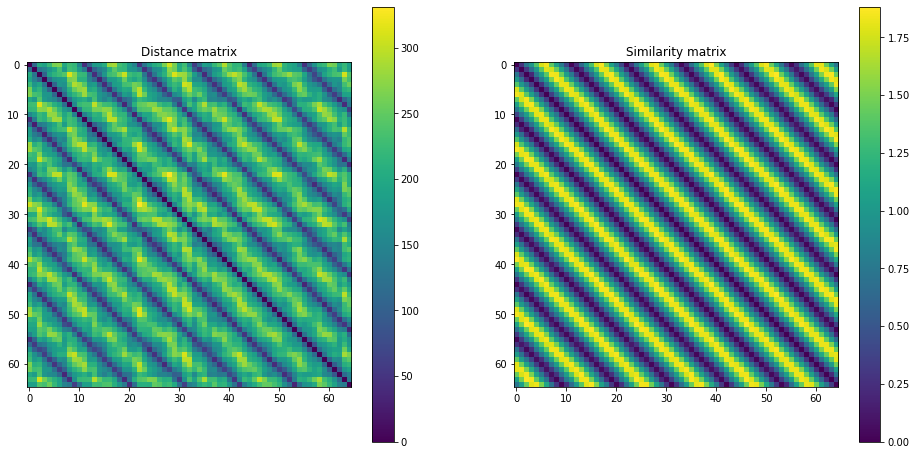

Batch 126/154 (JEL-10 LCA_LAT) with 66 sequences


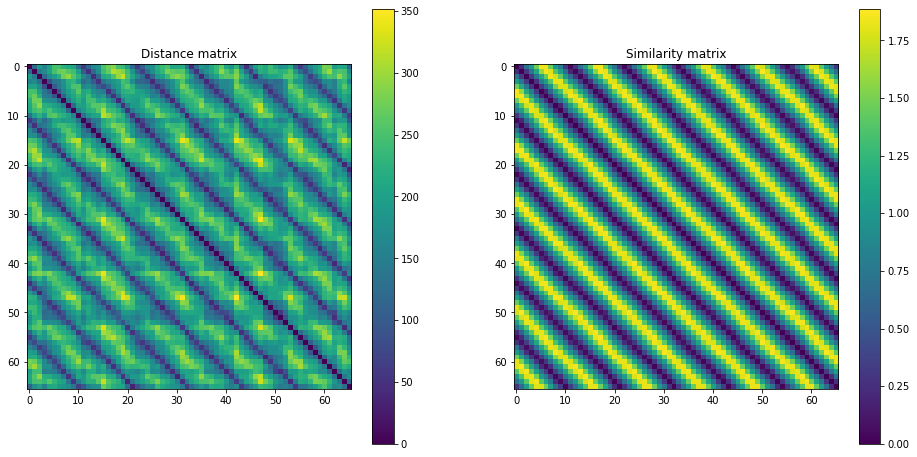

Batch 127/154 (JEL-10 RCA_AP) with 66 sequences


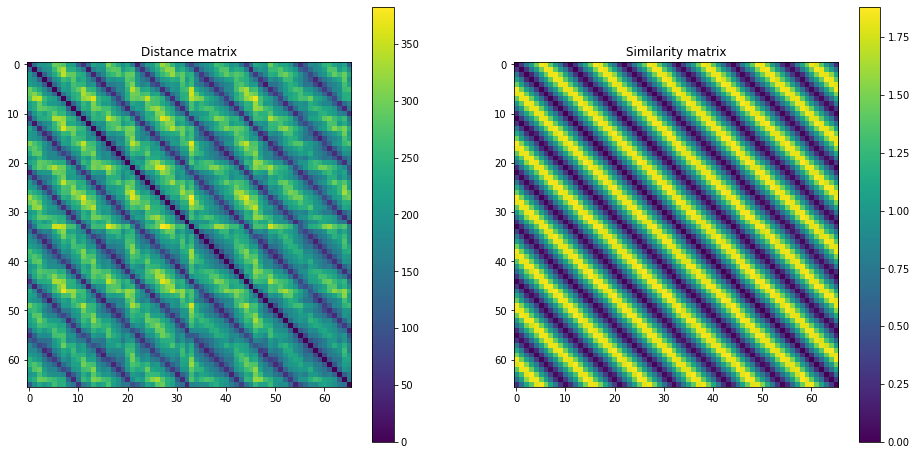

Batch 128/154 (JEL-10 RCA_LAT) with 62 sequences


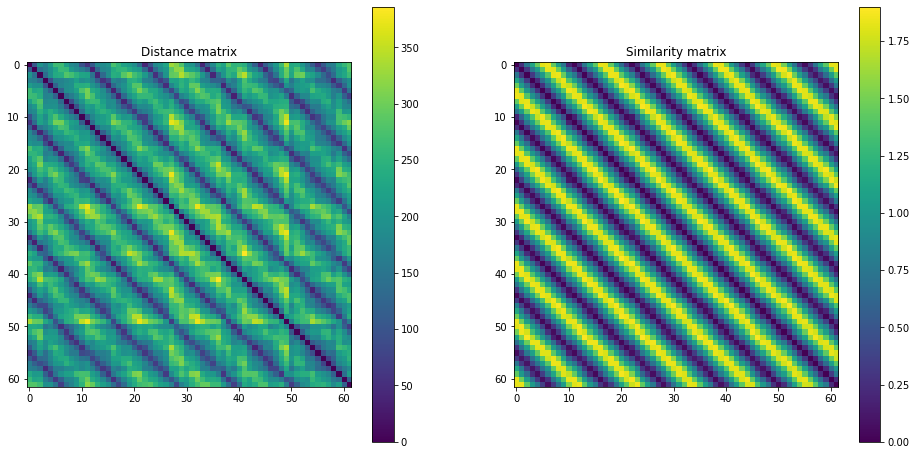

Batch 129/154 (KC-3 LCA_30RAO) with 80 sequences


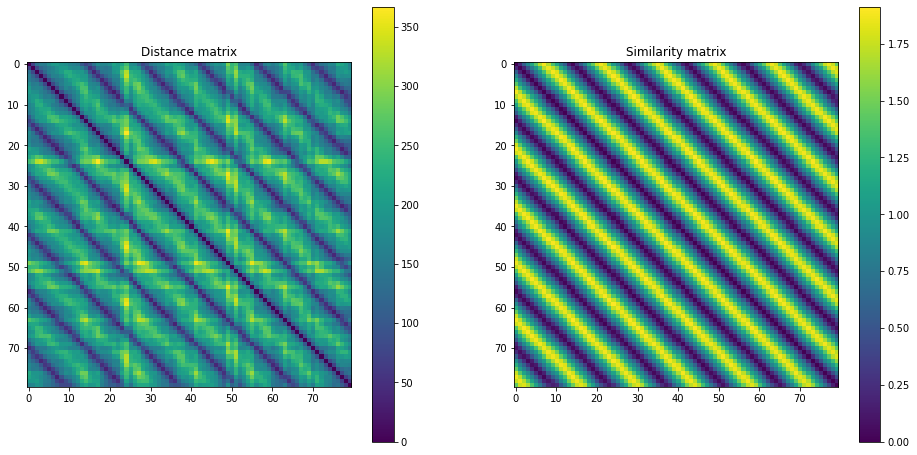

Batch 130/154 (KC-3 LCA_30RAO25CAU) with 96 sequences


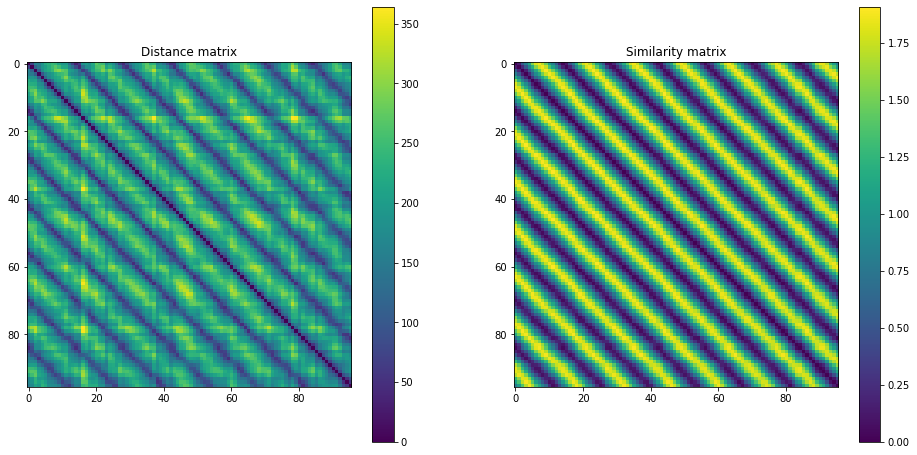

Batch 131/154 (KC-3 LCA_AP) with 79 sequences


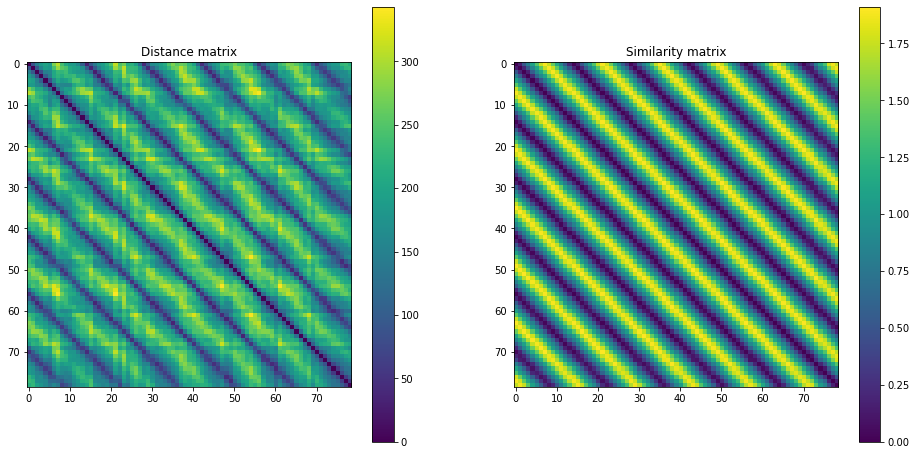

Batch 132/154 (KC-3 LCA_LAT) with 74 sequences


KeyboardInterrupt: 

In [31]:
def calc_distance_and_similarity_matrices(embeddings):
    distances = []
    similarities = []
    for i in range(len(embeddings)):
        distances_i = []
        similarities_i = []
        for j in range(len(embeddings)):
            if j < i:
                distances_i.append(distances[j][i])
                similarities_i.append(similarities[j][i])
            elif j == i:
                distances_i.append(0)
                similarities_i.append(0)
            else:
                # Distance
                dist_val = torch.sum(torch.abs(embeddings[i] - embeddings[j]))
                distances_i.append(dist_val.cpu().numpy())
                # Similarity
                normalized_embedding_i = embeddings[i] / torch.norm(embeddings[i])
                normalized_embedding_j = embeddings[j] / torch.norm(embeddings[j])
                sim_val = 1 - normalized_embedding_i.dot(normalized_embedding_j)
                similarities_i.append(sim_val.cpu().numpy())
        distances.append(distances_i)
        similarities.append(similarities_i)
    distances = np.array(distances)
    similarities = np.array(similarities)
    return distances, similarities

with torch.no_grad():
    all_embeddings = []
    names = []
    for batch_index, sequences in enumerate(test_loader):
        name = sequences[1][0]
        sequences = sequences[0]
        
        # sequences: (batch, video_frame, channel, width, height)
        embeddings = []
        print (f"Batch {batch_index + 1}/{len(test_loader)} ({name}) with {len(sequences[0])} sequences")
        embeddings = model(sequences[0])
        all_embeddings.append(embeddings)
        names.append(name)
        
        distance_matrix, similarity_matrix = calc_distance_and_similarity_matrices(embeddings)
        
        figure(figsize=(16,8))
        
        plt.subplot(1, 2, 1)
        plt.imshow(distance_matrix)
        plt.colorbar()
        plt.title(f"Distance matrix")
        
        plt.subplot(1, 2, 2)
        plt.imshow(similarity_matrix)
        plt.colorbar()
        plt.title(f"Similarity matrix")
        
        plt.show()

### Compute distance and similarity matrices for video comparison

In [ ]:
def calc_distance_and_similarity_matrices2(embeddings1, embeddings2):
    distances = []
    similarities = []
    for i in range(len(embeddings1)):
        distances_i = []
        similarities_i = []
        for j in range(len(embeddings2)):
            # Distance
            dist_val = torch.sum(torch.abs(embeddings1[i] - embeddings2[j]))
            distances_i.append(dist_val.cpu().numpy())
            # Similarity
            normalized_embedding_i = embeddings1[i] / torch.norm(embeddings1[i])
            normalized_embedding_j = embeddings2[j] / torch.norm(embeddings2[j])
            sim_val = 1 - normalized_embedding_i.dot(normalized_embedding_j)
            similarities_i.append(sim_val.cpu().numpy())
        distances.append(distances_i)
        similarities.append(similarities_i)
    distances = np.array(distances)
    similarities = np.array(similarities)
    return distances, similarities

with torch.no_grad():
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=1)
    try:
        all_embeddings
    except NameError:
        all_embeddings = []
        compute_embeddings = True
    else:
        compute_embeddings = False
    if compute_embeddings:
        print (f"Computing embeddings")
        names = []
        for batch_index, sequences in enumerate(test_loader):
            name = sequences[1][0]
            sequences = sequences[0]

            # sequences: (batch, video_frame, channel, width, height)
            embeddings = []
            print (f"Batch {batch_index + 1}/{len(test_loader)} ({name}) with {len(sequences[0])} sequences")
            embeddings = model(sequences[0])
            all_embeddings.append(embeddings)
            names.append(name)
    
    distance_matrices = {}
    similarity_matrices = {}
    current_name = None
    for i in range(len(all_embeddings)):
        name_i = names[i].split(' ')[0]
        if not name_i == current_name:
            print(f"Combinations of {name_i}")
        distance_matrices[names[i]] = {}
        similarity_matrices[names[i]] = {}
        current_name = name_i
        for j in range(i, len(all_embeddings)):
            if name_i == names[j].split(' ')[0]:
                print(f"Comparison of {names[i]} and {names[j]}")
                distance_matrix, similarity_matrix = calc_distance_and_similarity_matrices2(all_embeddings[i], all_embeddings[j])
                distance_matrices[names[i]][names[j]] = distance_matrix
                similarity_matrices[names[i]][names[j]] = similarity_matrix
                
                figure(figsize=(16,8))

                plt.subplot(1, 2, 1)
                plt.imshow(distance_matrix)
                plt.colorbar()
                plt.title(f"Distance matrix")

                plt.subplot(1, 2, 2)
                plt.imshow(similarity_matrix)
                plt.colorbar()
                plt.title(f"Similarity matrix")

                plt.show()

### Compare similar frames

In [ ]:
import cv2
nb_max_frames = 2
nb_min_frames = 2
total_frames = nb_max_frames + nb_min_frames + 1
for batch_index_a, sequences_a in enumerate(test_loader):
    name_a = sequences_a[1][0]
    sequences_a = sequences_a[0][0]
    print(name_a, sequences_a.shape)
    for batch_index_b, sequences_b in enumerate(test_loader):
        name_b = sequences_b[1][0]
        sequences_b = sequences_b[0][0]
        print(name_b, sequences_b.shape)
        if name_b in distance_matrices[name_a]:
            distance_matrix = distance_matrices[name_a][name_b]
            video_frames = []
            for frame_a in range(len(distance_matrix)):
                max_frame_indices = distance_matrix[frame_a].argsort()[:nb_max_frames]
                min_frame_indices = distance_matrix[frame_a].argsort()[-nb_max_frames:]
                img_frame_a = sequences_a[frame_a][-1]
        
                plt.clf()
                figure(figsize=(16,4))
                plt.subplot(1, total_frames, 1)
                plt.imshow(img_frame_a)
                plt.title(f"Base frame {frame_a}")
                for i, frame_b in enumerate(max_frame_indices):
                    img_frame_b = sequences_b[frame_b][-1]
                    plt.subplot(1, total_frames, i+2)
                    plt.imshow(img_frame_b)
                    plt.title(f"Similar frame {frame_b}")
                for i, frame_b in enumerate(min_frame_indices):
                    img_frame_b = sequences_b[frame_b][-1]
                    plt.subplot(1, total_frames, i+len(max_frame_indices)+2)
                    plt.imshow(img_frame_b)
                    plt.title(f"Dissimilar frame {frame_b}")
                plt.suptitle(f"Comparison of {name_a} ({sequences_a.shape[0]+2} frames) and {name_b} ({sequences_b.shape[0]+2} frames)")
                # plt.show()
                comparison_save_path = save_path + f"\\comparisons\\{name_a}\\{name_b}"
                if not os.path.isdir(comparison_save_path):
                    os.makedirs(comparison_save_path)
                plt.savefig(comparison_save_path + f"\\frame_{frame_a}.png")
                
#                 frame_b = np.argmax(distance_matrix[frame_a])
#                 img_frame_a = sequences_a[frame_a][-1]
#                 img_frame_b = sequences_b[frame_b][-1]
#                 video_frame = np.concatenate((img_frame_a, img_frame_b), axis=-1)
#                 video_frame = np.uint8(video_frame * 255)
# #                 video_frame = video_frame[np.newaxis, :, :]
# #                 video_frame = np.repeat(video_frame, 3, axis=0)
#                 video_frames.append(video_frame)
                
#                 figure(figsize=(16,8))
#                 plt.subplot(1, 2, 1)
#                 plt.imshow(img_frame_a)
#                 plt.title(f"Frame {frame_a}")
#                 plt.subplot(1, 2, 2)
#                 plt.imshow(img_frame_b)
#                 plt.title(f"Frame {frame_b}")
#                 plt.show()
                
#             vid = cv2.VideoWriter(save_path + f'/{name_a} with {name_b}.avi', cv2.VideoWriter_fourcc(*'XVID'), 15, video_frame.shape)
#             for i in range(len(video_frames)):
#                 vid.write(video_frames[i])
#             vid.release()
                
                
# for video_a in distance_matrices:
#     video_pairs = distance_matrices[video_a]
#     print(video_a, len(video_pairs))
#     for video_b in video_pairs:
#         distance_matrix = video_pairs[video_b]
#         print("-", video_b, distance_matrix.shape)
#         for frame_a in distance_matrix:
#             plt.plot(frame_a)
#             plt.show()

## Pathfinding

In [ ]:
import utils
reload(utils)
from utils import pathfinding

save_pairs = False
good_angle_pairs = [
#     ("G18 10", "G18 18"),
#     ("G18 13", "G18 17"),
#     ("G18 13", "G18 18"),
#     ("G18 14", "G18 18"),
#     ("G18 15", "G18 18"),
#     ("G18 17", "G18 18"),
#     ("G18 18", "G18 18"),
#     ("G18 18", "G18 19"),
#     ("G18 18", "G18 9")
]

distance_score_means = []
similarity_score_means = []
for batch_index_a, sequences_a in enumerate(test_loader):
    name_a = sequences_a[1][0]
    if len(good_angle_pairs) > 0:
        found = False
        for good_angle_pair in good_angle_pairs:
            if good_angle_pair[0] == name_a:
                found = True
                break
        if not found:
            continue
    sequences_a = sequences_a[0][0]
    for batch_index_b, sequences_b in enumerate(test_loader):
        name_b = sequences_b[1][0]
        sequences_b = sequences_b[0][0]
        if len(good_angle_pairs) > 0 and (name_a, name_b) not in good_angle_pairs:
            continue
        if name_b in distance_matrices[name_a]:
            symmetrical = name_a == name_b
            distance_matrix = np.copy(distance_matrices[name_a][name_b])
            similarity_matrix = np.copy(similarity_matrices[name_a][name_b])
            ground_truth = test_set.get_similarity_matrix(name_a, name_b)
            figure(figsize=(24,8))
            plt.subplot(1, 3, 1)
            plt.imshow(distance_matrix)
            plt.title(f"Distance matrix of {name_a} and {name_b}")
            plt.subplot(1, 3, 2)
            plt.imshow(similarity_matrix)
            plt.title(f"Similarity matrix of {name_a} and {name_b}")
            plt.subplot(1, 3, 3)
            plt.imshow(1 - ground_truth)
            plt.title(f"Ground truth similarity matrix of {name_a} and {name_b}")
            plt.show()
            for i in range(2):
                matrix = distance_matrix if i == 0 else similarity_matrix
                line_value = matrix.max() * 1.5
                if symmetrical:
                    # Erase center line
                    for i in range(len(matrix)):
                        matrix[i, i] = matrix.max()
                        for j in range(4):
                            if i > j:
                                offset = j + 1
                                matrix[i-offset, i] = matrix.max()
                                matrix[i, i-offset] = matrix.max()
                nodes = pathfinding(matrix, symmetrical)
                scores = []
                for pathfinding_index, node in enumerate(nodes):
                    # print(node.point, node.cost)
                    pairs = []
                    while node is not None:
                        pairs.append(node.point)
                        node = node.parent
                    if len(pairs) < 10:
                        continue
                    for point in pairs:
                        scores.append(ground_truth[point])
                        matrix[point] += line_value
                    if save_pairs:
                        comparison_save_path = test_folder_path + f"\\comparisons\\{name_a}\\{name_b}\\pathfinding\\{pathfinding_index}"
                        if not os.path.isdir(comparison_save_path):
                            os.makedirs(comparison_save_path)
                        for i, pair in enumerate(pairs):
                            plt.subplot(1, 2, 1)
                            plt.imshow(sequences_a[pair[0], -1])
                            plt.title(f"Frame {pair[0]}")
                            plt.subplot(1, 2, 2)
                            plt.imshow(sequences_b[pair[1], -1])
                            plt.title(f"Frame {pair[1]}")
                            plt.suptitle(f"{name_a} vs {name_b}")
                            plt.savefig(comparison_save_path + f"\\{i}.png")
                            
                bins = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
                scores = np.array(scores)
                print("Mean score:", scores.mean(), f"for {len(scores)} scores")
                (distance_score_means if i == 0 else similarity_score_means).append(scores.mean())
                figure(figsize=(16,8))
                plt.subplot(1, 2, 1)
                plt.imshow(matrix)
                plt.title(f"Pathfinding on {name_a} and {name_b}")
                plt.subplot(1, 2, 2)
                plt.hist(scores, bins, histtype='stepfilled', cumulative=True)
                plt.title(f"Cumulative histogram of scores for {name_a} and {name_b}")
                plt.xlabel("Similarity of pathfinding points")
                plt.ylabel("Cumulative count of pathfinding points")
                plt.show()

distance_score_means = np.array(distance_score_means)
similarity_score_means = np.array(similarity_score_means)
print("Total distance mean score:", distance_score_means.mean())
print("Total similarity mean score:", similarity_score_means.mean())